# Multiclass tutorial


# Manage Packages

## Import package

In [2]:
import random, gc, os, sys, time
import pandas as pd
import numpy as np
from watermark import watermark
import torch.nn as nn
from torch.optim import AdamW
from beevibe import MultiClassTrainer, BeeCustomMaskModelForClassification

PydanticSchemaGenerationError: Unable to generate pydantic-core schema for <class 'numpy.ndarray'>. Set `arbitrary_types_allowed=True` in the model_config to ignore this error or implement `__get_pydantic_core_schema__` on your type to fully support it.

If you got this error by calling handler(<some type>) within `__get_pydantic_core_schema__` then you likely need to call `handler.generate_schema(<some type>)` since we do not call `__get_pydantic_core_schema__` on `<some type>` otherwise to avoid infinite recursion.

For further information visit https://errors.pydantic.dev/2.10/u/schema-for-unknown-type

## GPU Card

In [2]:
!nvidia-smi

/bin/bash: nvidia-smi: command not found


## Drive Directory

<!> Please adjust to your notebook path

In [3]:
# Path sur le projet
sys.path.insert(0, "..")

## Packages versions

In [4]:
print(watermark())

Last updated: 2024-12-28T18:39:14.932292+00:00

Python implementation: CPython
Python version       : 3.12.1
IPython version      : 8.30.0

Compiler    : GCC 9.4.0
OS          : Linux
Release     : 6.5.0-1025-azure
Machine     : x86_64
Processor   : x86_64
CPU cores   : 2
Architecture: 64bit



In [5]:
print(watermark(packages="pandas,numpy,scipy,sklearn,torch,transformers,tokenizers,sentencepiece,datasets,beevibe"))

pandas       : 2.2.3
numpy        : 2.2.1
scipy        : 1.14.1
sklearn      : 1.6.0
torch        : 2.5.1
transformers : 4.47.1
tokenizers   : 0.21.0
sentencepiece: 0.2.0
datasets     : 3.2.0
beevibe      : 0.1.0.dev6



## Global parameters

In [6]:
SEED = 1811
EXCEL_PATH = '../dataset/elegana'
CSV_FILE_NAME_TRAIN = "elegana_train_v0_1.csv"
CSV_FILE_NAME_TEST = "elegana_test_v0_1.csv"
CSV_FILE_NAME_THEMES = "elegana_themes_v0_1.csv"

# Chargement des données

In [7]:
pd_train = pd.read_csv(EXCEL_PATH+'/'+CSV_FILE_NAME_TRAIN, sep="|")
pd_themes = pd.read_csv(EXCEL_PATH+'/'+CSV_FILE_NAME_THEMES, sep="|")
pd_data = pd.merge(pd_train, pd_themes, on="THEME", how='left')
pd_data = pd_data.sample(200, random_state=1811)

## Get Train

In [8]:
pd_data.columns

Index(['CLIENT', 'CONSEILLER', 'THEME', 'DESCRIPTION', '2_CLASSES',
       '5_CLASSES', 'LABEL_1', 'LABEL_2', 'LABEL_3', 'LABEL_4'],
      dtype='object')

In [9]:
from sklearn.preprocessing import LabelEncoder

# Get THEME Labels
classes = np.unique(pd_data['5_CLASSES'])
le_esg = LabelEncoder()
le_esg.fit(classes)
#le_esg.transform(classes)
classes_names = classes[le_esg.transform(classes)]
labels = le_esg.transform(pd_data['5_CLASSES']).tolist() #[:100]).tolist()
classes = np.unique(labels)


# Get sentences
texts = pd_data["CLIENT"].values.tolist() #[:100]
len(texts), len(labels), len(classes)

(200, 200, 5)

In [10]:
pd_data['5_CLASSES'].value_counts()

5_CLASSES
Services exclusifs, programmes et personnalisations    90
Engagements, événements et initiatives                 46
Commandes, livraison et suivi                          31
Conseils et informations produits                      24
Assistance technique et support immédiat                9
Name: count, dtype: int64

# Training

In [12]:
num_epochs = 1
batch_size = 2 # 8
train_size = 0.1

model_name = "camembert-base" #"google-bert/bert-large-cased-whole-word-masking" #"google-bert/bert-base-multilingual-cased" #"google-bert/bert-base-uncased" #"camembert-base" # "almanach/camembertv2-base"

trainer = MultiClassTrainer(model_name=model_name,
                            classes_names=classes_names,
                            )

ret = trainer.train(texts=texts,
                    labels=labels,
                    train_size=train_size,
                    num_epochs=num_epochs,
                    batch_size=batch_size
                    )

Device : cpu
Call default optimizer :
 - lr:1e-05
Use scheduler
Call default scheduler :
 - mode:min
 - factor:0.8
 - patience:2
Epoch 0/0, Training Loss: 1.5850
ReduceLROnPlateau scheduler can't be used without validation losses


### Test Trainer parameters

In [12]:
classes_names

array(['Assistance technique et support immédiat',
       'Commandes, livraison et suivi',
       'Conseils et informations produits',
       'Engagements, événements et initiatives',
       'Services exclusifs, programmes et personnalisations'],
      dtype=object)

In [13]:
num_epochs = 1
batch_size = 2 # 8
train_size = 0.1

model_name = "camembert-base" #"google-bert/bert-large-cased-whole-word-masking" #"google-bert/bert-base-multilingual-cased" #"google-bert/bert-base-uncased" #"camembert-base" # "almanach/camembertv2-base"

trainer = MultiClassTrainer(model_name=model_name,
                            classes_names=classes_names.tolist(),
                            )

Device : cpu


### Test Pydantic

In [11]:
from beevibe.utils.validator import DatasetConfig

In [17]:
try:
    config = DatasetConfig(seed=1.0, texts=["1"], labels=[3])
except TypeError as e:
    print(e)  # "seed must be an integer."
    sys.exit(1)  # Stop execution


seed must be an integer.


SystemExit: 1

/home/codespace/.local/lib/python3.12/site-packages/IPython/core/interactiveshell.py:3585: UserWarning: To exit: use 'exit', 'quit', or Ctrl-D.
  warn("To exit: use 'exit', 'quit', or Ctrl-D.", stacklevel=1)


### Test Model Forward

In [12]:
num_epochs = 1
batch_size = 2 # 8
train_size = 0.1


model_name = "camembert-base" #"google-bert/bert-large-cased-whole-word-masking" #"google-bert/bert-base-multilingual-cased" #"google-bert/bert-base-uncased" #"camembert-base" # "almanach/camembertv2-base"
num_classes = len(classes)

# Create custom model : Normalized Layers
custom_layer_configs = [
        {"input_size": 768, "output_size": 512, "activation": nn.ReLU, "batch_norm": True},
        {"input_size": 512, "output_size": 256, "activation": nn.ReLU, "layer_norm": True},
        {"input_size": 256, "output_size": num_classes, "activation": None},
    ]

def custom_model_creator(model_name, num_classes) :
  model = BVCustomMaskModelForClassification(
    model_name=model_name,
    num_labels=num_classes,
    layer_configs=custom_layer_configs
  )
  return model


trainer = MultiClassTrainer(model_name=model_name,
                            model_creator=custom_model_creator,
                            classes_names=classes_names,
                            using_lora=True
                            )


ret = trainer.train(texts=texts,
                    labels=labels,
                    train_size=train_size,
                    num_epochs=num_epochs,
                    batch_size=batch_size
                    )


Device : cpu
Using Lora
Call default optimizer :
 - lr:1e-05
Use scheduler
Call default scheduler :
 - mode:min
 - factor:0.8
 - patience:2
Epoch 0/0, Training Loss: 1.6227
ReduceLROnPlateau scheduler can't be used without validation losses


In [12]:
for name, param in trainer.model.named_parameters():
    print(name)

base_model.embeddings.word_embeddings.weight
base_model.embeddings.position_embeddings.weight
base_model.embeddings.token_type_embeddings.weight
base_model.embeddings.LayerNorm.weight
base_model.embeddings.LayerNorm.bias
base_model.encoder.layer.0.attention.self.query.weight
base_model.encoder.layer.0.attention.self.query.bias
base_model.encoder.layer.0.attention.self.key.weight
base_model.encoder.layer.0.attention.self.key.bias
base_model.encoder.layer.0.attention.self.value.weight
base_model.encoder.layer.0.attention.self.value.bias
base_model.encoder.layer.0.attention.output.dense.weight
base_model.encoder.layer.0.attention.output.dense.bias
base_model.encoder.layer.0.attention.output.LayerNorm.weight
base_model.encoder.layer.0.attention.output.LayerNorm.bias
base_model.encoder.layer.0.intermediate.dense.weight
base_model.encoder.layer.0.intermediate.dense.bias
base_model.encoder.layer.0.output.dense.weight
base_model.encoder.layer.0.output.dense.bias
base_model.encoder.layer.0.outp

In [11]:
model_name = "camembert-base" #"google-bert/bert-large-cased-whole-word-masking" #"google-bert/bert-base-multilingual-cased" #"google-bert/bert-base-uncased" #"camembert-base" # "almanach/camembertv2-base"
num_classes = len(classes)

# Create custom model : Normalized Layers
custom_layer_configs = [
        {"input_size": 768, "output_size": 512, "activation": nn.ReLU, "batch_norm": True},
        {"input_size": 512, "output_size": 256, "activation": nn.ReLU, "layer_norm": True},
        {"input_size": 256, "output_size": num_classes, "activation": None},
    ]

model = BVCustomMaskModelForClassification(
model_name=model_name,
num_labels=num_classes,
layer_configs=custom_layer_configs
)

from peft import LoraConfig, TaskType

def find_target_modules(model):
    target_modules = []
    for name, module in model.named_modules():
        if any(keyword in name for keyword in ["query", "key", "dense"]):
            target_modules.append(name)
    return target_modules

target_modules = find_target_modules(model)

# Configure LoRA
lora_config = LoraConfig(
    task_type=TaskType.SEQ_CLS, 
    r=8,                        # Rank of low-rank decomposition
    lora_alpha=32,              # Scaling factor
    target_modules=target_modules,  # Target modules for LoRA
    lora_dropout=0.1,           # Dropout for regularization
    bias="none"                 # Do not fine-tune biases
)


from peft import get_peft_model
model = get_peft_model(model, lora_config)



In [12]:
model.config

CamembertConfig {
  "_attn_implementation_autoset": true,
  "_name_or_path": "camembert-base",
  "architectures": [
    "CamembertForMaskedLM"
  ],
  "attention_probs_dropout_prob": 0.1,
  "bos_token_id": 5,
  "classifier_dropout": null,
  "eos_token_id": 6,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 768,
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "layer_norm_eps": 1e-05,
  "max_position_embeddings": 514,
  "model_type": "camembert",
  "num_attention_heads": 12,
  "num_hidden_layers": 12,
  "output_past": true,
  "pad_token_id": 1,
  "position_embedding_type": "absolute",
  "transformers_version": "4.47.1",
  "type_vocab_size": 1,
  "use_cache": true,
  "vocab_size": 32005
}

In [22]:
from transformers import AutoModel
model_name = "camembert-base"
base_model = AutoModel.from_pretrained(model_name)

target_modules = find_target_modules(base_model)

# Configure LoRA
lora_config = LoraConfig(
    task_type=TaskType.SEQ_CLS, 
    r=8,                        # Rank of low-rank decomposition
    lora_alpha=32,              # Scaling factor
    target_modules=target_modules,  # Target modules for LoRA
    lora_dropout=0.1,           # Dropout for regularization
    bias="none"                 # Do not fine-tune biases
)


from peft import get_peft_model
peft_model = get_peft_model(base_model, lora_config)


In [23]:
peft_model.config

CamembertConfig {
  "_attn_implementation_autoset": true,
  "_name_or_path": "camembert-base",
  "architectures": [
    "CamembertForMaskedLM"
  ],
  "attention_probs_dropout_prob": 0.1,
  "bos_token_id": 5,
  "classifier_dropout": null,
  "eos_token_id": 6,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 768,
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "layer_norm_eps": 1e-05,
  "max_position_embeddings": 514,
  "model_type": "camembert",
  "num_attention_heads": 12,
  "num_hidden_layers": 12,
  "output_past": true,
  "pad_token_id": 1,
  "position_embedding_type": "absolute",
  "transformers_version": "4.47.1",
  "type_vocab_size": 1,
  "use_cache": true,
  "vocab_size": 32005
}

In [14]:
# Training features
num_epochs = 15 # 15
patience = 3
min_delta = 0.001
val_size = 0.3
batch_size = 8 # 8

# Model features
model_name = "camembert-base" # "almanach/camembertv2-base"
num_classes = len(classes)

# Create optimizer :AdamW
custom_optimizer_params = {
    'lr': 1e-5,
}

def custom_optimizer_creator(model, **params):
    return AdamW(model.parameters(), lr=params.get('lr'))

# Create custom model : Normalized Layers
custom_layer_configs = [
        {"input_size": 768, "output_size": 512, "activation": nn.ReLU, "batch_norm": True},
        {"input_size": 512, "output_size": 256, "activation": nn.ReLU, "layer_norm": True},
        {"input_size": 256, "output_size": num_classes, "activation": None},
    ]

def custom_model_creator(model_name, num_classes) :
  model = BVCustomMaskModelForClassification(
    model_name=model_name,
    num_labels=num_classes,
    layer_configs=custom_layer_configs
  )
  return model

# Create Multi-classes trainer
print("Create Trainer")
trainer = MultiClassTrainer(model_name=model_name,
                            optimizer_creator=custom_optimizer_creator,
                            optimizer_params=custom_optimizer_params,
                            model_creator=custom_model_creator,
                            classes_names=classes_names,
                            using_lora=True
                            )


# Train an Holdout
print("Train with early stopping ..")
ret = trainer.holdout(texts=texts,
              labels=labels,
              val_size=val_size,
              num_epochs=num_epochs,
              batch_size=batch_size,
              patience=patience,
              min_delta=min_delta,
              balanced=True
              )

# Free CPU/GPU memory
trainer.release_model()

Device : cpu


Create Trainer
Train with early stopping ..


Using Lora
Use scheduler
Call default scheduler :
 - mode:min
 - factor:0.8
 - patience:2
Epoch 0/0, Train Loss: 1.6303, Val Loss: 1.6902, Val MCC: -0.0186, lr: 1.000e-05
Best epoch: 0, Best loss: 1.6902


** Global metrics :

 - accuracy: 0.1500
 - f1_macro: 0.0915
 - f1_micro: 0.1500
 - f1_weighted: 0.0866
 - mcc: -0.0186


** Per-Classes metrics :

Class                                                      Precision      Recall          F1     Support
Assistance technique et support immédiat                      0.0000      0.0000      0.0000           8
Commandes, livraison et suivi                                 0.0000      0.0000      0.0000          22
Conseils et informations produits                             0.1140      0.6190      0.1926          21
Engagements, événements et initiatives                        0.2391      0.2973      0.2651          37
Services exclusifs, programmes et personnalisations           0.0000      0.0000      0.0000          72


** Confusion M

# Holdout

In [14]:
# Training features
num_epochs = 1 # 15
patience = 3
min_delta = 0.001
val_size = 0.8
batch_size = 2 # 8

# Model features
model_name = "camembert-base" # "almanach/camembertv2-base"
num_classes = len(classes)

# Create optimizer :AdamW
custom_optimizer_params = {
    'lr': 1e-5,
}

def custom_optimizer_creator(model, **params):
    return AdamW(model.parameters(), lr=params.get('lr'))

# Create custom model : Normalized Layers
custom_layer_configs = [
        {"input_size": 768, "output_size": 512, "activation": nn.ReLU, "batch_norm": True},
        {"input_size": 512, "output_size": 256, "activation": nn.ReLU, "layer_norm": True},
        {"input_size": 256, "output_size": num_classes, "activation": None},
    ]

def custom_model_creator(model_name, num_classes) :
  model = BVCustomMaskModelForClassification(
    model_name=model_name,
    num_labels=num_classes,
    layer_configs=custom_layer_configs
  )
  return model

# Create Multi-classes trainer
print("Create Trainer")
trainer = MultiClassTrainer(model_name=model_name,
                            optimizer_creator=custom_optimizer_creator,
                            optimizer_params=custom_optimizer_params,
                            model_creator=custom_model_creator,
                            classes_names=classes_names,
                            )


# Train an Holdout
print("Train with early stopping ..")
ret = trainer.holdout(texts=texts,
              labels=labels,
              val_size=val_size,
              num_epochs=num_epochs,
              batch_size=batch_size,
              patience=patience,
              min_delta=min_delta,
              balanced=True
              )

# Free CPU/GPU memory
trainer.release_model()

Device : cpu


Create Trainer
Train with early stopping ..


Use scheduler
Call default scheduler :
 - mode:min
 - factor:0.8
 - patience:2


: 

# Cross Validation

In [ ]:
# Training features
num_epochs = 1 # 15
patience = 3
min_delta = 0.001
val_size = 0.3
batch_size = 2 # 8
n_splits = 3

# Model features
model_name = "camembert-base" # "almanach/camembertv2-base"
num_classes = len(classes)

# Create optimizer :AdamW
custom_optimizer_params = {
    'lr': 1e-5,
}

def custom_optimizer_creator(model, **params):
    return AdamW(model.parameters(), lr=params.get('lr'))

# Create custom model : Normalized Layers
custom_layer_configs = [
        {"input_size": 768, "output_size": 512, "activation": nn.ReLU, "batch_norm": True},
        {"input_size": 512, "output_size": 256, "activation": nn.ReLU, "layer_norm": True},
        {"input_size": 256, "output_size": num_classes, "activation": None},
    ]

def custom_model_creator(model_name, num_classes) :
  model = CustomModelParams(
    model_name=model_name,
    num_labels=num_classes,
    layer_configs=custom_layer_configs
  )
  return model

# Create Multi-classes trainer
print("Create Trainer")
trainer = MultiClassTrainer(model_name=model_name,
                            optimizer_creator=custom_optimizer_creator,
                            optimizer_params=custom_optimizer_params,
                            model_creator=custom_model_creator,
                            classes_names=classes_names,
                            )


# Train an Holdout
print("Train with early stopping ..")
rets = trainer.cross_validation(texts=texts,
              labels=labels,
              n_splits=n_splits,
              num_epochs=num_epochs,
              batch_size=batch_size,
              patience=patience,
              min_delta=min_delta,
              balanced=True
              )


# Free CPU/GPU memory
trainer.release_model()

# End of game

### ESRS multi-classes

In [ ]:
# Training features
num_epochs = 15
patience = 3
min_delta = 0.001
val_size = 0.3
batch_size = 8

# Model features
model_name = "camembert-base"
num_classes = len(classes_ESRS)
classes_names = classes_names_ESRS
labels = labels_ESRS

# Create optimizer :AdamW
custom_optimizer_params = {
    'lr': 1e-5,
}

def custom_optimizer_creator(model, **params):
    return AdamW(model.parameters(), lr=params.get('lr'))


# Create custom model : Normalized Layers
custom_layer_configs = [
        {"input_size": 768, "output_size": 512, "activation": nn.ReLU, "batch_norm": True},
        {"input_size": 512, "output_size": 256, "activation": nn.ReLU, "layer_norm": True},
        {"input_size": 256, "output_size": num_classes, "activation": None},
    ]

def custom_model_creator(model_name, num_labels) :
  model = CustomModelParams(
    model_name=model_name,
    num_labels=num_labels,
    layer_configs=custom_layer_configs
  )
  return model

# Create Multi-classes trainer
print("Create Trainer")
trainer = MultiClassTrainer(model_name=model_name,
                            optimizer_creator=custom_optimizer_creator,
                            optimizer_params=custom_optimizer_params,
                            model_creator=custom_model_creator,
                            classes_names=classes_names,
                            )


# Train an Holdout
print("Train with early stopping ..")
ret = trainer.holdout(texts=texts,
              labels=labels,
              val_size=val_size,
              num_epochs=num_epochs,
              batch_size=batch_size,
              patience=patience,
              min_delta=min_delta,
              balanced=True
              )

# Free GPU memory
print("Release model ..  ")
trainer.model = None
gc.collect()
if device.startswith("cuda"):
    torch.cuda.empty_cache()
    torch.cuda.synchronize()

print("\n")



Device : cuda


Create Trainer
Train with early stopping ..


Use scheduler
Call default scheduler :
 - mode:min
 - factor:0.8
 - patience:2
Epoch 0/14, Train Loss: 2.1931, Val Loss: 1.5370, Val MCC: 0.6270, lr: 1.000e-05
Epoch 1/14, Train Loss: 1.4124, Val Loss: 0.9981, Val MCC: 0.7530, lr: 1.000e-05
Epoch 2/14, Train Loss: 0.9203, Val Loss: 0.7569, Val MCC: 0.7816, lr: 1.000e-05
Epoch 3/14, Train Loss: 0.6537, Val Loss: 0.6435, Val MCC: 0.8163, lr: 1.000e-05
Epoch 4/14, Train Loss: 0.5051, Val Loss: 0.5880, Val MCC: 0.8296, lr: 1.000e-05
Epoch 5/14, Train Loss: 0.3908, Val Loss: 0.5427, Val MCC: 0.8369, lr: 1.000e-05
Epoch 6/14, Train Loss: 0.3069, Val Loss: 0.5406, Val MCC: 0.8359, lr: 1.000e-05
Epoch 7/14, Train Loss: 0.2374, Val Loss: 0.5062, Val MCC: 0.8451, lr: 1.000e-05
Epoch 8/14, Train Loss: 0.1891, Val Loss: 0.5077, Val MCC: 0.8380, lr: 1.000e-05
Epoch 9/14, Train Loss: 0.1461, Val Loss: 0.5035, Val MCC: 0.8495, lr: 1.000e-05
Epoch 10/14, Train Loss: 0.1245, Val Loss: 0.5247, Val MCC: 0.8373, lr: 1.000e-05
Epoch 11/14, Train Loss: 0.10

Release model ..  




# Cross validation

### ESG multi-classes

In [ ]:
# Training features
num_epochs = 15
patience = 3
min_delta = 0.001
val_size = 0.3
batch_size = 8
n_splits = 3


# Model features
model_name = "camembert-base"
num_classes = len(classes_ESG)
classes_names = classes_names_ESG
labels = labels_ESG

# Create optimizer :AdamW
custom_optimizer_params = {
    'lr': 1e-5,
}

def custom_optimizer_creator(model, **params):
    return AdamW(model.parameters(), lr=params.get('lr'))


# Create custom model : Normalized Layers
custom_layer_configs = [
        {"input_size": 768, "output_size": 512, "activation": nn.ReLU, "batch_norm": True},
        {"input_size": 512, "output_size": 256, "activation": nn.ReLU, "layer_norm": True},
        {"input_size": 256, "output_size": num_classes, "activation": None},
    ]

def custom_model_creator(model_name, num_labels) :
  model = CustomModelParams(
    model_name=model_name,
    num_labels=num_labels,
    layer_configs=custom_layer_configs
  )
  return model

# Create Multi-classes trainer
print("Create Trainer")
trainer = MultiClassTrainer(model_name=model_name,
                            optimizer_creator=custom_optimizer_creator,
                            optimizer_params=custom_optimizer_params,
                            model_creator=custom_model_creator,
                            classes_names=classes_names,
                            )


# Train an Holdout
print("Train with early stopping ..")
rets = trainer.cross_validation(texts=texts,
              labels=labels,
              n_splits=n_splits,
              num_epochs=num_epochs,
              batch_size=batch_size,
              patience=patience,
              min_delta=min_delta,
              balanced=True
              )


# Free GPU memory
print("Release model ..  ")
trainer.model = None
gc.collect()
if device.startswith("cuda"):
    torch.cuda.empty_cache()
    torch.cuda.synchronize()

print("\n")



### ESRS multi-classes

In [ ]:
# Training features
num_epochs = 15
patience = 3
min_delta = 0.001
val_size = 0.3
batch_size = 8
n_splits = 3


# Model features
model_name = "camembert-base"
num_classes = len(classes_ESRS)
classes_names = classes_names_ESRS
labels = labels_ESRS

# Create optimizer :AdamW
custom_optimizer_params = {
    'lr': 1e-5,
}

def custom_optimizer_creator(model, **params):
    return AdamW(model.parameters(), lr=params.get('lr'))


# Create custom model : Normalized Layers
custom_layer_configs = [
        {"input_size": 768, "output_size": 512, "activation": nn.ReLU, "batch_norm": True},
        {"input_size": 512, "output_size": 256, "activation": nn.ReLU, "layer_norm": True},
        {"input_size": 256, "output_size": num_classes, "activation": None},
    ]

def custom_model_creator(model_name, num_labels) :
  model = CustomModelParams(
    model_name=model_name,
    num_labels=num_labels,
    layer_configs=custom_layer_configs
  )
  return model

# Create Multi-classes trainer
print("Create Trainer")
trainer = MultiClassTrainer(model_name=model_name,
                            optimizer_creator=custom_optimizer_creator,
                            optimizer_params=custom_optimizer_params,
                            model_creator=custom_model_creator,
                            classes_names=classes_names,
                            )


# Train an Holdout
print("Train with early stopping ..")
rets = trainer.cross_validation(texts=texts,
              labels=labels,
              n_splits=n_splits,
              num_epochs=num_epochs,
              batch_size=batch_size,
              patience=patience,
              min_delta=min_delta,
              balanced=True
              )


# Free GPU memory
print("Release model ..  ")
trainer.model = None
gc.collect()
if device.startswith("cuda"):
    torch.cuda.empty_cache()
    torch.cuda.synchronize()

print("\n")



# All the tests

## Train

#### multi-label

In [ ]:
np.unique(labels_ESG)

array([0, 1])

In [ ]:
len(texts), len(labels_ESG), len(labels_ESRS), len(classes_ESG), len(labels_ESRS), len(classes_ESRS)

In [ ]:
num_epochs = 1
batch_size = 8
train_size = 0.7

trainer = MultiClassTrainer(model_name="camembert-base",
                            classes_names=classes_name_ESG,
                            multilabel=True
                            )

ret = trainer.train(texts=texts,
                    labels=labels_ESG,
                    train_size=train_size,
                    num_epochs=num_epochs,
                    batch_size=batch_size
                    )

Device : cuda
Call default optimizer :
 - lr:1e-05
Use scheduler
Call default scheduler :
 - mode:min
 - factor:0.8
 - patience:2
Epoch 0/0, Training Loss: 0.5596
ReduceLROnPlateau scheduler can't be used without validation losses


#### multi-class

In [ ]:
num_epochs = 1
batch_size = 8
train_size = 0.7

trainer = MultiClassTrainer(model_name="camembert-base",
                            num_classes=len(np.unique(labels_ESG)),
                            classes_names=labels_ESG,
                            )

ret = trainer.train(texts=texts,
                    labels=labels_ESG,
                    train_size=train_size,
                    num_epochs=num_epochs,
                    batch_size=batch_size
                    )


Device : cuda


tokenizer_config.json:   0%|          | 0.00/25.0 [00:00<?, ?B/s]

sentencepiece.bpe.model:   0%|          | 0.00/811k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.40M [00:00<?, ?B/s]

config.json:   0%|          | 0.00/508 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/445M [00:00<?, ?B/s]

Call default optimizer :
 - lr:1e-05
Use scheduler
Call default scheduler :
 - mode:min
 - factor:0.8
 - patience:2
Epoch 0/0, Training Loss: 6.7370
ReduceLROnPlateau scheduler can't be used without validation losses


In [ ]:
num_epochs = 5
batch_size = 8
train_size = 0.7

trainer = MultiClassTrainer(model_name="camembert-base",
                            num_classes=len(np.unique(labels)))

ret = trainer.train(texts=texts,
                    labels=labels,
                    train_size=train_size,
                    num_epochs=num_epochs,
                    batch_size=batch_size,
                    balanced=True
                    )

Device : cuda
range: [0, 1, 2]
unique: [0 1 2]
class_weights: [1.69120654 0.54913679 1.70164609]
Epoch 0/4, Training Loss: 1.0775
ReduceLROnPlateau scheduler can't be used without validation losses
Epoch 1/4, Training Loss: 0.8448
ReduceLROnPlateau scheduler can't be used without validation losses
Epoch 2/4, Training Loss: 0.4772
ReduceLROnPlateau scheduler can't be used without validation losses
Epoch 3/4, Training Loss: 0.2755
ReduceLROnPlateau scheduler can't be used without validation losses
Epoch 4/4, Training Loss: 0.1652
ReduceLROnPlateau scheduler can't be used without validation losses


## Save

In [ ]:
trainer.save(path="/content/custom_model") #"/content/drive/MyDrive/Colab_Datasets/elegana/synthetic")

## Load

In [ ]:
trainer = MultiClassTrainer(model_name="camembert-base",
                            num_classes=len(np.unique(labels))
                            )
trainer.load("/content/custom_model")

Device : cuda


## Predict

In [ ]:
# Tester la durée et la paralélisation
reviews=test_texts[:300]  # 34 sec
preds = trainer.predict(reviews)
print(preds[10:40])
print(test_labels[10:40])

[2, 1, 1, 0, 1, 2, 1, 0, 1, 1, 2, 0, 1, 1, 2, 0, 1, 2, 1, 1, 1, 2, 1, 1, 0, 2, 2, 1, 1, 1]
[2, 1, 1, 0, 1, 2, 1, 0, 1, 1, 2, 0, 1, 1, 2, 0, 1, 2, 1, 1, 1, 1, 1, 1, 0, 2, 2, 1, 1, 1]


## Metrics

In [ ]:
y_true = test_labels[:300] #[10:40]
y_pred = preds[:300] #[10:40]
target_names = le.inverse_transform(np.unique(test_labels))

report = classification_report(y_true, y_pred, output_dict=True)
print(report)

report = classification_report(y_true, y_pred)
print(report)


{'0': {'precision': 0.9516129032258065, 'recall': 0.9365079365079365, 'f1-score': 0.944, 'support': 63.0}, '1': {'precision': 0.9398907103825137, 'recall': 0.9555555555555556, 'f1-score': 0.9476584022038568, 'support': 180.0}, '2': {'precision': 0.8909090909090909, 'recall': 0.8596491228070176, 'f1-score': 0.875, 'support': 57.0}, 'accuracy': 0.9333333333333333, 'macro avg': {'precision': 0.9274709015058038, 'recall': 0.9172375382901699, 'f1-score': 0.9222194674012855, 'support': 300.0}, 'weighted avg': {'precision': 0.933045863179655, 'recall': 0.9333333333333333, 'f1-score': 0.9330850413223141, 'support': 300.0}}
              precision    recall  f1-score   support

           0       0.95      0.94      0.94        63
           1       0.94      0.96      0.95       180
           2       0.89      0.86      0.88        57

    accuracy                           0.93       300
   macro avg       0.93      0.92      0.92       300
weighted avg       0.93      0.93      0.93       3

In [ ]:
confusion_matrix(y_true, y_pred)

array([[ 59,   3,   1],
       [  3, 172,   5],
       [  0,   8,  49]])

In [ ]:
#tn, fp, fn, tp =
confusion_matrix(y_true, y_pred).ravel()

array([ 59,   3,   1,   3, 172,   5,   0,   8,  49])

In [ ]:
from sklearn.metrics import matthews_corrcoef
matthews_corrcoef(y_true, y_pred)

0.880192847943831

In [ ]:
from sklearn.metrics import f1_score
print("f1 macro", f1_score(y_true, y_pred, average='macro'))
print("f1 micro", f1_score(y_true, y_pred, average='micro'))
print("f1 weighted", f1_score(y_true, y_pred, average='weighted'))
print("f1 per class", f1_score(y_true, y_pred, average=None))

f1 macro 0.9222194674012855
f1 micro 0.9333333333333333
f1 weighted 0.9330850413223141
f1 per class [0.944     0.9476584 0.875    ]


In [ ]:
from sklearn.metrics import precision_recall_fscore_support
prfs = precision_recall_fscore_support(y_true, y_pred, average=None)
print("precision", prfs[0])
print("recall", prfs[1])
print("f1", prfs[2])

precision [0.9516129  0.93989071 0.89090909]
recall [0.93650794 0.95555556 0.85964912]
f1 [0.944     0.9476584 0.875    ]


In [ ]:
def calculate_metrics(y_true, y_pred):
  res = {}

  prfs = precision_recall_fscore_support(y_true, y_pred, average=None)
  res["class_precision"] = prfs[0]
  res["class_recall"] = prfs[1]
  res["class_f1"] = prfs[2]
  res["class_support"] = prfs[3]

  res["f1_macro"] = f1_score(y_true, y_pred, average='macro')
  res["f1_micro"] = f1_score(y_true, y_pred, average='micro')
  res["f1_weighted"] = f1_score(y_true, y_pred, average='weighted')

  res["accuracy"] = accuracy_score(y_true, y_pred)
  res["mcc"] = matthews_corrcoef(y_true, y_pred)

  res["confusion_matrix"] = confusion_matrix(y_true, y_pred) #.ravel()

  return res

calculate_metrics(y_true, y_pred)


{'class_precision': array([0.9516129 , 0.93989071, 0.89090909]),
 'class_recall': array([0.93650794, 0.95555556, 0.85964912]),
 'class_f1': array([0.944    , 0.9476584, 0.875    ]),
 'class_support': array([ 63, 180,  57]),
 'f1_macro': 0.9222194674012855,
 'f1_micro': 0.9333333333333333,
 'f1_weighted': 0.9330850413223141,
 'accuracy': 0.9333333333333333,
 'mcc': 0.880192847943831,
 'confusion_matrix': array([[ 59,   3,   1],
        [  3, 172,   5],
        [  0,   8,  49]])}

## Holdout ESG

In [ ]:
len(np.unique(labels_ESG))

4

### without classes balancing

In [ ]:
num_epochs = 8
patience = 3
min_delta = 0.001
val_size = 0.3
batch_size = 8

trainer = MultiClassTrainer(model_name="camembert-base",
                            num_classes=len(np.unique(labels_ESG)),
                            classes_names=classes_names_ESG,
                            )

ret = trainer.holdout(texts=texts,
              labels=labels_ESG,
              val_size=val_size,
              num_epochs=num_epochs,
              batch_size=batch_size,
              patience=patience,
              min_delta=min_delta)


Device : cuda
Call default optimizer :
 - lr:1e-05
Use scheduler
Call default scheduler :
 - mode:min
 - factor:0.8
 - patience:2
Epoch 0/7, Train Loss: 1.0845, Val Loss: 0.6937, Val MCC: 0.7443, lr: 1.000e-05
Epoch 1/7, Train Loss: 0.5687, Val Loss: 0.4770, Val MCC: 0.7913, lr: 1.000e-05
Epoch 2/7, Train Loss: 0.3612, Val Loss: 0.4748, Val MCC: 0.7914, lr: 1.000e-05
Epoch 3/7, Train Loss: 0.2464, Val Loss: 0.4033, Val MCC: 0.8324, lr: 1.000e-05
Epoch 4/7, Train Loss: 0.1695, Val Loss: 0.4439, Val MCC: 0.8131, lr: 1.000e-05
Epoch 5/7, Train Loss: 0.1321, Val Loss: 0.4570, Val MCC: 0.8149, lr: 1.000e-05
Best epoch: 3, Best loss: 0.4033


** Global metrics :

 - accuracy: 0.8874
 - mcc: 0.8324
 - f1_macro: 0.8322
 - f1_micro: 0.8874
 - f1_weighted: 0.8847


** Classes metrics :

Class                                 Precision      Recall          F1     Support
Informations de gouvernance              0.7500      0.5893      0.6600          56
Informations environnementales           0.8

### with classes balancing

In [ ]:
num_epochs = 8
patience = 3
min_delta = 0.001
val_size = 0.3
batch_size = 8

trainer = MultiClassTrainer(model_name="camembert-base",
                            num_classes=len(np.unique(labels_ESG)),
                            classes_names=classes_names_ESG,
                            )

ret = trainer.holdout(texts=texts,
              labels=labels_ESG,
              val_size=val_size,
              num_epochs=num_epochs,
              batch_size=batch_size,
              patience=patience,
              min_delta=min_delta,
              balanced=True)


Device : cuda
Call default optimizer :
 - lr:1e-05
Use scheduler
Call default scheduler :
 - mode:min
 - factor:0.8
 - patience:2
Epoch 0/7, Train Loss: 1.1878, Val Loss: 0.7733, Val MCC: 0.7543, lr: 1.000e-05
Epoch 1/7, Train Loss: 0.6729, Val Loss: 0.4817, Val MCC: 0.8173, lr: 1.000e-05
Epoch 2/7, Train Loss: 0.4027, Val Loss: 0.4076, Val MCC: 0.8212, lr: 1.000e-05
Epoch 3/7, Train Loss: 0.2562, Val Loss: 0.4089, Val MCC: 0.8266, lr: 1.000e-05
Epoch 4/7, Train Loss: 0.1763, Val Loss: 0.4489, Val MCC: 0.8141, lr: 1.000e-05
Best epoch: 2, Best loss: 0.4076


** Global metrics :

 - accuracy: 0.8784
 - mcc: 0.8212
 - f1_macro: 0.8213
 - f1_micro: 0.8784
 - f1_weighted: 0.8797


** Classes metrics :

Class                                 Precision      Recall          F1     Support
Informations de gouvernance              0.5873      0.6607      0.6218          56
Informations environnementales           0.8884      0.9502      0.9183         201
Informations sociales                   

### with AdamW

In [ ]:
num_epochs = 15 # 8
patience = 3
min_delta = 0.001
val_size = 0.3
batch_size = 8


custom_optimizer_params = {
    'lr': 1e-5,
}

def custom_optimizer_creator(model, **params):
    return AdamW(model.parameters(), lr=params.get('lr'))


trainer = MultiClassTrainer(model_name="camembert-base",
                                   classes_names=classes_names_ESG,
                                   optimizer_creator=custom_optimizer_creator,
                                   optimizer_params=custom_optimizer_params,
                                   #scheduler_creator=custom_scheduler_creator,
                                   #scheduler_params=custom_scheduler_params
                                   )


ret = trainer.holdout(texts=texts,
              labels=labels_ESG,
              val_size=val_size,
              num_epochs=num_epochs,
              batch_size=batch_size,
              patience=patience,
              min_delta=min_delta,
              balanced=True)


Device : cuda


tokenizer_config.json:   0%|          | 0.00/25.0 [00:00<?, ?B/s]

sentencepiece.bpe.model:   0%|          | 0.00/811k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.40M [00:00<?, ?B/s]

config.json:   0%|          | 0.00/508 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/445M [00:00<?, ?B/s]

Use scheduler
Call default scheduler :
 - mode:min
 - factor:0.8
 - patience:2
Epoch 0/14, Train Loss: 1.1877, Val Loss: 0.7733, Val MCC: 0.7524, lr: 1.000e-05
Epoch 1/14, Train Loss: 0.6729, Val Loss: 0.4818, Val MCC: 0.8173, lr: 1.000e-05
Epoch 2/14, Train Loss: 0.4035, Val Loss: 0.4077, Val MCC: 0.8212, lr: 1.000e-05
Epoch 3/14, Train Loss: 0.2561, Val Loss: 0.4057, Val MCC: 0.8266, lr: 1.000e-05
Epoch 4/14, Train Loss: 0.1737, Val Loss: 0.4421, Val MCC: 0.8138, lr: 1.000e-05
Epoch 5/14, Train Loss: 0.1466, Val Loss: 0.4093, Val MCC: 0.8338, lr: 1.000e-05
Best epoch: 3, Best loss: 0.4057


** Global metrics :

 - accuracy: 0.8814
 - mcc: 0.8266
 - f1_macro: 0.8262
 - f1_micro: 0.8814
 - f1_weighted: 0.8828


** Classes metrics :

Class                                 Precision      Recall          F1     Support
Informations de gouvernance              0.6032      0.6786      0.6387          56
Informations environnementales           0.8733      0.9602      0.9147         201
Infor

### with AdamW and StepLR

In [ ]:
num_epochs = 1 #15 # 8
patience = 3
min_delta = 0.001
val_size = 0.3
batch_size = 8


custom_optimizer_params = {
    'lr': 1e-5,
}

def custom_optimizer_creator(model, **params):
    return AdamW(model.parameters(), lr=params.get('lr'))


custom_scheduler_params = {
    'step_size': 2,
    'gamma': 0.1,
}

def custom_scheduler_creator(optimizer, **params):
    return StepLR(optimizer,
                  step_size=params.get('step_size'),
                  gamma=params.get('gamma'),
                  )

trainer = MultiClassTrainer(model_name="camembert-base",
                                   classes_names=classes_names_ESG,
                                   optimizer_creator=custom_optimizer_creator,
                                   optimizer_params=custom_optimizer_params,
                                   scheduler_creator=custom_scheduler_creator,
                                   scheduler_params=custom_scheduler_params,
                                   scheduler_needs_loss = False,
                                   )


ret = trainer.holdout(texts=texts,
              labels=labels_ESG,
              val_size=val_size,
              num_epochs=num_epochs,
              batch_size=batch_size,
              patience=patience,
              min_delta=min_delta,
              balanced=True)


Device : cuda
Use scheduler
Epoch 0/0, Train Loss: 1.1877, Val Loss: 0.7733, Val MCC: 0.7524, lr: 1.000e-05
Best epoch: 0, Best loss: 0.7733


** Global metrics :

 - accuracy: 0.8273
 - mcc: 0.7524
 - f1_macro: 0.7271
 - f1_micro: 0.8273
 - f1_weighted: 0.8220


** Classes metrics :

Class                                 Precision      Recall          F1     Support
Informations de gouvernance              0.5806      0.3214      0.4138          56
Informations environnementales           0.8082      0.9851      0.8879         201
Informations sociales                    0.6444      0.7982      0.7131         109
Non ESG                                  0.9725      0.8267      0.8937         300


** Confusion Matrix (FN/Row - FP/Col):

                                    Informations de gouvernance    Informations environnementales      Informations sociales                  Non ESG             
Informations de gouvernance                    18                              7         

In [ ]:
ret

{'model_name': 'camembert-base',
 'num_classes': 4,
 'max_len': 128,
 'lr': 1e-05,
 'device': 'cuda',
 'num_epochs': 1,
 'class_weights': tensor([2.3834, 0.8319, 1.3537, 0.6099], device='cuda:0'),
 'early_stop_patience': 3,
 'early_stop_min_delta': 0.001,
 'seed': 1811,
 'scheduler_params': {'step_size': 2, 'gamma': 0.1},
 'optimizer_params': {'lr': 1e-05},
 'train_losses': [1.1877417429899557],
 'val_losses': [0.7732952584822973],
 'val_metrics': [{'class_precision': array([0.58064516, 0.80816327, 0.64444444, 0.97254902]),
   'class_recall': array([0.32142857, 0.98507463, 0.79816514, 0.82666667]),
   'class_f1': array([0.4137931 , 0.88789238, 0.71311475, 0.89369369]),
   'class_support': array([ 56, 201, 109, 300]),
   'f1_macro': 0.7271234819804862,
   'f1_micro': 0.8273273273273273,
   'f1_weighted': 0.822036633349756,
   'accuracy': 0.8273273273273273,
   'mcc': 0.7524225631778082,
   'confusion_matrix': array([[ 18,   7,  27,   4],
          [  0, 198,   3,   0],
          [  5,  

In [ ]:
num_epochs = 15 # 8
patience = 3
min_delta = 0.001
val_size = 0.3
batch_size = 8


custom_optimizer_params = {
    'lr': 1e-5,
}

def custom_optimizer_creator(model, **params):
    return AdamW(model.parameters(), lr=params.get('lr'))


custom_scheduler_params = {
    'step_size': 10,
    'gamma': 0.1,
}

def custom_scheduler_creator(optimizer, **params):
    return StepLR(optimizer,
                  step_size=params.get('step_size'),
                  gamma=params.get('gamma'),
                  )

trainer = MultiClassTrainer(model_name="camembert-base",
                                   classes_names=classes_names_ESG,
                                   optimizer_creator=custom_optimizer_creator,
                                   optimizer_params=custom_optimizer_params,
                                   scheduler_creator=custom_scheduler_creator,
                                   scheduler_params=custom_scheduler_params,
                                   scheduler_needs_loss = False,
                                   )


ret = trainer.holdout(texts=texts,
              labels=labels_ESG,
              val_size=val_size,
              num_epochs=num_epochs,
              batch_size=batch_size,
              patience=patience,
              min_delta=min_delta,
              balanced=True)


Device : cuda
Use scheduler
Epoch 0/14, Train Loss: 1.1877, Val Loss: 0.7733, Val MCC: 0.7524, lr: 1.000e-05
Epoch 1/14, Train Loss: 0.6729, Val Loss: 0.4818, Val MCC: 0.8173, lr: 1.000e-05
Epoch 2/14, Train Loss: 0.4035, Val Loss: 0.4077, Val MCC: 0.8212, lr: 1.000e-05
Epoch 3/14, Train Loss: 0.2561, Val Loss: 0.4057, Val MCC: 0.8266, lr: 1.000e-05
Epoch 4/14, Train Loss: 0.1737, Val Loss: 0.4421, Val MCC: 0.8138, lr: 1.000e-05
Epoch 5/14, Train Loss: 0.1466, Val Loss: 0.4093, Val MCC: 0.8338, lr: 1.000e-05
Best epoch: 3, Best loss: 0.4057


** Global metrics :

 - accuracy: 0.8814
 - mcc: 0.8266
 - f1_macro: 0.8262
 - f1_micro: 0.8814
 - f1_weighted: 0.8828


** Classes metrics :

Class                                 Precision      Recall          F1     Support
Informations de gouvernance              0.6032      0.6786      0.6387          56
Informations environnementales           0.8733      0.9602      0.9147         201
Informations sociales                    0.8381      0.8

### with custom model

#### Class

In [ ]:
# OK
import torch
import torch.nn as nn
import torch.nn.functional as F
from transformers import AutoModel

# DropConnect class implementation
class DropConnect(nn.Module):
    def __init__(self, layer, dropconnect_rate):
        super(DropConnect, self).__init__()
        self.layer = layer
        self.dropconnect_rate = dropconnect_rate

    def forward(self, x):
        if self.training:  # Only apply DropConnect during training
            # Ensure that the layer weight dimensions match
            mask = torch.rand_like(self.layer.weight) > self.dropconnect_rate
            weight = self.layer.weight * mask
            return F.linear(x, weight, self.layer.bias)
        else:
            return self.layer(x)  # No DropConnect during inference

# The CustomModelBis class with flexible layer config
class CustomModelBis(nn.Module):
    def __init__(self, model_name, num_labels, layer_configs):
        super(CustomModelBis, self).__init__()
        self.model_name = model_name
        self.num_labels = num_labels
        self.base_model = AutoModel.from_pretrained(self.model_name)

        # Build custom linear stack
        self.linear_relu_stack = self._build_custom_stack(layer_configs)

    def _build_custom_stack(self, layer_configs):
        layers = []
        previous_size = layer_configs[0]['input_size']  # This should be 768 for camembert base

        for config in layer_configs:
            output_size = config['output_size']
            activation = config.get('activation')
            dropout_rate = config.get('dropout_rate')
            dropconnect_rate = config.get('dropconnect_rate')
            batch_norm = config.get('batch_norm', False)
            layer_norm = config.get('layer_norm', False)
            residual = config.get('residual', False)

            # Add linear layer
            linear_layer = nn.Linear(previous_size, output_size)
            layers.append(linear_layer)

            # Apply batch normalization
            if batch_norm:
                layers.append(nn.BatchNorm1d(output_size))

            # Apply layer normalization
            if layer_norm:
                layers.append(nn.LayerNorm(output_size))

            # Apply activation (instantiate the activation function if provided)
            if activation:
                layers.append(activation())  # Instantiate activation function

            # Apply dropout
            if dropout_rate:
                layers.append(nn.Dropout(dropout_rate))

            # Apply DropConnect
            if dropconnect_rate:
                layers.append(DropConnect(linear_layer, dropconnect_rate))

            # Handle residual connections (to be implemented)
            if residual:
                pass

            previous_size = output_size  # Update input size for the next layer

        return nn.Sequential(*layers)

    def forward(self, input_ids, attention_mask, labels=None):
        # Extract features from base model
        outputs = self.base_model(input_ids, attention_mask=attention_mask)
        embeddings = outputs[0][:, 0]  # CLS token representation (shape: [batch_size, 768])

        # Pass embeddings through custom stack
        logits = self.linear_relu_stack(embeddings)

        return transformers.modeling_outputs.SequenceClassifierOutput(logits=logits)

#### Patterns

##### Pattern short list 1

In [ ]:
num_labels = 4

network_patterns_names = [
    "Pattern 1: Basic Deep Feedforward Network",
    "Pattern 3: Batch-Normalized Network",
    "Pattern 4: Residual Connections",
    "Pattern 5: Wide Hidden Layers",
    "Pattern 6: Layer Normalization",
    "Pattern 7: Dropout Regularization",
    "Pattern 8: Minimalistic Network",
    "Pattern 9: Deep Residual Network"
]


network_patterns = [
    # Pattern 1: Basic Deep Feedforward Network
    [
        {"input_size": 768, "output_size": 512, "activation": nn.ReLU, "dropout_rate": 0.01},
        {"input_size": 512, "output_size": 256, "activation": nn.ReLU, "dropout_rate": 0.01},
        {"input_size": 256, "output_size": num_labels, "activation": None},
    ],

    # Pattern 3: Batch-Normalized Network
    [
        {"input_size": 768, "output_size": 512, "activation": nn.ReLU, "batch_norm": True},
        {"input_size": 512, "output_size": 256, "activation": nn.ReLU, "batch_norm": True},
        {"input_size": 256, "output_size": num_labels, "activation": None},
    ],

    # Pattern 4: Residual Connections
    [
        {"input_size": 768, "output_size": 512, "activation": nn.ReLU, "residual": True},
        {"input_size": 512, "output_size": 512, "activation": nn.ReLU, "residual": True},
        {"input_size": 512, "output_size": num_labels, "activation": None},
    ],

    # Pattern 5: Wide Hidden Layers
    [
        {"input_size": 768, "output_size": 1024, "activation": nn.GELU, "dropout_rate": 0.3},
        {"input_size": 1024, "output_size": 512, "activation": nn.GELU, "dropout_rate": 0.3},
        {"input_size": 512, "output_size": num_labels, "activation": None},
    ],

    # Pattern 6: Layer Normalization
    [
        {"input_size": 768, "output_size": 256, "activation": nn.ReLU, "layer_norm": True},
        {"input_size": 256, "output_size": 128, "activation": nn.ReLU, "layer_norm": True},
        {"input_size": 128, "output_size": num_labels, "activation": None},
    ],

    # Pattern 7: Dropout Regularization
    [
        {"input_size": 768, "output_size": 512, "activation": nn.ReLU, "dropout_rate": 0.4},
        {"input_size": 512, "output_size": 128, "activation": nn.ReLU, "dropout_rate": 0.4},
        {"input_size": 128, "output_size": num_labels, "activation": None},
    ],

    # Pattern 8: Minimalistic Network
    [
        {"input_size": 768, "output_size": 128, "activation": nn.Tanh},
        {"input_size": 128, "output_size": num_labels, "activation": None},
    ],

    # Pattern 9: Deep Residual Network
    [
        {"input_size": 768, "output_size": 512, "activation": nn.ReLU, "residual": True},
        {"input_size": 512, "output_size": 512, "activation": nn.ReLU, "residual": True},
        {"input_size": 512, "output_size": 256, "activation": nn.ReLU, "residual": True},
        {"input_size": 256, "output_size": num_labels, "activation": None},
    ],

    # Pattern 10: Intermediate DropConnect
    #[
    #    {"input_size": 768, "output_size": 512, "activation": nn.ReLU, "dropconnect_rate": 0.2},
    #    {"input_size": 512, "output_size": 128, "activation": nn.ReLU},
    #    {"input_size": 128, "output_size": num_labels, "activation": None},
    #],
]

##### Pattern long list 2

In [ ]:
num_labels = 4

network_patterns_names = [
    "Pattern 1: Basic Feedforward Network",
    "Pattern 2: Shallow Network with Dropout",
    "Pattern 3: Batch-Normalized Network",
    "Pattern 4: Wide Hidden Layers",
    "Pattern 5: Layer Normalization",
    "Pattern 6: Minimalistic Network",
    "Pattern 7: Deep Feedforward Network",
    "Pattern 8: Dropout Regularization",
    "Pattern 9: Deep Residual Network",
    "Pattern 10: Compact Network",
    "Pattern 11: Fully Connected Bottleneck Network",
    "Pattern 12: Dense Network with No Activation in Final Layer",
    "Pattern 13: Layer Normalization with High Dropout",
    "Pattern 14: Gated Activation with Dropout",
    "Pattern 15: Progressive Layer Expansion",
    "Pattern 16: Deep Wide Network",
    "Pattern 17: Dense Residual Network with Skip Connections",
    "Pattern 18: Alternating Normalization",
    "Pattern 19: Advanced Progressive Shrinkage",
    "Pattern 20: Feature Extractor with Sparse Hidden Units",
    "Pattern 21: Multi-Layer Sparse Network",
    "Pattern 22: Alternating Dropout Intensities",
    "Pattern 23: High-Dimensional Bottleneck with Residuals",
    "Pattern 24: Fully Dense Network with Gradient Clipping",
    "Pattern 25: Deeply Layer-Normalized Network",
    "Pattern 26: Modular Feedforward Blocks",
    "Pattern 27: High-Frequency Regularization Network",
    "Pattern 28: Alternating Activations Network",
    "Pattern 29: Sequential Dropout and Bottleneck",
    "Pattern 30: Multi-Head Modular Network",
    "Pattern 31: Sparse Progressive Expansion",
    "Pattern 32: Residual Shrinking Layers",
    "Pattern 33: Dual Activation Fusion",
    "Pattern 34: Deeply Narrow Network",
    "Pattern 35: Cyclic Dropout Network",
    "Pattern 36: Wide Bottleneck Layers",
    "Pattern 37: Alternating Sparse Connectivity",
    "Pattern 38: Progressive Layer Normalization",
    "Pattern 39: Activation Modulated Network",
    "Pattern 40: Double Residual Connections",
    "Pattern 41: Dense Alternating Widths",
    "Pattern 42: Multi-Normalization Layers",
    "Pattern 43: Sparse Expansion with Skip",
    "Pattern 44: Mixed Activations Network",
    "Pattern 45: Dense Shallow Layers",
    "Pattern 46: Split-and-Merge Architecture",
    "Pattern 47: Gradient Clipping Network",
    "Pattern 48: High-Dropout Bottleneck",
    "Pattern 49: Alternating Nonlinearities",
    "Pattern 50: Wide-to-Narrow Progressive Network",
]

network_patterns = [

    # Pattern 1: Basic Feedforward Network
    [
        {"input_size": 768, "output_size": 256, "activation": nn.ReLU},
        {"input_size": 256, "output_size": num_labels, "activation": None},
    ],

    # Pattern 2: Shallow Network with Dropout
    [
        {"input_size": 768, "output_size": 256, "activation": nn.ReLU, "dropout_rate": 0.2},
        {"input_size": 256, "output_size": num_labels, "activation": None},
    ],

    # Pattern 3: Batch-Normalized Network
    [
        {"input_size": 768, "output_size": 512, "activation": nn.ReLU, "batch_norm": True},
        {"input_size": 512, "output_size": 256, "activation": nn.ReLU, "batch_norm": True},
        {"input_size": 256, "output_size": num_labels, "activation": None},
    ],

    # Pattern 4: Wide Hidden Layers
    [
        {"input_size": 768, "output_size": 1024, "activation": nn.GELU},
        {"input_size": 1024, "output_size": 512, "activation": nn.GELU},
        {"input_size": 512, "output_size": num_labels, "activation": None},
    ],

    # Pattern 5: Layer Normalization
    [
        {"input_size": 768, "output_size": 256, "activation": nn.ReLU, "layer_norm": True},
        {"input_size": 256, "output_size": 128, "activation": nn.ReLU, "layer_norm": True},
        {"input_size": 128, "output_size": num_labels, "activation": None},
    ],

    # Pattern 6: Minimalistic Network
    [
        {"input_size": 768, "output_size": 128, "activation": nn.Tanh},
        {"input_size": 128, "output_size": num_labels, "activation": None},
    ],

    # Pattern 7: Deep Feedforward Network
    [
        {"input_size": 768, "output_size": 512, "activation": nn.ReLU},
        {"input_size": 512, "output_size": 256, "activation": nn.ReLU},
        {"input_size": 256, "output_size": 128, "activation": nn.ReLU},
        {"input_size": 128, "output_size": num_labels, "activation": None},
    ],

    # Pattern 8: Dropout Regularization
    [
        {"input_size": 768, "output_size": 512, "activation": nn.ReLU, "dropout_rate": 0.4},
        {"input_size": 512, "output_size": 128, "activation": nn.ReLU, "dropout_rate": 0.4},
        {"input_size": 128, "output_size": num_labels, "activation": None},
    ],

    # Pattern 9: Deep Residual Network
    [
        {"input_size": 768, "output_size": 512, "activation": nn.ReLU, "residual": True},
        {"input_size": 512, "output_size": 512, "activation": nn.ReLU, "residual": True},
        {"input_size": 512, "output_size": 256, "activation": nn.ReLU, "residual": True},
        {"input_size": 256, "output_size": num_labels, "activation": None},
    ],

    # Pattern 10: Compact Network
    [
        {"input_size": 768, "output_size": 64, "activation": nn.SiLU},
        {"input_size": 64, "output_size": num_labels, "activation": None},
    ],

    # Pattern 11: Fully Connected Bottleneck Network
    [
        {"input_size": 768, "output_size": 512, "activation": nn.ReLU},
        {"input_size": 512, "output_size": 128, "activation": nn.ReLU},
        {"input_size": 128, "output_size": 512, "activation": nn.ReLU},
        {"input_size": 512, "output_size": num_labels, "activation": None},
    ],

    # Pattern 12: Dense Network with No Activation in Final Layer
    [
        {"input_size": 768, "output_size": 256, "activation": nn.ReLU},
        {"input_size": 256, "output_size": 128, "activation": nn.ReLU},
        {"input_size": 128, "output_size": num_labels, "activation": None},
    ],

    # Pattern 13: Layer Normalization with High Dropout
    [
        {"input_size": 768, "output_size": 256, "activation": nn.ReLU, "layer_norm": True, "dropout_rate": 0.5},
        {"input_size": 256, "output_size": 128, "activation": nn.ReLU, "layer_norm": True, "dropout_rate": 0.5},
        {"input_size": 128, "output_size": num_labels, "activation": None},
    ],

    # Pattern 14: Gated Activation with Dropout
    [
        {"input_size": 768, "output_size": 512, "activation": nn.GELU, "dropout_rate": 0.2},
        {"input_size": 512, "output_size": 256, "activation": nn.SiLU},
        {"input_size": 256, "output_size": num_labels, "activation": None},
    ],

    # Pattern 15: Progressive Layer Expansion
    [
        {"input_size": 768, "output_size": 128, "activation": nn.ReLU},
        {"input_size": 128, "output_size": 256, "activation": nn.ReLU},
        {"input_size": 256, "output_size": num_labels, "activation": None},
    ],

    # Pattern 16: Deep Wide Network
    [
        {"input_size": 768, "output_size": 1024, "activation": nn.ReLU},
        {"input_size": 1024, "output_size": 512, "activation": nn.ReLU},
        {"input_size": 512, "output_size": 256, "activation": nn.ReLU},
        {"input_size": 256, "output_size": num_labels, "activation": None},
    ],

    # Pattern 17: Dense Residual Network with Skip Connections
    [
        {"input_size": 768, "output_size": 768, "activation": nn.ReLU, "residual": True},
        {"input_size": 768, "output_size": 768, "activation": nn.ReLU, "residual": True},
        {"input_size": 768, "output_size": 256, "activation": nn.ReLU},
        {"input_size": 256, "output_size": num_labels, "activation": None},
    ],

    # Pattern 18: Alternating Normalization
    [
        {"input_size": 768, "output_size": 512, "activation": nn.ReLU, "batch_norm": True},
        {"input_size": 512, "output_size": 256, "activation": nn.ReLU, "layer_norm": True},
        {"input_size": 256, "output_size": num_labels, "activation": None},
    ],

    # Pattern 19: Advanced Progressive Shrinkage
    [
        {"input_size": 768, "output_size": 512, "activation": nn.ReLU},
        {"input_size": 512, "output_size": 256, "activation": nn.ReLU},
        {"input_size": 256, "output_size": 128, "activation": nn.ReLU},
        {"input_size": 128, "output_size": num_labels, "activation": None},
    ],

    # Pattern 20: Feature Extractor with Sparse Hidden Units
    [
        {"input_size": 768, "output_size": 64, "activation": nn.ReLU},
        {"input_size": 64, "output_size": 32, "activation": nn.ReLU},
        {"input_size": 32, "output_size": num_labels, "activation": None},
    ],

    # Pattern 21: Multi-Layer Sparse Network
    [
        {"input_size": 768, "output_size": 512, "activation": nn.ReLU},
        {"input_size": 512, "output_size": 128, "activation": nn.ReLU},
        {"input_size": 128, "output_size": 64, "activation": nn.ReLU},
        {"input_size": 64, "output_size": num_labels, "activation": None},
    ],

    # Pattern 22: Alternating Dropout Intensities
    [
        {"input_size": 768, "output_size": 512, "activation": nn.ReLU, "dropout_rate": 0.2},
        {"input_size": 512, "output_size": 256, "activation": nn.ReLU, "dropout_rate": 0.5},
        {"input_size": 256, "output_size": 128, "activation": nn.ReLU, "dropout_rate": 0.3},
        {"input_size": 128, "output_size": num_labels, "activation": None},
    ],

    # Pattern 23: High-Dimensional Bottleneck with Residuals
    [
        {"input_size": 768, "output_size": 1024, "activation": nn.GELU, "residual": True},
        {"input_size": 1024, "output_size": 256, "activation": nn.GELU, "residual": True},
        {"input_size": 256, "output_size": num_labels, "activation": None},
    ],

    # Pattern 24: Fully Dense Network with Gradient Clipping
    [
        {"input_size": 768, "output_size": 1024, "activation": nn.ReLU},
        {"input_size": 1024, "output_size": 1024, "activation": nn.ReLU},
        {"input_size": 1024, "output_size": num_labels, "activation": None},
    ],

    # Pattern 25: Deeply Layer-Normalized Network
    [
        {"input_size": 768, "output_size": 512, "activation": nn.ReLU, "layer_norm": True},
        {"input_size": 512, "output_size": 256, "activation": nn.ReLU, "layer_norm": True},
        {"input_size": 256, "output_size": 128, "activation": nn.ReLU, "layer_norm": True},
        {"input_size": 128, "output_size": num_labels, "activation": None},
    ],

    # Pattern 26: Modular Feedforward Blocks
    [
        {"input_size": 768, "output_size": 512, "activation": nn.ReLU},
        {"input_size": 512, "output_size": 256, "activation": nn.ReLU},
        {"input_size": 256, "output_size": 512, "activation": nn.ReLU},
        {"input_size": 512, "output_size": num_labels, "activation": None},
    ],

    # Pattern 27: High-Frequency Regularization Network
    [
        {"input_size": 768, "output_size": 512, "activation": nn.ReLU, "dropout_rate": 0.1},
        {"input_size": 512, "output_size": 256, "activation": nn.ReLU, "dropout_rate": 0.1},
        {"input_size": 256, "output_size": 128, "activation": nn.ReLU, "dropout_rate": 0.1},
        {"input_size": 128, "output_size": num_labels, "activation": None},
    ],

    # Pattern 28: Alternating Activations Network
    [
        {"input_size": 768, "output_size": 512, "activation": nn.ReLU},
        {"input_size": 512, "output_size": 256, "activation": nn.SiLU},
        {"input_size": 256, "output_size": 128, "activation": nn.GELU},
        {"input_size": 128, "output_size": num_labels, "activation": None},
    ],

    # Pattern 29: Sequential Dropout and Bottleneck
    [
        {"input_size": 768, "output_size": 512, "activation": nn.ReLU, "dropout_rate": 0.4},
        {"input_size": 512, "output_size": 128, "activation": nn.ReLU, "dropout_rate": 0.4},
        {"input_size": 128, "output_size": 64, "activation": nn.ReLU},
        {"input_size": 64, "output_size": num_labels, "activation": None},
    ],

    # Pattern 30: Multi-Head Modular Network
    [
        {"input_size": 768, "output_size": 512, "activation": nn.ReLU},
        {"input_size": 512, "output_size": 256, "activation": nn.ReLU},
        {"input_size": 256, "output_size": 128, "activation": nn.ReLU},
        {"input_size": 128, "output_size": 256, "activation": nn.ReLU},
        {"input_size": 256, "output_size": num_labels, "activation": None},
    ],

    # Pattern 31: Sparse Progressive Expansion
    [
        {"input_size": 768, "output_size": 128, "activation": nn.ReLU},
        {"input_size": 128, "output_size": 256, "activation": nn.ReLU},
        {"input_size": 256, "output_size": 512, "activation": nn.ReLU},
        {"input_size": 512, "output_size": num_labels, "activation": None},
    ],

    # Pattern 32: Residual Shrinking Layers
    [
        {"input_size": 768, "output_size": 512, "activation": nn.GELU, "residual": True},
        {"input_size": 512, "output_size": 256, "activation": nn.GELU, "residual": True},
        {"input_size": 256, "output_size": num_labels, "activation": None},
    ],

    # Pattern 33: Dual Activation Fusion
    [
        {"input_size": 768, "output_size": 512, "activation": nn.ReLU},
        {"input_size": 512, "output_size": 256, "activation": nn.SiLU},
        {"input_size": 256, "output_size": 128, "activation": nn.GELU},
        {"input_size": 128, "output_size": num_labels, "activation": None},
    ],

    # Pattern 34: Deeply Narrow Network
    [
        {"input_size": 768, "output_size": 128, "activation": nn.Tanh},
        {"input_size": 128, "output_size": 64, "activation": nn.Tanh},
        {"input_size": 64, "output_size": 32, "activation": nn.Tanh},
        {"input_size": 32, "output_size": num_labels, "activation": None},
    ],

    # Pattern 35: Cyclic Dropout Network
    [
        {"input_size": 768, "output_size": 256, "activation": nn.ReLU, "dropout_rate": 0.2},
        {"input_size": 256, "output_size": 256, "activation": nn.ReLU, "dropout_rate": 0.4},
        {"input_size": 256, "output_size": num_labels, "activation": None},
    ],

    # Pattern 36: Wide Bottleneck Layers
    [
        {"input_size": 768, "output_size": 1024, "activation": nn.ReLU},
        {"input_size": 1024, "output_size": 256, "activation": nn.ReLU},
        {"input_size": 256, "output_size": 1024, "activation": nn.ReLU},
        {"input_size": 1024, "output_size": num_labels, "activation": None},
    ],

    # Pattern 37: Alternating Sparse Connectivity
    [
        {"input_size": 768, "output_size": 512, "activation": nn.ReLU},
        {"input_size": 512, "output_size": 128, "activation": nn.ReLU},
        {"input_size": 128, "output_size": 512, "activation": nn.ReLU},
        {"input_size": 512, "output_size": num_labels, "activation": None},
    ],

    # Pattern 38: Progressive Layer Normalization
    [
        {"input_size": 768, "output_size": 512, "activation": nn.ReLU, "layer_norm": True},
        {"input_size": 512, "output_size": 256, "activation": nn.ReLU, "layer_norm": True},
        {"input_size": 256, "output_size": num_labels, "activation": None},
    ],

    # Pattern 39: Activation Modulated Network
    [
        {"input_size": 768, "output_size": 256, "activation": nn.ReLU},
        {"input_size": 256, "output_size": 128, "activation": nn.GELU},
        {"input_size": 128, "output_size": 64, "activation": nn.Tanh},
        {"input_size": 64, "output_size": num_labels, "activation": None},
    ],

    # Pattern 40: Double Residual Connections
    [
        {"input_size": 768, "output_size": 512, "activation": nn.ReLU, "residual": True},
        {"input_size": 512, "output_size": 256, "activation": nn.ReLU, "residual": True},
        {"input_size": 256, "output_size": 128, "activation": nn.ReLU},
        {"input_size": 128, "output_size": num_labels, "activation": None},
    ],

    # Pattern 41: Dense Alternating Widths
    [
        {"input_size": 768, "output_size": 1024, "activation": nn.ReLU},
        {"input_size": 1024, "output_size": 256, "activation": nn.ReLU},
        {"input_size": 256, "output_size": 512, "activation": nn.ReLU},
        {"input_size": 512, "output_size": num_labels, "activation": None},
    ],

    # Pattern 42: Multi-Normalization Layers
    [
        {"input_size": 768, "output_size": 512, "activation": nn.ReLU, "batch_norm": True},
        {"input_size": 512, "output_size": 256, "activation": nn.ReLU, "layer_norm": True},
        {"input_size": 256, "output_size": num_labels, "activation": None},
    ],

    # Pattern 43: Sparse Expansion with Skip
    [
        {"input_size": 768, "output_size": 64, "activation": nn.ReLU},
        {"input_size": 64, "output_size": 256, "activation": nn.ReLU},
        {"input_size": 256, "output_size": 64, "activation": nn.ReLU},
        {"input_size": 64, "output_size": num_labels, "activation": None},
    ],

    # Pattern 44: Mixed Activations Network
    [
        {"input_size": 768, "output_size": 512, "activation": nn.SiLU},
        {"input_size": 512, "output_size": 128, "activation": nn.GELU},
        {"input_size": 128, "output_size": num_labels, "activation": None},
    ],

    # Pattern 45: Dense Shallow Layers
    [
        {"input_size": 768, "output_size": 512, "activation": nn.ReLU},
        {"input_size": 512, "output_size": num_labels, "activation": None},
    ],

    # Pattern 46: Split-and-Merge Architecture
    [
        {"input_size": 768, "output_size": 512, "activation": nn.ReLU},
        {"input_size": 512, "output_size": 256, "activation": nn.ReLU},
        {"input_size": 512, "output_size": num_labels, "activation": None},
    ],

    # Pattern 47: Gradient Clipping Network
    [
        {"input_size": 768, "output_size": 1024, "activation": nn.ReLU},
        {"input_size": 1024, "output_size": 1024, "activation": nn.ReLU},
        {"input_size": 1024, "output_size": num_labels, "activation": None},
    ],

    # Pattern 48: High-Dropout Bottleneck
    [
        {"input_size": 768, "output_size": 512, "activation": nn.ReLU, "dropout_rate": 0.5},
        {"input_size": 512, "output_size": 128, "activation": nn.ReLU, "dropout_rate": 0.5},
        {"input_size": 128, "output_size": num_labels, "activation": None},
    ],

    # Pattern 49: Alternating Nonlinearities
    [
        {"input_size": 768, "output_size": 256, "activation": nn.ReLU},
        {"input_size": 256, "output_size": 128, "activation": nn.Tanh},
        {"input_size": 128, "output_size": num_labels, "activation": None},
    ],

    # Pattern 50: Wide-to-Narrow Progressive Network
    [
        {"input_size": 768, "output_size": 1024, "activation": nn.ReLU},
        {"input_size": 1024, "output_size": 512, "activation": nn.ReLU},
        {"input_size": 512, "output_size": 256, "activation": nn.ReLU},
        {"input_size": 256, "output_size": num_labels, "activation": None},
    ],

]


#### 1 epoch without balancing

In [ ]:
num_epochs = 15
patience = 3
min_delta = 0.001
val_size = 0.3
batch_size = 8

num_labels = 4
model_name = "camembert-base"

for i, custom_layer_configs in enumerate(network_patterns):

  print("\n")
  print("######### ", network_patterns_names[i])
  print(custom_layer_configs)

  def custom_model_creator(model_name, num_labels) :

    model = CustomModelBis(
      model_name=model_name,
      num_labels=num_labels,
      layer_configs=custom_layer_configs
    )

    return model

  print("Create Trainer")
  trainer = MultiClassTrainer(model_name="camembert-base",
                              model_creator=custom_model_creator,
                              classes_names=classes_names_ESG,
                              )
  print("Train for 1 epoch ..")
  ret = trainer.holdout(texts=texts,
                labels=labels_ESG,
                val_size=val_size,
                num_epochs=num_epochs,
                batch_size=batch_size,
                patience=patience,
                min_delta=min_delta)

  print("Release model  ")
  trainer.model = None
  gc.collect()
  if device.startswith("cuda"):
      torch.cuda.empty_cache()
      torch.cuda.synchronize()

  print("\n")



#########  Pattern 1: Basic Feedforward Network
[{'input_size': 768, 'output_size': 256, 'activation': <class 'torch.nn.modules.activation.ReLU'>}, {'input_size': 256, 'output_size': 4, 'activation': None}]
Create Trainer


NameError: name 'MultiClassTrainer' is not defined

#### 15 epoch without balancing

In [ ]:
num_epochs = 15
patience = 3
min_delta = 0.001
val_size = 0.3
batch_size = 8

num_labels = 4
model_name = "camembert-base"

for i, custom_layer_configs in enumerate(network_patterns):

  print("\n")
  print("######### ", network_patterns_names[i])
  print(custom_layer_configs)

  def custom_model_creator(model_name, num_labels) :

    model = CustomModelBis(
      model_name=model_name,
      num_labels=num_labels,
      layer_configs=custom_layer_configs
    )

    return model

  print("Create Trainer")
  trainer = MultiClassTrainer(model_name="camembert-base",
                              model_creator=custom_model_creator,
                              classes_names=classes_names_ESG,
                              )
  print("Train for 1 epoch ..")
  ret = trainer.holdout(texts=texts,
                labels=labels_ESG,
                val_size=val_size,
                num_epochs=num_epochs,
                batch_size=batch_size,
                patience=patience,
                min_delta=min_delta)

  print("Release model  ")
  trainer.model = None
  gc.collect()
  if device.startswith("cuda"):
      torch.cuda.empty_cache()
      torch.cuda.synchronize()

  print("\n")

#### 1 epoch test

##### multi-class

In [ ]:
num_epochs = 1
patience = 3
min_delta = 0.001
val_size = 0.3
batch_size = 8

num_labels = 4
model_name = "camembert-base"

i = 0
custom_layer_configs  = network_patterns[i]

print("\n")
print("######### ", network_patterns_names[i])
print(custom_layer_configs)

def custom_model_creator(model_name, num_labels) :

  model = CustomModelBis(
    model_name=model_name,
    num_labels=num_labels,
    layer_configs=custom_layer_configs
  )

  return model

print("Create Trainer")
trainer = MultiClassTrainer(model_name="camembert-base",
                            model_creator=custom_model_creator,
                            classes_names=classes_names_ESG,
                            )
print("Train for 1 epoch ..")
ret = trainer.holdout(texts=texts,
              labels=labels_ESG,
              val_size=val_size,
              num_epochs=num_epochs,
              batch_size=batch_size,
              patience=patience,
              min_delta=min_delta,
              balanced=True
              )
print("\n")

Device : cuda




#########  Pattern 1: Basic Deep Feedforward Network
[{'input_size': 768, 'output_size': 512, 'activation': <class 'torch.nn.modules.activation.ReLU'>, 'dropout_rate': 0.3}, {'input_size': 512, 'output_size': 256, 'activation': <class 'torch.nn.modules.activation.ReLU'>, 'dropout_rate': 0.3}, {'input_size': 256, 'output_size': 4, 'activation': None}]
Create Trainer
Train for 1 epoch ..


Call default optimizer :
 - lr:1e-05
Use scheduler
Call default scheduler :
 - mode:min
 - factor:0.8
 - patience:2
Epoch 0/0, Train Loss: 1.3589, Val Loss: 1.2618, Val MCC: 0.6883, lr: 1.000e-05
Best epoch: 0, Best loss: 1.2618


** Global metrics :

 - accuracy: 0.7793
 - f1_macro: 0.5992
 - f1_micro: 0.7793
 - f1_weighted: 0.7542
 - mcc: 0.6883


** Per-Classes metrics :

Class                                 Precision      Recall          F1     Support
Informations de gouvernance              1.0000      0.0179      0.0351          56
Informations environnementales           0.8024      0.9900      0.8864         201
Informations sociales                    0.5176      0.8073      0.6308         109
Non ESG                                  0.9352      0.7700      0.8446         300


** Confusion Matrix (FN/Row - FP/Col):

                                    Informations de gouvernance    Informations environnementales      Informations sociales                  Non ESG           

##### multi-labels

In [ ]:
num_epochs = 8
patience = 3
min_delta = 0.001
val_size = 0.3
batch_size = 8

num_labels = 4
model_name = "camembert-base"

i = 0
custom_layer_configs  = network_patterns[i]

print("\n")
print("######### ", network_patterns_names[i])
print(custom_layer_configs)

def custom_model_creator(model_name, num_labels) :

  model = CustomModelBis(
    model_name=model_name,
    num_labels=num_labels,
    layer_configs=custom_layer_configs
  )

  return model

print("Create Trainer")
trainer = MultiClassTrainer(model_name="camembert-base",
                            model_creator=custom_model_creator,
                            classes_names=classes_names_ESG,
                            multilabel=True
                            )

print("Train for 1 epoch ..")
ret = trainer.holdout(texts=texts,
              labels=labels_ESG,
              val_size=val_size,
              num_epochs=num_epochs,
              batch_size=batch_size,
              patience=patience,
              min_delta=min_delta,
              balanced=False # !!!! manage balanced True
              )
print("\n")



Device : cuda




#########  Pattern 1: Basic Deep Feedforward Network
[{'input_size': 768, 'output_size': 512, 'activation': <class 'torch.nn.modules.activation.ReLU'>, 'dropout_rate': 0.3}, {'input_size': 512, 'output_size': 256, 'activation': <class 'torch.nn.modules.activation.ReLU'>, 'dropout_rate': 0.3}, {'input_size': 256, 'output_size': 4, 'activation': None}]
Create Trainer
Train for 1 epoch ..


Call default optimizer :
 - lr:1e-05
Use scheduler
Call default scheduler :
 - mode:min
 - factor:0.8
 - patience:2
Epoch 0/7, Train Loss: 0.6473, Val Loss: 0.5906, Val F1-Micro: 0.0000, lr: 1.000e-05
Epoch 1/7, Train Loss: 0.5589, Val Loss: 0.5037, Val F1-Micro: 0.0000, lr: 1.000e-05
Epoch 2/7, Train Loss: 0.4704, Val Loss: 0.3904, Val F1-Micro: 0.7706, lr: 1.000e-05
Epoch 3/7, Train Loss: 0.3510, Val Loss: 0.2957, Val F1-Micro: 0.7784, lr: 1.000e-05
Epoch 4/7, Train Loss: 0.2574, Val Loss: 0.2402, Val F1-Micro: 0.8371, lr: 1.000e-05
Epoch 5/7, Train Loss: 0.2043, Val Loss: 0.2450, Val F1-Micro: 0.7886, lr: 1.000e-05
Epoch 6/7, Train Loss: 0.1664, Val Loss: 0.2071, Val F1-Micro: 0.8509, lr: 1.000e-05
Epoch 7/7, Train Loss: 0.1457, Val Loss: 0.1911, Val F1-Micro: 0.8698, lr: 1.000e-05
Best epoch: 7, Best loss: 0.1911


** Global metrics :

 - accuracy: 0.8378
 - f1_macro: 0.6684
 - f1_micro: 0.8698
 - f1_weighted: 0.8336


** Per-Classes metrics :

Class                                

In [ ]:
num_epochs = 8
patience = 3
min_delta = 0.001
val_size = 0.3
batch_size = 8

num_labels = 4
model_name = "camembert-base"

i = 0
custom_layer_configs  = network_patterns[i]

print("\n")
print("######### ", network_patterns_names[i])
print(custom_layer_configs)

def custom_model_creator(model_name, num_labels) :

  model = CustomModelBis(
    model_name=model_name,
    num_labels=num_labels,
    layer_configs=custom_layer_configs
  )

  return model

print("Create Trainer")
trainer = MultiClassTrainer(model_name="camembert-base",
                            model_creator=custom_model_creator,
                            classes_names=classes_names_ESG,
                            multilabel=True
                            )

print("Train for 1 epoch ..")
ret = trainer.holdout(texts=texts,
              labels=labels_ESG,
              val_size=val_size,
              num_epochs=num_epochs,
              batch_size=batch_size,
              patience=patience,
              min_delta=min_delta,
              balanced=True # !!!! manage balanced True
              )
print("\n")

Device : cuda




#########  Pattern 1: Basic Deep Feedforward Network
[{'input_size': 768, 'output_size': 512, 'activation': <class 'torch.nn.modules.activation.ReLU'>, 'dropout_rate': 0.01}, {'input_size': 512, 'output_size': 256, 'activation': <class 'torch.nn.modules.activation.ReLU'>, 'dropout_rate': 0.01}, {'input_size': 256, 'output_size': 4, 'activation': None}]
Create Trainer
Train for 1 epoch ..


class_weights: [4.766871165644171, 1.6638115631691648, 2.707317073170732, 1.2197802197802199]
Call default optimizer :
 - lr:1e-05
Use scheduler
Call default scheduler :
 - mode:min
 - factor:0.8
 - patience:2
Epoch 0/7, Train Loss: 1.5664, Val Loss: 0.5736, Val F1-Micro: 0.0000, lr: 1.000e-05
Epoch 1/7, Train Loss: 1.2609, Val Loss: 0.5164, Val F1-Micro: 0.0000, lr: 1.000e-05
Epoch 2/7, Train Loss: 1.1852, Val Loss: 0.5068, Val F1-Micro: 0.0000, lr: 1.000e-05
Epoch 3/7, Train Loss: 1.0635, Val Loss: 0.4650, Val F1-Micro: 0.0000, lr: 1.000e-05
Epoch 4/7, Train Loss: 0.9262, Val Loss: 0.4161, Val F1-Micro: 0.5296, lr: 1.000e-05
Epoch 5/7, Train Loss: 0.7827, Val Loss: 0.3515, Val F1-Micro: 0.8253, lr: 1.000e-05
Epoch 6/7, Train Loss: 0.5984, Val Loss: 0.2607, Val F1-Micro: 0.8740, lr: 1.000e-05
Epoch 7/7, Train Loss: 0.4198, Val Loss: 0.2091, Val F1-Micro: 0.8907, lr: 1.000e-05
Best epoch: 7, Best loss: 0.2091


** Global metrics :

 - accuracy: 0.8814
 - f1_macro: 0.8322
 - f1_micro: 0

#### 1 epoch with balancing

In [ ]:
num_epochs = 1
patience = 3
min_delta = 0.001
val_size = 0.3
batch_size = 8

num_labels = 4
model_name = "camembert-base"

for i, custom_layer_configs in enumerate(network_patterns):

  print("\n")
  print("######### ", network_patterns_names[i])
  print(custom_layer_configs)

  def custom_model_creator(model_name, num_labels) :

    model = CustomModelBis(
      model_name=model_name,
      num_labels=num_labels,
      layer_configs=custom_layer_configs
    )

    return model

  print("Create Trainer")
  trainer = MultiClassTrainer(model_name="camembert-base",
                              model_creator=custom_model_creator,
                              classes_names=classes_names_ESG,
                              )
  print("Train for 1 epoch ..")
  ret = trainer.holdout(texts=texts,
                labels=labels_ESG,
                val_size=val_size,
                num_epochs=num_epochs,
                batch_size=batch_size,
                patience=patience,
                min_delta=min_delta,
                balanced=True
                )
  print("\n")

Device : cuda




#########  Pattern 1: Basic Deep Feedforward Network
[{'input_size': 768, 'output_size': 512, 'activation': <class 'torch.nn.modules.activation.ReLU'>, 'dropout_rate': 0.3}, {'input_size': 512, 'output_size': 256, 'activation': <class 'torch.nn.modules.activation.ReLU'>, 'dropout_rate': 0.3}, {'input_size': 256, 'output_size': 4, 'activation': None}]
Create Trainer
Train for 1 epoch ..


tokenizer_config.json:   0%|          | 0.00/25.0 [00:00<?, ?B/s]

sentencepiece.bpe.model:   0%|          | 0.00/811k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.40M [00:00<?, ?B/s]

config.json:   0%|          | 0.00/508 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/445M [00:00<?, ?B/s]

Call default optimizer :
 - lr:1e-05
Use scheduler
Call default scheduler :
 - mode:min
 - factor:0.8
 - patience:2
Epoch 0/0, Train Loss: 1.3589, Val Loss: 1.2618, Val MCC: 0.6883, lr: 1.000e-05
Best epoch: 0, Best loss: 1.2618


** Global metrics :

 - accuracy: 0.7793
 - mcc: 0.6883
 - f1_macro: 0.5992
 - f1_micro: 0.7793
 - f1_weighted: 0.7542


** Classes metrics :

Class                                 Precision      Recall          F1     Support
Informations de gouvernance              1.0000      0.0179      0.0351          56
Informations environnementales           0.8024      0.9900      0.8864         201
Informations sociales                    0.5176      0.8073      0.6308         109
Non ESG                                  0.9352      0.7700      0.8446         300


** Confusion Matrix (FN/Row - FP/Col):

                                    Informations de gouvernance    Informations environnementales      Informations sociales                  Non ESG             
I





#########  Pattern 3: Batch-Normalized Network
[{'input_size': 768, 'output_size': 512, 'activation': <class 'torch.nn.modules.activation.ReLU'>, 'batch_norm': True}, {'input_size': 512, 'output_size': 256, 'activation': <class 'torch.nn.modules.activation.ReLU'>, 'batch_norm': True}, {'input_size': 256, 'output_size': 4, 'activation': None}]
Create Trainer
Train for 1 epoch ..


Call default optimizer :
 - lr:1e-05
Use scheduler
Call default scheduler :
 - mode:min
 - factor:0.8
 - patience:2
Epoch 0/0, Train Loss: 1.1706, Val Loss: 0.8003, Val MCC: 0.6607, lr: 1.000e-05
Best epoch: 0, Best loss: 0.8003


** Global metrics :

 - accuracy: 0.7462
 - mcc: 0.6607
 - f1_macro: 0.6812
 - f1_micro: 0.7462
 - f1_weighted: 0.7554


** Classes metrics :

Class                                 Precision      Recall          F1     Support
Informations de gouvernance              0.3735      0.5536      0.4460          56
Informations environnementales           0.8178      0.9602      0.8833         201
Informations sociales                    0.5294      0.7431      0.6183         109
Non ESG                                  0.9897      0.6400      0.7773         300


** Confusion Matrix (FN/Row - FP/Col):

                                    Informations de gouvernance    Informations environnementales      Informations sociales                  Non ESG             
I





#########  Pattern 4: Residual Connections
[{'input_size': 768, 'output_size': 512, 'activation': <class 'torch.nn.modules.activation.ReLU'>, 'residual': True}, {'input_size': 512, 'output_size': 512, 'activation': <class 'torch.nn.modules.activation.ReLU'>, 'residual': True}, {'input_size': 512, 'output_size': 4, 'activation': None}]
Create Trainer
Train for 1 epoch ..


Call default optimizer :
 - lr:1e-05
Use scheduler
Call default scheduler :
 - mode:min
 - factor:0.8
 - patience:2
Epoch 0/0, Train Loss: 1.3320, Val Loss: 1.1454, Val MCC: 0.7354, lr: 1.000e-05
Best epoch: 0, Best loss: 1.1454


** Global metrics :

 - accuracy: 0.8198
 - mcc: 0.7354
 - f1_macro: 0.6742
 - f1_micro: 0.8198
 - f1_weighted: 0.8037


** Classes metrics :

Class                                 Precision      Recall          F1     Support
Informations de gouvernance              0.4444      0.1429      0.2162          56
Informations environnementales           0.8354      0.9851      0.9041         201
Informations sociales                    0.6288      0.7615      0.6888         109
Non ESG                                  0.9211      0.8567      0.8877         300


** Confusion Matrix (FN/Row - FP/Col):

                                    Informations de gouvernance    Informations environnementales      Informations sociales                  Non ESG             
I





#########  Pattern 5: Wide Hidden Layers
[{'input_size': 768, 'output_size': 1024, 'activation': <class 'torch.nn.modules.activation.GELU'>, 'dropout_rate': 0.3}, {'input_size': 1024, 'output_size': 512, 'activation': <class 'torch.nn.modules.activation.GELU'>, 'dropout_rate': 0.3}, {'input_size': 512, 'output_size': 4, 'activation': None}]
Create Trainer
Train for 1 epoch ..


Call default optimizer :
 - lr:1e-05
Use scheduler
Call default scheduler :
 - mode:min
 - factor:0.8
 - patience:2
Epoch 0/0, Train Loss: 1.3429, Val Loss: 1.1895, Val MCC: 0.6586, lr: 1.000e-05
Best epoch: 0, Best loss: 1.1895


** Global metrics :

 - accuracy: 0.7538
 - mcc: 0.6586
 - f1_macro: 0.5888
 - f1_micro: 0.7538
 - f1_weighted: 0.7319


** Classes metrics :

Class                                 Precision      Recall          F1     Support
Informations de gouvernance              0.5000      0.0357      0.0667          56
Informations environnementales           0.7453      0.9900      0.8504         201
Informations sociales                    0.5088      0.7982      0.6214         109
Non ESG                                  0.9554      0.7133      0.8168         300


** Confusion Matrix (FN/Row - FP/Col):

                                    Informations de gouvernance    Informations environnementales      Informations sociales                  Non ESG             
I





#########  Pattern 6: Layer Normalization
[{'input_size': 768, 'output_size': 256, 'activation': <class 'torch.nn.modules.activation.ReLU'>, 'layer_norm': True}, {'input_size': 256, 'output_size': 128, 'activation': <class 'torch.nn.modules.activation.ReLU'>, 'layer_norm': True}, {'input_size': 128, 'output_size': 4, 'activation': None}]
Create Trainer
Train for 1 epoch ..


Call default optimizer :
 - lr:1e-05
Use scheduler
Call default scheduler :
 - mode:min
 - factor:0.8
 - patience:2
Epoch 0/0, Train Loss: 1.0808, Val Loss: 0.6048, Val MCC: 0.7436, lr: 1.000e-05
Best epoch: 0, Best loss: 0.6048


** Global metrics :

 - accuracy: 0.8228
 - mcc: 0.7436
 - f1_macro: 0.7445
 - f1_micro: 0.8228
 - f1_weighted: 0.8255


** Classes metrics :

Class                                 Precision      Recall          F1     Support
Informations de gouvernance              0.4412      0.5357      0.4839          56
Informations environnementales           0.8667      0.9701      0.9155         201
Informations sociales                    0.7064      0.7064      0.7064         109
Non ESG                                  0.9318      0.8200      0.8723         300


** Confusion Matrix (FN/Row - FP/Col):

                                    Informations de gouvernance    Informations environnementales      Informations sociales                  Non ESG             
I





#########  Pattern 7: Dropout Regularization
[{'input_size': 768, 'output_size': 512, 'activation': <class 'torch.nn.modules.activation.ReLU'>, 'dropout_rate': 0.4}, {'input_size': 512, 'output_size': 128, 'activation': <class 'torch.nn.modules.activation.ReLU'>, 'dropout_rate': 0.4}, {'input_size': 128, 'output_size': 4, 'activation': None}]
Create Trainer
Train for 1 epoch ..


Call default optimizer :
 - lr:1e-05
Use scheduler
Call default scheduler :
 - mode:min
 - factor:0.8
 - patience:2
Epoch 0/0, Train Loss: 1.3739, Val Loss: 1.3035, Val MCC: 0.6716, lr: 1.000e-05
Best epoch: 0, Best loss: 1.3035


** Global metrics :

 - accuracy: 0.7808
 - mcc: 0.6716
 - f1_macro: 0.5881
 - f1_micro: 0.7808
 - f1_weighted: 0.7510


** Classes metrics :

Class                                 Precision      Recall          F1     Support
Informations de gouvernance              0.0000      0.0000      0.0000          56
Informations environnementales           0.8995      0.8458      0.8718         201
Informations sociales                    0.5486      0.7248      0.6245         109
Non ESG                                  0.8138      0.9033      0.8562         300


** Confusion Matrix (FN/Row - FP/Col):

                                    Informations de gouvernance    Informations environnementales      Informations sociales                  Non ESG             
I





#########  Pattern 8: Minimalistic Network
[{'input_size': 768, 'output_size': 128, 'activation': <class 'torch.nn.modules.activation.Tanh'>}, {'input_size': 128, 'output_size': 4, 'activation': None}]
Create Trainer
Train for 1 epoch ..


Call default optimizer :
 - lr:1e-05
Use scheduler
Call default scheduler :
 - mode:min
 - factor:0.8
 - patience:2
Epoch 0/0, Train Loss: 1.1871, Val Loss: 0.7983, Val MCC: 0.7674, lr: 1.000e-05
Best epoch: 0, Best loss: 0.7983


** Global metrics :

 - accuracy: 0.8408
 - mcc: 0.7674
 - f1_macro: 0.7658
 - f1_micro: 0.8408
 - f1_weighted: 0.8400


** Classes metrics :

Class                                 Precision      Recall          F1     Support
Informations de gouvernance              0.5091      0.5000      0.5045          56
Informations environnementales           0.8369      0.9701      0.8986         201
Informations sociales                    0.7830      0.7615      0.7721         109
Non ESG                                  0.9338      0.8467      0.8881         300


** Confusion Matrix (FN/Row - FP/Col):

                                    Informations de gouvernance    Informations environnementales      Informations sociales                  Non ESG             
I





#########  Pattern 9: Deep Residual Network
[{'input_size': 768, 'output_size': 512, 'activation': <class 'torch.nn.modules.activation.ReLU'>, 'residual': True}, {'input_size': 512, 'output_size': 512, 'activation': <class 'torch.nn.modules.activation.ReLU'>, 'residual': True}, {'input_size': 512, 'output_size': 256, 'activation': <class 'torch.nn.modules.activation.ReLU'>, 'residual': True}, {'input_size': 256, 'output_size': 4, 'activation': None}]
Create Trainer
Train for 1 epoch ..


Call default optimizer :
 - lr:1e-05
Use scheduler
Call default scheduler :
 - mode:min
 - factor:0.8
 - patience:2
Epoch 0/0, Train Loss: 1.3616, Val Loss: 1.2723, Val MCC: 0.6503, lr: 1.000e-05
Best epoch: 0, Best loss: 1.2723


** Global metrics :

 - accuracy: 0.7357
 - mcc: 0.6503
 - f1_macro: 0.5629
 - f1_micro: 0.7357
 - f1_weighted: 0.7190


** Classes metrics :

Class                                 Precision      Recall          F1     Support
Informations de gouvernance              0.0000      0.0000      0.0000          56
Informations environnementales           0.8277      0.9801      0.8975         201
Informations sociales                    0.4196      0.8624      0.5646         109
Non ESG                                  0.9755      0.6633      0.7897         300


** Confusion Matrix (FN/Row - FP/Col):

                                    Informations de gouvernance    Informations environnementales      Informations sociales                  Non ESG             
I

#### 15 epoch with balancing

MCC > 0.84 : 1 7 8 12 15 18 (best) 40 42 49

In [ ]:
num_epochs = 15
patience = 3
min_delta = 0.001
val_size = 0.3
batch_size = 8

num_labels = 4
model_name = "camembert-base"

for i, custom_layer_configs in enumerate(network_patterns):

  if i <= 18 : continue

  print("\n")
  print("######### ", network_patterns_names[i])
  print(custom_layer_configs)

  def custom_model_creator(model_name, num_labels) :

    model = CustomModelBis(
      model_name=model_name,
      num_labels=num_labels,
      layer_configs=custom_layer_configs
    )

    return model

  print("Create Trainer")
  trainer = MultiClassTrainer(model_name="camembert-base",
                              model_creator=custom_model_creator,
                              classes_names=classes_names_ESG,
                              )
  print("Train for 1 epoch ..")
  ret = trainer.holdout(texts=texts,
                labels=labels_ESG,
                val_size=val_size,
                num_epochs=num_epochs,
                batch_size=batch_size,
                patience=patience,
                min_delta=min_delta,
                balanced=True
                )

  print("Release model  ")
  trainer.model = None
  gc.collect()
  if device.startswith("cuda"):
      torch.cuda.empty_cache()
      torch.cuda.synchronize()

  print("\n")

Device : cuda




#########  Pattern 20: Feature Extractor with Sparse Hidden Units
[{'input_size': 768, 'output_size': 64, 'activation': <class 'torch.nn.modules.activation.ReLU'>}, {'input_size': 64, 'output_size': 32, 'activation': <class 'torch.nn.modules.activation.ReLU'>}, {'input_size': 32, 'output_size': 4, 'activation': None}]
Create Trainer
Train for 1 epoch ..


tokenizer_config.json:   0%|          | 0.00/25.0 [00:00<?, ?B/s]

sentencepiece.bpe.model:   0%|          | 0.00/811k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.40M [00:00<?, ?B/s]

config.json:   0%|          | 0.00/508 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/445M [00:00<?, ?B/s]

Call default optimizer :
 - lr:1e-05
Use scheduler
Call default scheduler :
 - mode:min
 - factor:0.8
 - patience:2
Epoch 0/14, Train Loss: 1.3573, Val Loss: 1.2859, Val MCC: 0.6278, lr: 1.000e-05
Epoch 1/14, Train Loss: 1.2441, Val Loss: 1.1832, Val MCC: 0.7634, lr: 1.000e-05
Epoch 2/14, Train Loss: 1.1467, Val Loss: 1.0948, Val MCC: 0.8039, lr: 1.000e-05
Epoch 3/14, Train Loss: 1.0422, Val Loss: 1.0124, Val MCC: 0.7915, lr: 1.000e-05
Epoch 4/14, Train Loss: 0.9266, Val Loss: 0.9217, Val MCC: 0.8107, lr: 1.000e-05
Epoch 5/14, Train Loss: 0.8133, Val Loss: 0.8658, Val MCC: 0.7842, lr: 1.000e-05
Epoch 6/14, Train Loss: 0.7165, Val Loss: 0.7745, Val MCC: 0.8100, lr: 1.000e-05
Epoch 7/14, Train Loss: 0.6143, Val Loss: 0.7074, Val MCC: 0.8245, lr: 1.000e-05
Epoch 8/14, Train Loss: 0.5303, Val Loss: 0.6353, Val MCC: 0.8262, lr: 1.000e-05
Epoch 9/14, Train Loss: 0.4483, Val Loss: 0.5791, Val MCC: 0.8443, lr: 1.000e-05
Epoch 10/14, Train Loss: 0.3849, Val Loss: 0.5612, Val MCC: 0.8233, lr: 1.

Release model  




#########  Pattern 21: Multi-Layer Sparse Network
[{'input_size': 768, 'output_size': 512, 'activation': <class 'torch.nn.modules.activation.ReLU'>}, {'input_size': 512, 'output_size': 128, 'activation': <class 'torch.nn.modules.activation.ReLU'>}, {'input_size': 128, 'output_size': 64, 'activation': <class 'torch.nn.modules.activation.ReLU'>}, {'input_size': 64, 'output_size': 4, 'activation': None}]
Create Trainer
Train for 1 epoch ..


Call default optimizer :
 - lr:1e-05
Use scheduler
Call default scheduler :
 - mode:min
 - factor:0.8
 - patience:2
Epoch 0/14, Train Loss: 1.3636, Val Loss: 1.2931, Val MCC: 0.6121, lr: 1.000e-05
Epoch 1/14, Train Loss: 1.2476, Val Loss: 1.0939, Val MCC: 0.7540, lr: 1.000e-05
Epoch 2/14, Train Loss: 1.0129, Val Loss: 0.7999, Val MCC: 0.7696, lr: 1.000e-05
Epoch 3/14, Train Loss: 0.7356, Val Loss: 0.6164, Val MCC: 0.7925, lr: 1.000e-05
Epoch 4/14, Train Loss: 0.5172, Val Loss: 0.5483, Val MCC: 0.7608, lr: 1.000e-05
Epoch 5/14, Train Loss: 0.3595, Val Loss: 0.5033, Val MCC: 0.7907, lr: 1.000e-05
Epoch 6/14, Train Loss: 0.2548, Val Loss: 0.4260, Val MCC: 0.8266, lr: 1.000e-05
Epoch 7/14, Train Loss: 0.1790, Val Loss: 0.4155, Val MCC: 0.8346, lr: 1.000e-05
Epoch 8/14, Train Loss: 0.1191, Val Loss: 0.4830, Val MCC: 0.8135, lr: 1.000e-05
Epoch 9/14, Train Loss: 0.1147, Val Loss: 0.5243, Val MCC: 0.7914, lr: 1.000e-05
Best epoch: 7, Best loss: 0.4155


** Global metrics :

 - accuracy: 0.887

Release model  




#########  Pattern 22: Alternating Dropout Intensities
[{'input_size': 768, 'output_size': 512, 'activation': <class 'torch.nn.modules.activation.ReLU'>, 'dropout_rate': 0.2}, {'input_size': 512, 'output_size': 256, 'activation': <class 'torch.nn.modules.activation.ReLU'>, 'dropout_rate': 0.5}, {'input_size': 256, 'output_size': 128, 'activation': <class 'torch.nn.modules.activation.ReLU'>, 'dropout_rate': 0.3}, {'input_size': 128, 'output_size': 4, 'activation': None}]
Create Trainer
Train for 1 epoch ..


Call default optimizer :
 - lr:1e-05
Use scheduler
Call default scheduler :
 - mode:min
 - factor:0.8
 - patience:2
Epoch 0/14, Train Loss: 1.3806, Val Loss: 1.3536, Val MCC: 0.0720, lr: 1.000e-05
Epoch 1/14, Train Loss: 1.3280, Val Loss: 1.2407, Val MCC: 0.6886, lr: 1.000e-05
Epoch 2/14, Train Loss: 1.2099, Val Loss: 1.0157, Val MCC: 0.7564, lr: 1.000e-05
Epoch 3/14, Train Loss: 0.9854, Val Loss: 0.7192, Val MCC: 0.7598, lr: 1.000e-05
Epoch 4/14, Train Loss: 0.7403, Val Loss: 0.5432, Val MCC: 0.7509, lr: 1.000e-05
Epoch 5/14, Train Loss: 0.5868, Val Loss: 0.4869, Val MCC: 0.7816, lr: 1.000e-05
Epoch 6/14, Train Loss: 0.4951, Val Loss: 0.5156, Val MCC: 0.7977, lr: 1.000e-05
Epoch 7/14, Train Loss: 0.4208, Val Loss: 0.4883, Val MCC: 0.8166, lr: 1.000e-05
Best epoch: 5, Best loss: 0.4869


** Global metrics :

 - accuracy: 0.8498
 - mcc: 0.7816
 - f1_macro: 0.7035
 - f1_micro: 0.8498
 - f1_weighted: 0.8307


** Classes metrics :

Class                                 Precision      Recal

Release model  




#########  Pattern 23: High-Dimensional Bottleneck with Residuals
[{'input_size': 768, 'output_size': 1024, 'activation': <class 'torch.nn.modules.activation.GELU'>, 'residual': True}, {'input_size': 1024, 'output_size': 256, 'activation': <class 'torch.nn.modules.activation.GELU'>, 'residual': True}, {'input_size': 256, 'output_size': 4, 'activation': None}]
Create Trainer
Train for 1 epoch ..


Call default optimizer :
 - lr:1e-05
Use scheduler
Call default scheduler :
 - mode:min
 - factor:0.8
 - patience:2
Epoch 0/14, Train Loss: 1.3116, Val Loss: 1.0883, Val MCC: 0.7507, lr: 1.000e-05
Epoch 1/14, Train Loss: 0.9018, Val Loss: 0.5965, Val MCC: 0.7799, lr: 1.000e-05
Epoch 2/14, Train Loss: 0.5584, Val Loss: 0.4457, Val MCC: 0.8188, lr: 1.000e-05
Epoch 3/14, Train Loss: 0.3570, Val Loss: 0.4903, Val MCC: 0.7974, lr: 1.000e-05
Epoch 4/14, Train Loss: 0.2375, Val Loss: 0.4791, Val MCC: 0.7950, lr: 1.000e-05
Best epoch: 2, Best loss: 0.4457


** Global metrics :

 - accuracy: 0.8769
 - mcc: 0.8188
 - f1_macro: 0.8014
 - f1_micro: 0.8769
 - f1_weighted: 0.8761


** Classes metrics :

Class                                 Precision      Recall          F1     Support
Informations de gouvernance              0.5556      0.5357      0.5455          56
Informations environnementales           0.8673      0.9751      0.9180         201
Informations sociales                    0.8269  

Release model  




#########  Pattern 24: Fully Dense Network with Gradient Clipping
[{'input_size': 768, 'output_size': 1024, 'activation': <class 'torch.nn.modules.activation.ReLU'>}, {'input_size': 1024, 'output_size': 1024, 'activation': <class 'torch.nn.modules.activation.ReLU'>}, {'input_size': 1024, 'output_size': 4, 'activation': None}]
Create Trainer
Train for 1 epoch ..


Call default optimizer :
 - lr:1e-05
Use scheduler
Call default scheduler :
 - mode:min
 - factor:0.8
 - patience:2
Epoch 0/14, Train Loss: 1.2931, Val Loss: 0.9822, Val MCC: 0.7403, lr: 1.000e-05
Epoch 1/14, Train Loss: 0.7957, Val Loss: 0.5023, Val MCC: 0.7856, lr: 1.000e-05
Epoch 2/14, Train Loss: 0.4505, Val Loss: 0.4319, Val MCC: 0.8122, lr: 1.000e-05
Epoch 3/14, Train Loss: 0.2701, Val Loss: 0.4651, Val MCC: 0.8072, lr: 1.000e-05
Epoch 4/14, Train Loss: 0.1758, Val Loss: 0.5282, Val MCC: 0.7834, lr: 1.000e-05
Best epoch: 2, Best loss: 0.4319


** Global metrics :

 - accuracy: 0.8679
 - mcc: 0.8122
 - f1_macro: 0.8134
 - f1_micro: 0.8679
 - f1_weighted: 0.8748


** Classes metrics :

Class                                 Precision      Recall          F1     Support
Informations de gouvernance              0.4889      0.7857      0.6027          56
Informations environnementales           0.9019      0.9602      0.9301         201
Informations sociales                    0.8485  

Release model  




#########  Pattern 25: Deeply Layer-Normalized Network
[{'input_size': 768, 'output_size': 512, 'activation': <class 'torch.nn.modules.activation.ReLU'>, 'layer_norm': True}, {'input_size': 512, 'output_size': 256, 'activation': <class 'torch.nn.modules.activation.ReLU'>, 'layer_norm': True}, {'input_size': 256, 'output_size': 128, 'activation': <class 'torch.nn.modules.activation.ReLU'>, 'layer_norm': True}, {'input_size': 128, 'output_size': 4, 'activation': None}]
Create Trainer
Train for 1 epoch ..


Call default optimizer :
 - lr:1e-05
Use scheduler
Call default scheduler :
 - mode:min
 - factor:0.8
 - patience:2
Epoch 0/14, Train Loss: 1.0329, Val Loss: 0.5577, Val MCC: 0.7824, lr: 1.000e-05
Epoch 1/14, Train Loss: 0.5318, Val Loss: 0.4609, Val MCC: 0.7991, lr: 1.000e-05
Epoch 2/14, Train Loss: 0.3408, Val Loss: 0.4382, Val MCC: 0.8140, lr: 1.000e-05
Epoch 3/14, Train Loss: 0.2523, Val Loss: 0.4120, Val MCC: 0.8048, lr: 1.000e-05
Epoch 4/14, Train Loss: 0.1768, Val Loss: 0.3778, Val MCC: 0.8278, lr: 1.000e-05
Epoch 5/14, Train Loss: 0.1237, Val Loss: 0.3951, Val MCC: 0.8164, lr: 1.000e-05
Epoch 6/14, Train Loss: 0.1124, Val Loss: 0.4260, Val MCC: 0.8209, lr: 1.000e-05
Best epoch: 4, Best loss: 0.3778


** Global metrics :

 - accuracy: 0.8844
 - mcc: 0.8278
 - f1_macro: 0.8308
 - f1_micro: 0.8844
 - f1_weighted: 0.8825


** Classes metrics :

Class                                 Precision      Recall          F1     Support
Informations de gouvernance              0.7234      0.

Release model  




#########  Pattern 26: Modular Feedforward Blocks
[{'input_size': 768, 'output_size': 512, 'activation': <class 'torch.nn.modules.activation.ReLU'>}, {'input_size': 512, 'output_size': 256, 'activation': <class 'torch.nn.modules.activation.ReLU'>}, {'input_size': 256, 'output_size': 512, 'activation': <class 'torch.nn.modules.activation.ReLU'>}, {'input_size': 512, 'output_size': 4, 'activation': None}]
Create Trainer
Train for 1 epoch ..


Call default optimizer :
 - lr:1e-05
Use scheduler
Call default scheduler :
 - mode:min
 - factor:0.8
 - patience:2
Epoch 0/14, Train Loss: 1.3581, Val Loss: 1.2614, Val MCC: 0.7310, lr: 1.000e-05
Epoch 1/14, Train Loss: 1.1243, Val Loss: 0.8276, Val MCC: 0.7969, lr: 1.000e-05
Epoch 2/14, Train Loss: 0.7234, Val Loss: 0.5291, Val MCC: 0.8052, lr: 1.000e-05
Epoch 3/14, Train Loss: 0.4304, Val Loss: 0.4346, Val MCC: 0.8253, lr: 1.000e-05
Epoch 4/14, Train Loss: 0.2352, Val Loss: 0.4134, Val MCC: 0.8272, lr: 1.000e-05
Epoch 5/14, Train Loss: 0.1491, Val Loss: 0.4628, Val MCC: 0.8269, lr: 1.000e-05
Epoch 6/14, Train Loss: 0.1279, Val Loss: 0.4630, Val MCC: 0.8266, lr: 1.000e-05
Best epoch: 4, Best loss: 0.4134


** Global metrics :

 - accuracy: 0.8784
 - mcc: 0.8272
 - f1_macro: 0.8276
 - f1_micro: 0.8784
 - f1_weighted: 0.8870


** Classes metrics :

Class                                 Precision      Recall          F1     Support
Informations de gouvernance              0.4839      0.

Release model  




#########  Pattern 27: High-Frequency Regularization Network
[{'input_size': 768, 'output_size': 512, 'activation': <class 'torch.nn.modules.activation.ReLU'>, 'dropout_rate': 0.1}, {'input_size': 512, 'output_size': 256, 'activation': <class 'torch.nn.modules.activation.ReLU'>, 'dropout_rate': 0.1}, {'input_size': 256, 'output_size': 128, 'activation': <class 'torch.nn.modules.activation.ReLU'>, 'dropout_rate': 0.1}, {'input_size': 128, 'output_size': 4, 'activation': None}]
Create Trainer
Train for 1 epoch ..


Call default optimizer :
 - lr:1e-05
Use scheduler
Call default scheduler :
 - mode:min
 - factor:0.8
 - patience:2
Epoch 0/14, Train Loss: 1.3663, Val Loss: 1.2990, Val MCC: 0.6342, lr: 1.000e-05
Epoch 1/14, Train Loss: 1.2279, Val Loss: 1.0224, Val MCC: 0.7339, lr: 1.000e-05
Epoch 2/14, Train Loss: 0.9365, Val Loss: 0.6598, Val MCC: 0.7515, lr: 1.000e-05
Epoch 3/14, Train Loss: 0.6441, Val Loss: 0.5549, Val MCC: 0.7348, lr: 1.000e-05
Epoch 4/14, Train Loss: 0.4858, Val Loss: 0.4562, Val MCC: 0.8270, lr: 1.000e-05
Epoch 5/14, Train Loss: 0.3789, Val Loss: 0.4122, Val MCC: 0.8291, lr: 1.000e-05
Epoch 6/14, Train Loss: 0.2718, Val Loss: 0.4841, Val MCC: 0.8024, lr: 1.000e-05
Epoch 7/14, Train Loss: 0.2167, Val Loss: 0.4079, Val MCC: 0.8189, lr: 1.000e-05
Epoch 8/14, Train Loss: 0.1718, Val Loss: 0.4237, Val MCC: 0.8366, lr: 1.000e-05
Epoch 9/14, Train Loss: 0.1739, Val Loss: 0.3971, Val MCC: 0.8342, lr: 1.000e-05
Epoch 10/14, Train Loss: 0.1249, Val Loss: 0.5214, Val MCC: 0.8153, lr: 1.

Release model  




#########  Pattern 28: Alternating Activations Network
[{'input_size': 768, 'output_size': 512, 'activation': <class 'torch.nn.modules.activation.ReLU'>}, {'input_size': 512, 'output_size': 256, 'activation': <class 'torch.nn.modules.activation.SiLU'>}, {'input_size': 256, 'output_size': 128, 'activation': <class 'torch.nn.modules.activation.GELU'>}, {'input_size': 128, 'output_size': 4, 'activation': None}]
Create Trainer
Train for 1 epoch ..


Call default optimizer :
 - lr:1e-05
Use scheduler
Call default scheduler :
 - mode:min
 - factor:0.8
 - patience:2
Epoch 0/14, Train Loss: 1.3651, Val Loss: 1.2799, Val MCC: 0.6976, lr: 1.000e-05
Epoch 1/14, Train Loss: 1.1744, Val Loss: 0.8924, Val MCC: 0.7084, lr: 1.000e-05
Epoch 2/14, Train Loss: 0.8073, Val Loss: 0.5586, Val MCC: 0.7483, lr: 1.000e-05
Epoch 3/14, Train Loss: 0.5474, Val Loss: 0.5557, Val MCC: 0.7256, lr: 1.000e-05
Epoch 4/14, Train Loss: 0.4307, Val Loss: 0.4102, Val MCC: 0.8231, lr: 1.000e-05
Epoch 5/14, Train Loss: 0.2992, Val Loss: 0.4397, Val MCC: 0.8395, lr: 1.000e-05
Epoch 6/14, Train Loss: 0.2007, Val Loss: 0.4699, Val MCC: 0.8305, lr: 1.000e-05
Best epoch: 4, Best loss: 0.4102


** Global metrics :

 - accuracy: 0.8814
 - mcc: 0.8231
 - f1_macro: 0.8085
 - f1_micro: 0.8814
 - f1_weighted: 0.8766


** Classes metrics :

Class                                 Precision      Recall          F1     Support
Informations de gouvernance              0.7714      0.

Release model  




#########  Pattern 29: Sequential Dropout and Bottleneck
[{'input_size': 768, 'output_size': 512, 'activation': <class 'torch.nn.modules.activation.ReLU'>, 'dropout_rate': 0.4}, {'input_size': 512, 'output_size': 128, 'activation': <class 'torch.nn.modules.activation.ReLU'>, 'dropout_rate': 0.4}, {'input_size': 128, 'output_size': 64, 'activation': <class 'torch.nn.modules.activation.ReLU'>}, {'input_size': 64, 'output_size': 4, 'activation': None}]
Create Trainer
Train for 1 epoch ..


Call default optimizer :
 - lr:1e-05
Use scheduler
Call default scheduler :
 - mode:min
 - factor:0.8
 - patience:2
Epoch 0/14, Train Loss: 1.3787, Val Loss: 1.3421, Val MCC: 0.0000, lr: 1.000e-05
Epoch 1/14, Train Loss: 1.3322, Val Loss: 1.2411, Val MCC: 0.7083, lr: 1.000e-05
Epoch 2/14, Train Loss: 1.2285, Val Loss: 1.0504, Val MCC: 0.7620, lr: 1.000e-05
Epoch 3/14, Train Loss: 1.0502, Val Loss: 0.8008, Val MCC: 0.7668, lr: 1.000e-05
Epoch 4/14, Train Loss: 0.8519, Val Loss: 0.5999, Val MCC: 0.7636, lr: 1.000e-05
Epoch 5/14, Train Loss: 0.6989, Val Loss: 0.5118, Val MCC: 0.7832, lr: 1.000e-05
Epoch 6/14, Train Loss: 0.5833, Val Loss: 0.4668, Val MCC: 0.7908, lr: 1.000e-05
Epoch 7/14, Train Loss: 0.4838, Val Loss: 0.4414, Val MCC: 0.8063, lr: 1.000e-05
Epoch 8/14, Train Loss: 0.3870, Val Loss: 0.4094, Val MCC: 0.8341, lr: 1.000e-05
Epoch 9/14, Train Loss: 0.3064, Val Loss: 0.4279, Val MCC: 0.8125, lr: 1.000e-05
Epoch 10/14, Train Loss: 0.2229, Val Loss: 0.5579, Val MCC: 0.7651, lr: 1.

Release model  




#########  Pattern 30: Multi-Head Modular Network
[{'input_size': 768, 'output_size': 512, 'activation': <class 'torch.nn.modules.activation.ReLU'>}, {'input_size': 512, 'output_size': 256, 'activation': <class 'torch.nn.modules.activation.ReLU'>}, {'input_size': 256, 'output_size': 128, 'activation': <class 'torch.nn.modules.activation.ReLU'>}, {'input_size': 128, 'output_size': 256, 'activation': <class 'torch.nn.modules.activation.ReLU'>}, {'input_size': 256, 'output_size': 4, 'activation': None}]
Create Trainer
Train for 1 epoch ..


Call default optimizer :
 - lr:1e-05
Use scheduler
Call default scheduler :
 - mode:min
 - factor:0.8
 - patience:2
Epoch 0/14, Train Loss: 1.3775, Val Loss: 1.3479, Val MCC: 0.6401, lr: 1.000e-05
Epoch 1/14, Train Loss: 1.2642, Val Loss: 1.0473, Val MCC: 0.7804, lr: 1.000e-05
Epoch 2/14, Train Loss: 0.9262, Val Loss: 0.6112, Val MCC: 0.8094, lr: 1.000e-05
Epoch 3/14, Train Loss: 0.6083, Val Loss: 0.4927, Val MCC: 0.7891, lr: 1.000e-05
Epoch 4/14, Train Loss: 0.3755, Val Loss: 0.4397, Val MCC: 0.8089, lr: 1.000e-05
Epoch 5/14, Train Loss: 0.2765, Val Loss: 0.6844, Val MCC: 0.7210, lr: 1.000e-05
Epoch 6/14, Train Loss: 0.1862, Val Loss: 0.4369, Val MCC: 0.8328, lr: 1.000e-05
Epoch 7/14, Train Loss: 0.1309, Val Loss: 0.4549, Val MCC: 0.8349, lr: 1.000e-05
Epoch 8/14, Train Loss: 0.0881, Val Loss: 0.5817, Val MCC: 0.8013, lr: 1.000e-05
Best epoch: 6, Best loss: 0.4369


** Global metrics :

 - accuracy: 0.8859
 - mcc: 0.8328
 - f1_macro: 0.8310
 - f1_micro: 0.8859
 - f1_weighted: 0.8887



Release model  




#########  Pattern 31: Sparse Progressive Expansion
[{'input_size': 768, 'output_size': 128, 'activation': <class 'torch.nn.modules.activation.ReLU'>}, {'input_size': 128, 'output_size': 256, 'activation': <class 'torch.nn.modules.activation.ReLU'>}, {'input_size': 256, 'output_size': 512, 'activation': <class 'torch.nn.modules.activation.ReLU'>}, {'input_size': 512, 'output_size': 4, 'activation': None}]
Create Trainer
Train for 1 epoch ..


Call default optimizer :
 - lr:1e-05
Use scheduler
Call default scheduler :
 - mode:min
 - factor:0.8
 - patience:2
Epoch 0/14, Train Loss: 1.3684, Val Loss: 1.3239, Val MCC: 0.6362, lr: 1.000e-05
Epoch 1/14, Train Loss: 1.2229, Val Loss: 1.0804, Val MCC: 0.7281, lr: 1.000e-05
Epoch 2/14, Train Loss: 0.9145, Val Loss: 0.6962, Val MCC: 0.7581, lr: 1.000e-05
Epoch 3/14, Train Loss: 0.6014, Val Loss: 0.4871, Val MCC: 0.8132, lr: 1.000e-05
Epoch 4/14, Train Loss: 0.4118, Val Loss: 0.6266, Val MCC: 0.7479, lr: 1.000e-05
Epoch 5/14, Train Loss: 0.3092, Val Loss: 0.4081, Val MCC: 0.8157, lr: 1.000e-05
Epoch 6/14, Train Loss: 0.2110, Val Loss: 0.4462, Val MCC: 0.8227, lr: 1.000e-05
Epoch 7/14, Train Loss: 0.1710, Val Loss: 0.4504, Val MCC: 0.8343, lr: 1.000e-05
Best epoch: 5, Best loss: 0.4081


** Global metrics :

 - accuracy: 0.8724
 - mcc: 0.8157
 - f1_macro: 0.8134
 - f1_micro: 0.8724
 - f1_weighted: 0.8798


** Classes metrics :

Class                                 Precision      Recal

Release model  




#########  Pattern 32: Residual Shrinking Layers
[{'input_size': 768, 'output_size': 512, 'activation': <class 'torch.nn.modules.activation.GELU'>, 'residual': True}, {'input_size': 512, 'output_size': 256, 'activation': <class 'torch.nn.modules.activation.GELU'>, 'residual': True}, {'input_size': 256, 'output_size': 4, 'activation': None}]
Create Trainer
Train for 1 epoch ..


Call default optimizer :
 - lr:1e-05
Use scheduler
Call default scheduler :
 - mode:min
 - factor:0.8
 - patience:2
Epoch 0/14, Train Loss: 1.3287, Val Loss: 1.1488, Val MCC: 0.7488, lr: 1.000e-05
Epoch 1/14, Train Loss: 1.0029, Val Loss: 0.7005, Val MCC: 0.7559, lr: 1.000e-05
Epoch 2/14, Train Loss: 0.6804, Val Loss: 0.4941, Val MCC: 0.7802, lr: 1.000e-05
Epoch 3/14, Train Loss: 0.4931, Val Loss: 0.4577, Val MCC: 0.8039, lr: 1.000e-05
Epoch 4/14, Train Loss: 0.3734, Val Loss: 0.4269, Val MCC: 0.8011, lr: 1.000e-05
Epoch 5/14, Train Loss: 0.2723, Val Loss: 0.4740, Val MCC: 0.8237, lr: 1.000e-05
Epoch 6/14, Train Loss: 0.2038, Val Loss: 0.4539, Val MCC: 0.8103, lr: 1.000e-05
Best epoch: 4, Best loss: 0.4269


** Global metrics :

 - accuracy: 0.8619
 - mcc: 0.8011
 - f1_macro: 0.7932
 - f1_micro: 0.8619
 - f1_weighted: 0.8700


** Classes metrics :

Class                                 Precision      Recall          F1     Support
Informations de gouvernance              0.4337      0.

Release model  




#########  Pattern 33: Dual Activation Fusion
[{'input_size': 768, 'output_size': 512, 'activation': <class 'torch.nn.modules.activation.ReLU'>}, {'input_size': 512, 'output_size': 256, 'activation': <class 'torch.nn.modules.activation.SiLU'>}, {'input_size': 256, 'output_size': 128, 'activation': <class 'torch.nn.modules.activation.GELU'>}, {'input_size': 128, 'output_size': 4, 'activation': None}]
Create Trainer
Train for 1 epoch ..


Call default optimizer :
 - lr:1e-05
Use scheduler
Call default scheduler :
 - mode:min
 - factor:0.8
 - patience:2
Epoch 0/14, Train Loss: 1.3651, Val Loss: 1.2799, Val MCC: 0.6976, lr: 1.000e-05
Epoch 1/14, Train Loss: 1.1744, Val Loss: 0.8924, Val MCC: 0.7084, lr: 1.000e-05
Epoch 2/14, Train Loss: 0.8073, Val Loss: 0.5586, Val MCC: 0.7483, lr: 1.000e-05
Epoch 3/14, Train Loss: 0.5474, Val Loss: 0.5557, Val MCC: 0.7256, lr: 1.000e-05
Epoch 4/14, Train Loss: 0.4307, Val Loss: 0.4102, Val MCC: 0.8231, lr: 1.000e-05
Epoch 5/14, Train Loss: 0.2992, Val Loss: 0.4397, Val MCC: 0.8395, lr: 1.000e-05
Epoch 6/14, Train Loss: 0.2007, Val Loss: 0.4699, Val MCC: 0.8305, lr: 1.000e-05
Best epoch: 4, Best loss: 0.4102


** Global metrics :

 - accuracy: 0.8814
 - mcc: 0.8231
 - f1_macro: 0.8085
 - f1_micro: 0.8814
 - f1_weighted: 0.8766


** Classes metrics :

Class                                 Precision      Recall          F1     Support
Informations de gouvernance              0.7714      0.

Release model  




#########  Pattern 34: Deeply Narrow Network
[{'input_size': 768, 'output_size': 128, 'activation': <class 'torch.nn.modules.activation.Tanh'>}, {'input_size': 128, 'output_size': 64, 'activation': <class 'torch.nn.modules.activation.Tanh'>}, {'input_size': 64, 'output_size': 32, 'activation': <class 'torch.nn.modules.activation.Tanh'>}, {'input_size': 32, 'output_size': 4, 'activation': None}]
Create Trainer
Train for 1 epoch ..


Call default optimizer :
 - lr:1e-05
Use scheduler
Call default scheduler :
 - mode:min
 - factor:0.8
 - patience:2
Epoch 0/14, Train Loss: 1.3234, Val Loss: 1.1739, Val MCC: 0.6650, lr: 1.000e-05
Epoch 1/14, Train Loss: 1.0896, Val Loss: 0.9783, Val MCC: 0.7895, lr: 1.000e-05
Epoch 2/14, Train Loss: 0.8925, Val Loss: 0.8139, Val MCC: 0.8191, lr: 1.000e-05
Epoch 3/14, Train Loss: 0.7380, Val Loss: 0.7204, Val MCC: 0.8059, lr: 1.000e-05
Epoch 4/14, Train Loss: 0.6289, Val Loss: 0.6392, Val MCC: 0.8377, lr: 1.000e-05
Epoch 5/14, Train Loss: 0.5347, Val Loss: 0.5923, Val MCC: 0.8304, lr: 1.000e-05
Epoch 6/14, Train Loss: 0.4682, Val Loss: 0.5790, Val MCC: 0.8371, lr: 1.000e-05
Epoch 7/14, Train Loss: 0.4175, Val Loss: 0.5616, Val MCC: 0.8091, lr: 1.000e-05
Epoch 8/14, Train Loss: 0.3698, Val Loss: 0.5330, Val MCC: 0.8262, lr: 1.000e-05
Epoch 9/14, Train Loss: 0.3382, Val Loss: 0.5389, Val MCC: 0.8069, lr: 1.000e-05
Epoch 10/14, Train Loss: 0.2995, Val Loss: 0.5318, Val MCC: 0.8038, lr: 1.

Release model  




#########  Pattern 35: Cyclic Dropout Network
[{'input_size': 768, 'output_size': 256, 'activation': <class 'torch.nn.modules.activation.ReLU'>, 'dropout_rate': 0.2}, {'input_size': 256, 'output_size': 256, 'activation': <class 'torch.nn.modules.activation.ReLU'>, 'dropout_rate': 0.4}, {'input_size': 256, 'output_size': 4, 'activation': None}]
Create Trainer
Train for 1 epoch ..


Call default optimizer :
 - lr:1e-05
Use scheduler
Call default scheduler :
 - mode:min
 - factor:0.8
 - patience:2
Epoch 0/14, Train Loss: 1.3662, Val Loss: 1.2941, Val MCC: 0.6149, lr: 1.000e-05
Epoch 1/14, Train Loss: 1.2239, Val Loss: 1.0643, Val MCC: 0.7603, lr: 1.000e-05
Epoch 2/14, Train Loss: 1.0129, Val Loss: 0.8198, Val MCC: 0.7826, lr: 1.000e-05
Epoch 3/14, Train Loss: 0.7823, Val Loss: 0.6341, Val MCC: 0.7653, lr: 1.000e-05
Epoch 4/14, Train Loss: 0.5974, Val Loss: 0.4921, Val MCC: 0.8267, lr: 1.000e-05
Epoch 5/14, Train Loss: 0.4501, Val Loss: 0.4465, Val MCC: 0.8276, lr: 1.000e-05
Epoch 6/14, Train Loss: 0.3494, Val Loss: 0.5178, Val MCC: 0.7920, lr: 1.000e-05
Epoch 7/14, Train Loss: 0.2471, Val Loss: 0.4103, Val MCC: 0.8214, lr: 1.000e-05
Epoch 8/14, Train Loss: 0.1768, Val Loss: 0.4051, Val MCC: 0.8357, lr: 1.000e-05
Epoch 9/14, Train Loss: 0.1456, Val Loss: 0.4367, Val MCC: 0.8349, lr: 1.000e-05
Epoch 10/14, Train Loss: 0.1065, Val Loss: 0.4385, Val MCC: 0.8350, lr: 1.

Release model  




#########  Pattern 36: Wide Bottleneck Layers
[{'input_size': 768, 'output_size': 1024, 'activation': <class 'torch.nn.modules.activation.ReLU'>}, {'input_size': 1024, 'output_size': 256, 'activation': <class 'torch.nn.modules.activation.ReLU'>}, {'input_size': 256, 'output_size': 1024, 'activation': <class 'torch.nn.modules.activation.ReLU'>}, {'input_size': 1024, 'output_size': 4, 'activation': None}]
Create Trainer
Train for 1 epoch ..


Call default optimizer :
 - lr:1e-05
Use scheduler
Call default scheduler :
 - mode:min
 - factor:0.8
 - patience:2
Epoch 0/14, Train Loss: 1.3506, Val Loss: 1.2092, Val MCC: 0.7326, lr: 1.000e-05
Epoch 1/14, Train Loss: 0.9782, Val Loss: 0.5935, Val MCC: 0.7446, lr: 1.000e-05
Epoch 2/14, Train Loss: 0.5482, Val Loss: 0.4690, Val MCC: 0.7943, lr: 1.000e-05
Epoch 3/14, Train Loss: 0.3695, Val Loss: 0.4929, Val MCC: 0.7944, lr: 1.000e-05
Epoch 4/14, Train Loss: 0.2193, Val Loss: 0.4349, Val MCC: 0.8263, lr: 1.000e-05
Epoch 5/14, Train Loss: 0.1627, Val Loss: 0.4671, Val MCC: 0.8130, lr: 1.000e-05
Epoch 6/14, Train Loss: 0.1442, Val Loss: 0.4032, Val MCC: 0.8360, lr: 1.000e-05
Epoch 7/14, Train Loss: 0.1032, Val Loss: 0.4350, Val MCC: 0.8366, lr: 1.000e-05
Epoch 8/14, Train Loss: 0.0567, Val Loss: 0.5572, Val MCC: 0.8100, lr: 1.000e-05
Best epoch: 6, Best loss: 0.4032


** Global metrics :

 - accuracy: 0.8874
 - mcc: 0.8360
 - f1_macro: 0.8307
 - f1_micro: 0.8874
 - f1_weighted: 0.8899



Release model  




#########  Pattern 37: Alternating Sparse Connectivity
[{'input_size': 768, 'output_size': 512, 'activation': <class 'torch.nn.modules.activation.ReLU'>}, {'input_size': 512, 'output_size': 128, 'activation': <class 'torch.nn.modules.activation.ReLU'>}, {'input_size': 128, 'output_size': 512, 'activation': <class 'torch.nn.modules.activation.ReLU'>}, {'input_size': 512, 'output_size': 4, 'activation': None}]
Create Trainer
Train for 1 epoch ..


Call default optimizer :
 - lr:1e-05
Use scheduler
Call default scheduler :
 - mode:min
 - factor:0.8
 - patience:2
Epoch 0/14, Train Loss: 1.3595, Val Loss: 1.2623, Val MCC: 0.7205, lr: 1.000e-05
Epoch 1/14, Train Loss: 1.1617, Val Loss: 0.9030, Val MCC: 0.7441, lr: 1.000e-05
Epoch 2/14, Train Loss: 0.7847, Val Loss: 0.5449, Val MCC: 0.7928, lr: 1.000e-05
Epoch 3/14, Train Loss: 0.5330, Val Loss: 0.4518, Val MCC: 0.8161, lr: 1.000e-05
Epoch 4/14, Train Loss: 0.3749, Val Loss: 0.4341, Val MCC: 0.8190, lr: 1.000e-05
Epoch 5/14, Train Loss: 0.2787, Val Loss: 0.4310, Val MCC: 0.8241, lr: 1.000e-05
Epoch 6/14, Train Loss: 0.1970, Val Loss: 0.5346, Val MCC: 0.8024, lr: 1.000e-05
Epoch 7/14, Train Loss: 0.1617, Val Loss: 0.6123, Val MCC: 0.7882, lr: 1.000e-05
Best epoch: 5, Best loss: 0.4310


** Global metrics :

 - accuracy: 0.8799
 - mcc: 0.8241
 - f1_macro: 0.8184
 - f1_micro: 0.8799
 - f1_weighted: 0.8834


** Classes metrics :

Class                                 Precision      Recal

Release model  




#########  Pattern 38: Progressive Layer Normalization
[{'input_size': 768, 'output_size': 512, 'activation': <class 'torch.nn.modules.activation.ReLU'>, 'layer_norm': True}, {'input_size': 512, 'output_size': 256, 'activation': <class 'torch.nn.modules.activation.ReLU'>, 'layer_norm': True}, {'input_size': 256, 'output_size': 4, 'activation': None}]
Create Trainer
Train for 1 epoch ..


Call default optimizer :
 - lr:1e-05
Use scheduler
Call default scheduler :
 - mode:min
 - factor:0.8
 - patience:2
Epoch 0/14, Train Loss: 0.9563, Val Loss: 0.5144, Val MCC: 0.7708, lr: 1.000e-05
Epoch 1/14, Train Loss: 0.4634, Val Loss: 0.4213, Val MCC: 0.8063, lr: 1.000e-05
Epoch 2/14, Train Loss: 0.2788, Val Loss: 0.3827, Val MCC: 0.8141, lr: 1.000e-05
Epoch 3/14, Train Loss: 0.1782, Val Loss: 0.3566, Val MCC: 0.8375, lr: 1.000e-05
Epoch 4/14, Train Loss: 0.1141, Val Loss: 0.3640, Val MCC: 0.8404, lr: 1.000e-05
Epoch 5/14, Train Loss: 0.0740, Val Loss: 0.4044, Val MCC: 0.8210, lr: 1.000e-05
Best epoch: 3, Best loss: 0.3566


** Global metrics :

 - accuracy: 0.8904
 - mcc: 0.8375
 - f1_macro: 0.8312
 - f1_micro: 0.8904
 - f1_weighted: 0.8890


** Classes metrics :

Class                                 Precision      Recall          F1     Support
Informations de gouvernance              0.7174      0.5893      0.6471          56
Informations environnementales           0.8967     

Release model  




#########  Pattern 39: Activation Modulated Network
[{'input_size': 768, 'output_size': 256, 'activation': <class 'torch.nn.modules.activation.ReLU'>}, {'input_size': 256, 'output_size': 128, 'activation': <class 'torch.nn.modules.activation.GELU'>}, {'input_size': 128, 'output_size': 64, 'activation': <class 'torch.nn.modules.activation.Tanh'>}, {'input_size': 64, 'output_size': 4, 'activation': None}]
Create Trainer
Train for 1 epoch ..


Call default optimizer :
 - lr:1e-05
Use scheduler
Call default scheduler :
 - mode:min
 - factor:0.8
 - patience:2
Epoch 0/14, Train Loss: 1.3618, Val Loss: 1.2691, Val MCC: 0.6434, lr: 1.000e-05
Epoch 1/14, Train Loss: 1.2117, Val Loss: 0.9965, Val MCC: 0.8127, lr: 1.000e-05
Epoch 2/14, Train Loss: 0.9374, Val Loss: 0.7170, Val MCC: 0.8001, lr: 1.000e-05
Epoch 3/14, Train Loss: 0.6783, Val Loss: 0.5400, Val MCC: 0.8237, lr: 1.000e-05
Epoch 4/14, Train Loss: 0.5346, Val Loss: 0.5385, Val MCC: 0.7924, lr: 1.000e-05
Epoch 5/14, Train Loss: 0.4377, Val Loss: 0.4943, Val MCC: 0.7926, lr: 1.000e-05
Epoch 6/14, Train Loss: 0.3194, Val Loss: 0.4506, Val MCC: 0.8173, lr: 1.000e-05
Epoch 7/14, Train Loss: 0.2383, Val Loss: 0.4962, Val MCC: 0.7905, lr: 1.000e-05
Epoch 8/14, Train Loss: 0.1847, Val Loss: 0.4394, Val MCC: 0.8135, lr: 1.000e-05
Epoch 9/14, Train Loss: 0.1573, Val Loss: 0.4448, Val MCC: 0.8209, lr: 1.000e-05
Epoch 10/14, Train Loss: 0.1335, Val Loss: 0.4837, Val MCC: 0.8011, lr: 1.

Release model  




#########  Pattern 40: Double Residual Connections
[{'input_size': 768, 'output_size': 512, 'activation': <class 'torch.nn.modules.activation.ReLU'>, 'residual': True}, {'input_size': 512, 'output_size': 256, 'activation': <class 'torch.nn.modules.activation.ReLU'>, 'residual': True}, {'input_size': 256, 'output_size': 128, 'activation': <class 'torch.nn.modules.activation.ReLU'>}, {'input_size': 128, 'output_size': 4, 'activation': None}]
Create Trainer
Train for 1 epoch ..


Call default optimizer :
 - lr:1e-05
Use scheduler
Call default scheduler :
 - mode:min
 - factor:0.8
 - patience:2
Epoch 0/14, Train Loss: 1.3593, Val Loss: 1.2830, Val MCC: 0.6189, lr: 1.000e-05
Epoch 1/14, Train Loss: 1.1945, Val Loss: 0.9862, Val MCC: 0.7378, lr: 1.000e-05
Epoch 2/14, Train Loss: 0.8739, Val Loss: 0.6281, Val MCC: 0.7564, lr: 1.000e-05
Epoch 3/14, Train Loss: 0.6135, Val Loss: 0.5357, Val MCC: 0.7377, lr: 1.000e-05
Epoch 4/14, Train Loss: 0.4357, Val Loss: 0.4185, Val MCC: 0.8313, lr: 1.000e-05
Epoch 5/14, Train Loss: 0.3392, Val Loss: 0.3932, Val MCC: 0.8407, lr: 1.000e-05
Epoch 6/14, Train Loss: 0.2419, Val Loss: 0.5412, Val MCC: 0.7841, lr: 1.000e-05
Epoch 7/14, Train Loss: 0.1799, Val Loss: 0.4297, Val MCC: 0.8370, lr: 1.000e-05
Best epoch: 5, Best loss: 0.3932


** Global metrics :

 - accuracy: 0.8919
 - mcc: 0.8407
 - f1_macro: 0.8429
 - f1_micro: 0.8919
 - f1_weighted: 0.8932


** Classes metrics :

Class                                 Precision      Recal

Release model  




#########  Pattern 41: Dense Alternating Widths
[{'input_size': 768, 'output_size': 1024, 'activation': <class 'torch.nn.modules.activation.ReLU'>}, {'input_size': 1024, 'output_size': 256, 'activation': <class 'torch.nn.modules.activation.ReLU'>}, {'input_size': 256, 'output_size': 512, 'activation': <class 'torch.nn.modules.activation.ReLU'>}, {'input_size': 512, 'output_size': 4, 'activation': None}]
Create Trainer
Train for 1 epoch ..


Call default optimizer :
 - lr:1e-05
Use scheduler
Call default scheduler :
 - mode:min
 - factor:0.8
 - patience:2
Epoch 0/14, Train Loss: 1.3558, Val Loss: 1.2275, Val MCC: 0.7245, lr: 1.000e-05
Epoch 1/14, Train Loss: 1.0747, Val Loss: 0.6847, Val MCC: 0.7549, lr: 1.000e-05
Epoch 2/14, Train Loss: 0.6539, Val Loss: 0.4430, Val MCC: 0.8010, lr: 1.000e-05
Epoch 3/14, Train Loss: 0.4093, Val Loss: 0.4528, Val MCC: 0.7767, lr: 1.000e-05
Epoch 4/14, Train Loss: 0.2384, Val Loss: 0.5176, Val MCC: 0.7801, lr: 1.000e-05
Best epoch: 2, Best loss: 0.4430


** Global metrics :

 - accuracy: 0.8634
 - mcc: 0.8010
 - f1_macro: 0.7726
 - f1_micro: 0.8634
 - f1_weighted: 0.8612


** Classes metrics :

Class                                 Precision      Recall          F1     Support
Informations de gouvernance              0.5476      0.4107      0.4694          56
Informations environnementales           0.8945      0.9701      0.9308         201
Informations sociales                    0.6992  

Release model  




#########  Pattern 42: Multi-Normalization Layers
[{'input_size': 768, 'output_size': 512, 'activation': <class 'torch.nn.modules.activation.ReLU'>, 'batch_norm': True}, {'input_size': 512, 'output_size': 256, 'activation': <class 'torch.nn.modules.activation.ReLU'>, 'layer_norm': True}, {'input_size': 256, 'output_size': 4, 'activation': None}]
Create Trainer
Train for 1 epoch ..


Call default optimizer :
 - lr:1e-05
Use scheduler
Call default scheduler :
 - mode:min
 - factor:0.8
 - patience:2
Epoch 0/14, Train Loss: 1.1089, Val Loss: 0.6658, Val MCC: 0.7095, lr: 1.000e-05
Epoch 1/14, Train Loss: 0.6477, Val Loss: 0.4840, Val MCC: 0.7881, lr: 1.000e-05
Epoch 2/14, Train Loss: 0.4276, Val Loss: 0.4191, Val MCC: 0.8177, lr: 1.000e-05
Epoch 3/14, Train Loss: 0.2948, Val Loss: 0.3874, Val MCC: 0.8244, lr: 1.000e-05
Epoch 4/14, Train Loss: 0.2063, Val Loss: 0.3620, Val MCC: 0.8542, lr: 1.000e-05
Epoch 5/14, Train Loss: 0.1518, Val Loss: 0.4042, Val MCC: 0.8402, lr: 1.000e-05
Epoch 6/14, Train Loss: 0.1059, Val Loss: 0.3976, Val MCC: 0.8437, lr: 1.000e-05
Best epoch: 4, Best loss: 0.3620


** Global metrics :

 - accuracy: 0.9009
 - mcc: 0.8542
 - f1_macro: 0.8601
 - f1_micro: 0.9009
 - f1_weighted: 0.9010


** Classes metrics :

Class                                 Precision      Recall          F1     Support
Informations de gouvernance              0.7119      0.

Release model  




#########  Pattern 43: Sparse Expansion with Skip
[{'input_size': 768, 'output_size': 64, 'activation': <class 'torch.nn.modules.activation.ReLU'>}, {'input_size': 64, 'output_size': 256, 'activation': <class 'torch.nn.modules.activation.ReLU'>}, {'input_size': 256, 'output_size': 64, 'activation': <class 'torch.nn.modules.activation.ReLU'>}, {'input_size': 64, 'output_size': 4, 'activation': None}]
Create Trainer
Train for 1 epoch ..


Call default optimizer :
 - lr:1e-05
Use scheduler
Call default scheduler :
 - mode:min
 - factor:0.8
 - patience:2
Epoch 0/14, Train Loss: 1.3690, Val Loss: 1.3089, Val MCC: 0.4617, lr: 1.000e-05
Epoch 1/14, Train Loss: 1.2779, Val Loss: 1.1877, Val MCC: 0.7096, lr: 1.000e-05
Epoch 2/14, Train Loss: 1.1411, Val Loss: 1.0510, Val MCC: 0.7696, lr: 1.000e-05
Epoch 3/14, Train Loss: 0.9782, Val Loss: 0.8936, Val MCC: 0.7844, lr: 1.000e-05
Epoch 4/14, Train Loss: 0.7858, Val Loss: 0.7784, Val MCC: 0.7794, lr: 1.000e-05
Epoch 5/14, Train Loss: 0.6122, Val Loss: 0.6822, Val MCC: 0.7913, lr: 1.000e-05
Epoch 6/14, Train Loss: 0.4569, Val Loss: 0.6018, Val MCC: 0.7939, lr: 1.000e-05
Epoch 7/14, Train Loss: 0.3167, Val Loss: 0.5323, Val MCC: 0.8085, lr: 1.000e-05
Epoch 8/14, Train Loss: 0.2366, Val Loss: 0.5894, Val MCC: 0.7856, lr: 1.000e-05
Epoch 9/14, Train Loss: 0.1828, Val Loss: 0.5268, Val MCC: 0.8055, lr: 1.000e-05
Epoch 10/14, Train Loss: 0.1296, Val Loss: 0.5230, Val MCC: 0.8228, lr: 1.

Release model  




#########  Pattern 44: Mixed Activations Network
[{'input_size': 768, 'output_size': 512, 'activation': <class 'torch.nn.modules.activation.SiLU'>}, {'input_size': 512, 'output_size': 128, 'activation': <class 'torch.nn.modules.activation.GELU'>}, {'input_size': 128, 'output_size': 4, 'activation': None}]
Create Trainer
Train for 1 epoch ..


Call default optimizer :
 - lr:1e-05
Use scheduler
Call default scheduler :
 - mode:min
 - factor:0.8
 - patience:2
Epoch 0/14, Train Loss: 1.3363, Val Loss: 1.1836, Val MCC: 0.7443, lr: 1.000e-05
Epoch 1/14, Train Loss: 1.0819, Val Loss: 0.8241, Val MCC: 0.7834, lr: 1.000e-05
Epoch 2/14, Train Loss: 0.7557, Val Loss: 0.5778, Val MCC: 0.7924, lr: 1.000e-05
Epoch 3/14, Train Loss: 0.5284, Val Loss: 0.4845, Val MCC: 0.8023, lr: 1.000e-05
Epoch 4/14, Train Loss: 0.3624, Val Loss: 0.4261, Val MCC: 0.8239, lr: 1.000e-05
Epoch 5/14, Train Loss: 0.2612, Val Loss: 0.4774, Val MCC: 0.7991, lr: 1.000e-05
Epoch 6/14, Train Loss: 0.1799, Val Loss: 0.4888, Val MCC: 0.8096, lr: 1.000e-05
Best epoch: 4, Best loss: 0.4261


** Global metrics :

 - accuracy: 0.8799
 - mcc: 0.8239
 - f1_macro: 0.8201
 - f1_micro: 0.8799
 - f1_weighted: 0.8803


** Classes metrics :

Class                                 Precision      Recall          F1     Support
Informations de gouvernance              0.5833      0.

Release model  




#########  Pattern 45: Dense Shallow Layers
[{'input_size': 768, 'output_size': 512, 'activation': <class 'torch.nn.modules.activation.ReLU'>}, {'input_size': 512, 'output_size': 4, 'activation': None}]
Create Trainer
Train for 1 epoch ..


Call default optimizer :
 - lr:1e-05
Use scheduler
Call default scheduler :
 - mode:min
 - factor:0.8
 - patience:2
Epoch 0/14, Train Loss: 1.2762, Val Loss: 0.9893, Val MCC: 0.7668, lr: 1.000e-05
Epoch 1/14, Train Loss: 0.8816, Val Loss: 0.6565, Val MCC: 0.7967, lr: 1.000e-05
Epoch 2/14, Train Loss: 0.5834, Val Loss: 0.4881, Val MCC: 0.8309, lr: 1.000e-05
Epoch 3/14, Train Loss: 0.3824, Val Loss: 0.4897, Val MCC: 0.8037, lr: 1.000e-05
Epoch 4/14, Train Loss: 0.2800, Val Loss: 0.4525, Val MCC: 0.8109, lr: 1.000e-05
Epoch 5/14, Train Loss: 0.2100, Val Loss: 0.4041, Val MCC: 0.8256, lr: 1.000e-05
Epoch 6/14, Train Loss: 0.1527, Val Loss: 0.4256, Val MCC: 0.8137, lr: 1.000e-05
Epoch 7/14, Train Loss: 0.1204, Val Loss: 0.3840, Val MCC: 0.8396, lr: 1.000e-05
Epoch 8/14, Train Loss: 0.0954, Val Loss: 0.4346, Val MCC: 0.8227, lr: 1.000e-05
Epoch 9/14, Train Loss: 0.0785, Val Loss: 0.4296, Val MCC: 0.8335, lr: 1.000e-05
Best epoch: 7, Best loss: 0.3840


** Global metrics :

 - accuracy: 0.890

Release model  




#########  Pattern 46: Split-and-Merge Architecture
[{'input_size': 768, 'output_size': 512, 'activation': <class 'torch.nn.modules.activation.ReLU'>}, {'input_size': 512, 'output_size': 256, 'activation': <class 'torch.nn.modules.activation.ReLU'>}, {'input_size': 512, 'output_size': 4, 'activation': None}]
Create Trainer
Train for 1 epoch ..


Call default optimizer :
 - lr:1e-05
Use scheduler
Call default scheduler :
 - mode:min
 - factor:0.8
 - patience:2
Epoch 0/14, Train Loss: 1.3296, Val Loss: 1.1566, Val MCC: 0.7440, lr: 1.000e-05
Epoch 1/14, Train Loss: 1.0320, Val Loss: 0.7326, Val MCC: 0.7857, lr: 1.000e-05
Epoch 2/14, Train Loss: 0.6739, Val Loss: 0.4930, Val MCC: 0.8187, lr: 1.000e-05
Epoch 3/14, Train Loss: 0.4321, Val Loss: 0.4506, Val MCC: 0.8073, lr: 1.000e-05
Epoch 4/14, Train Loss: 0.2708, Val Loss: 0.4085, Val MCC: 0.8285, lr: 1.000e-05
Epoch 5/14, Train Loss: 0.1777, Val Loss: 0.4877, Val MCC: 0.8104, lr: 1.000e-05
Epoch 6/14, Train Loss: 0.1264, Val Loss: 0.4425, Val MCC: 0.8320, lr: 1.000e-05
Best epoch: 4, Best loss: 0.4085


** Global metrics :

 - accuracy: 0.8829
 - mcc: 0.8285
 - f1_macro: 0.8278
 - f1_micro: 0.8829
 - f1_weighted: 0.8845


** Classes metrics :

Class                                 Precision      Recall          F1     Support
Informations de gouvernance              0.5846      0.

Release model  




#########  Pattern 47: Gradient Clipping Network
[{'input_size': 768, 'output_size': 1024, 'activation': <class 'torch.nn.modules.activation.ReLU'>}, {'input_size': 1024, 'output_size': 1024, 'activation': <class 'torch.nn.modules.activation.ReLU'>}, {'input_size': 1024, 'output_size': 4, 'activation': None}]
Create Trainer
Train for 1 epoch ..


Call default optimizer :
 - lr:1e-05
Use scheduler
Call default scheduler :
 - mode:min
 - factor:0.8
 - patience:2
Epoch 0/14, Train Loss: 1.2931, Val Loss: 0.9822, Val MCC: 0.7403, lr: 1.000e-05
Epoch 1/14, Train Loss: 0.7957, Val Loss: 0.5023, Val MCC: 0.7856, lr: 1.000e-05
Epoch 2/14, Train Loss: 0.4505, Val Loss: 0.4319, Val MCC: 0.8122, lr: 1.000e-05
Epoch 3/14, Train Loss: 0.2701, Val Loss: 0.4651, Val MCC: 0.8072, lr: 1.000e-05
Epoch 4/14, Train Loss: 0.1758, Val Loss: 0.5282, Val MCC: 0.7834, lr: 1.000e-05
Best epoch: 2, Best loss: 0.4319


** Global metrics :

 - accuracy: 0.8679
 - mcc: 0.8122
 - f1_macro: 0.8134
 - f1_micro: 0.8679
 - f1_weighted: 0.8748


** Classes metrics :

Class                                 Precision      Recall          F1     Support
Informations de gouvernance              0.4889      0.7857      0.6027          56
Informations environnementales           0.9019      0.9602      0.9301         201
Informations sociales                    0.8485  

Release model  




#########  Pattern 48: High-Dropout Bottleneck
[{'input_size': 768, 'output_size': 512, 'activation': <class 'torch.nn.modules.activation.ReLU'>, 'dropout_rate': 0.5}, {'input_size': 512, 'output_size': 128, 'activation': <class 'torch.nn.modules.activation.ReLU'>, 'dropout_rate': 0.5}, {'input_size': 128, 'output_size': 4, 'activation': None}]
Create Trainer
Train for 1 epoch ..


Call default optimizer :
 - lr:1e-05
Use scheduler
Call default scheduler :
 - mode:min
 - factor:0.8
 - patience:2
Epoch 0/14, Train Loss: 1.3792, Val Loss: 1.3322, Val MCC: 0.3755, lr: 1.000e-05
Epoch 1/14, Train Loss: 1.2991, Val Loss: 1.1520, Val MCC: 0.7607, lr: 1.000e-05
Epoch 2/14, Train Loss: 1.1198, Val Loss: 0.9184, Val MCC: 0.8117, lr: 1.000e-05
Epoch 3/14, Train Loss: 0.8805, Val Loss: 0.6822, Val MCC: 0.8166, lr: 1.000e-05
Epoch 4/14, Train Loss: 0.6529, Val Loss: 0.5066, Val MCC: 0.8404, lr: 1.000e-05
Epoch 5/14, Train Loss: 0.4868, Val Loss: 0.4716, Val MCC: 0.8066, lr: 1.000e-05
Epoch 6/14, Train Loss: 0.3478, Val Loss: 0.4285, Val MCC: 0.8339, lr: 1.000e-05
Epoch 7/14, Train Loss: 0.2687, Val Loss: 0.4449, Val MCC: 0.8213, lr: 1.000e-05
Epoch 8/14, Train Loss: 0.2155, Val Loss: 0.4430, Val MCC: 0.8340, lr: 1.000e-05
Best epoch: 6, Best loss: 0.4285


** Global metrics :

 - accuracy: 0.8859
 - mcc: 0.8339
 - f1_macro: 0.8381
 - f1_micro: 0.8859
 - f1_weighted: 0.8870



Release model  




#########  Pattern 49: Alternating Nonlinearities
[{'input_size': 768, 'output_size': 256, 'activation': <class 'torch.nn.modules.activation.ReLU'>}, {'input_size': 256, 'output_size': 128, 'activation': <class 'torch.nn.modules.activation.Tanh'>}, {'input_size': 128, 'output_size': 4, 'activation': None}]
Create Trainer
Train for 1 epoch ..


Call default optimizer :
 - lr:1e-05
Use scheduler
Call default scheduler :
 - mode:min
 - factor:0.8
 - patience:2
Epoch 0/14, Train Loss: 1.3133, Val Loss: 1.0786, Val MCC: 0.7168, lr: 1.000e-05
Epoch 1/14, Train Loss: 1.0087, Val Loss: 0.7729, Val MCC: 0.7986, lr: 1.000e-05
Epoch 2/14, Train Loss: 0.7195, Val Loss: 0.5825, Val MCC: 0.8067, lr: 1.000e-05
Epoch 3/14, Train Loss: 0.4907, Val Loss: 0.6208, Val MCC: 0.7361, lr: 1.000e-05
Epoch 4/14, Train Loss: 0.3497, Val Loss: 0.4679, Val MCC: 0.8080, lr: 1.000e-05
Epoch 5/14, Train Loss: 0.2485, Val Loss: 0.4797, Val MCC: 0.7986, lr: 1.000e-05
Epoch 6/14, Train Loss: 0.1775, Val Loss: 0.3946, Val MCC: 0.8406, lr: 1.000e-05
Epoch 7/14, Train Loss: 0.1385, Val Loss: 0.3865, Val MCC: 0.8435, lr: 1.000e-05
Epoch 8/14, Train Loss: 0.1177, Val Loss: 0.3948, Val MCC: 0.8518, lr: 1.000e-05
Epoch 9/14, Train Loss: 0.1183, Val Loss: 0.4943, Val MCC: 0.8190, lr: 1.000e-05
Best epoch: 7, Best loss: 0.3865


** Global metrics :

 - accuracy: 0.894

Release model  




#########  Pattern 50: Wide-to-Narrow Progressive Network
[{'input_size': 768, 'output_size': 1024, 'activation': <class 'torch.nn.modules.activation.ReLU'>}, {'input_size': 1024, 'output_size': 512, 'activation': <class 'torch.nn.modules.activation.ReLU'>}, {'input_size': 512, 'output_size': 256, 'activation': <class 'torch.nn.modules.activation.ReLU'>}, {'input_size': 256, 'output_size': 4, 'activation': None}]
Create Trainer
Train for 1 epoch ..


Call default optimizer :
 - lr:1e-05
Use scheduler
Call default scheduler :
 - mode:min
 - factor:0.8
 - patience:2
Epoch 0/14, Train Loss: 1.3563, Val Loss: 1.2431, Val MCC: 0.6774, lr: 1.000e-05
Epoch 1/14, Train Loss: 1.0127, Val Loss: 0.6144, Val MCC: 0.7645, lr: 1.000e-05
Epoch 2/14, Train Loss: 0.5513, Val Loss: 0.4417, Val MCC: 0.8165, lr: 1.000e-05
Epoch 3/14, Train Loss: 0.3325, Val Loss: 0.5982, Val MCC: 0.7263, lr: 1.000e-05
Epoch 4/14, Train Loss: 0.1953, Val Loss: 0.4811, Val MCC: 0.8113, lr: 1.000e-05
Best epoch: 2, Best loss: 0.4417


** Global metrics :

 - accuracy: 0.8724
 - mcc: 0.8165
 - f1_macro: 0.8144
 - f1_micro: 0.8724
 - f1_weighted: 0.8777


** Classes metrics :

Class                                 Precision      Recall          F1     Support
Informations de gouvernance              0.5190      0.7321      0.6074          56
Informations environnementales           0.9187      0.9552      0.9366         201
Informations sociales                    0.7909  

Release model  




#### Plein de tests

In [ ]:
# OK
import torch
import torch.nn as nn
import torch.nn.functional as F
from transformers import AutoModel

# DropConnect class implementation
class DropConnect(nn.Module):
    def __init__(self, layer, dropconnect_rate):
        super(DropConnect, self).__init__()
        self.layer = layer
        self.dropconnect_rate = dropconnect_rate

    def forward(self, x):
        if self.training:  # Only apply DropConnect during training
            # Ensure that the layer weight dimensions match
            mask = torch.rand_like(self.layer.weight) > self.dropconnect_rate
            weight = self.layer.weight * mask
            return F.linear(x, weight, self.layer.bias)
        else:
            return self.layer(x)  # No DropConnect during inference

# The CustomModelBis class with flexible layer config
class CustomModelBis(nn.Module):
    def __init__(self, model_name, num_labels, layer_configs):
        super(CustomModelBis, self).__init__()
        self.model_name = model_name
        self.num_labels = num_labels
        self.base_model = AutoModel.from_pretrained(self.model_name)

        # Build custom linear stack
        self.linear_relu_stack = self._build_custom_stack(layer_configs)

    def _build_custom_stack(self, layer_configs):
        layers = []
        previous_size = layer_configs[0]['input_size']  # This should be 768 for camembert base

        for config in layer_configs:
            output_size = config['output_size']
            activation = config.get('activation')
            dropout_rate = config.get('dropout_rate')
            dropconnect_rate = config.get('dropconnect_rate')
            batch_norm = config.get('batch_norm', False)
            layer_norm = config.get('layer_norm', False)
            residual = config.get('residual', False)

            # Add linear layer
            linear_layer = nn.Linear(previous_size, output_size)
            layers.append(linear_layer)

            # Apply batch normalization
            if batch_norm:
                layers.append(nn.BatchNorm1d(output_size))

            # Apply layer normalization
            if layer_norm:
                layers.append(nn.LayerNorm(output_size))

            # Apply activation (instantiate the activation function if provided)
            if activation:
                layers.append(activation())  # Instantiate activation function

            # Apply dropout
            if dropout_rate:
                layers.append(nn.Dropout(dropout_rate))

            # Apply DropConnect
            if dropconnect_rate:
                layers.append(DropConnect(linear_layer, dropconnect_rate))

            # Handle residual connections (to be implemented)
            if residual:
                pass

            previous_size = output_size  # Update input size for the next layer

        return nn.Sequential(*layers)

    def forward(self, input_ids, attention_mask, labels=None):
        # Extract features from base model
        outputs = self.base_model(input_ids, attention_mask=attention_mask)
        embeddings = outputs[0][:, 0]  # CLS token representation (shape: [batch_size, 768])

        # Pass embeddings through custom stack
        logits = self.linear_relu_stack(embeddings)

        return transformers.modeling_outputs.SequenceClassifierOutput(logits=logits)

In [ ]:
num_labels = 4

network_patterns = [
    # Pattern 1: Basic Deep Feedforward Network
    [
        {"input_size": 768, "output_size": 512, "activation": nn.ReLU, "dropout_rate": 0.3},
        {"input_size": 512, "output_size": 256, "activation": nn.ReLU, "dropout_rate": 0.3},
        {"input_size": 256, "output_size": num_labels, "activation": None},
    ],

    # Pattern 3: Batch-Normalized Network
    [
        {"input_size": 768, "output_size": 512, "activation": nn.ReLU, "batch_norm": True},
        {"input_size": 512, "output_size": 256, "activation": nn.ReLU, "batch_norm": True},
        {"input_size": 256, "output_size": num_labels, "activation": None},
    ],

    # Pattern 4: Residual Connections
    [
        {"input_size": 768, "output_size": 512, "activation": nn.ReLU, "residual": True},
        {"input_size": 512, "output_size": 512, "activation": nn.ReLU, "residual": True},
        {"input_size": 512, "output_size": num_labels, "activation": None},
    ],

    # Pattern 5: Wide Hidden Layers
    [
        {"input_size": 768, "output_size": 1024, "activation": nn.GELU, "dropout_rate": 0.3},
        {"input_size": 1024, "output_size": 512, "activation": nn.GELU, "dropout_rate": 0.3},
        {"input_size": 512, "output_size": num_labels, "activation": None},
    ],

    # Pattern 6: Layer Normalization
    [
        {"input_size": 768, "output_size": 256, "activation": nn.ReLU, "layer_norm": True},
        {"input_size": 256, "output_size": 128, "activation": nn.ReLU, "layer_norm": True},
        {"input_size": 128, "output_size": num_labels, "activation": None},
    ],

    # Pattern 7: Dropout Regularization
    [
        {"input_size": 768, "output_size": 512, "activation": nn.ReLU, "dropout_rate": 0.4},
        {"input_size": 512, "output_size": 128, "activation": nn.ReLU, "dropout_rate": 0.4},
        {"input_size": 128, "output_size": num_labels, "activation": None},
    ],

    # Pattern 8: Minimalistic Network
    [
        {"input_size": 768, "output_size": 128, "activation": nn.Tanh},
        {"input_size": 128, "output_size": num_labels, "activation": None},
    ],

    # Pattern 9: Deep Residual Network
    [
        {"input_size": 768, "output_size": 512, "activation": nn.ReLU, "residual": True},
        {"input_size": 512, "output_size": 512, "activation": nn.ReLU, "residual": True},
        {"input_size": 512, "output_size": 256, "activation": nn.ReLU, "residual": True},
        {"input_size": 256, "output_size": num_labels, "activation": None},
    ],

    # Pattern 10: Intermediate DropConnect
    #[
    #    {"input_size": 768, "output_size": 512, "activation": nn.ReLU, "dropconnect_rate": 0.2},
    #    {"input_size": 512, "output_size": 128, "activation": nn.ReLU},
    #    {"input_size": 128, "output_size": num_labels, "activation": None},
    #],
]

In [ ]:
num_labels = 4
model_name = "camembert-base"

for i, custom_layer_configs in enumerate(network_patterns):

  print("Pattern : ", i)
  print(custom_layer_configs)

  model = CustomModelBis(
    model_name=model_name,
    num_labels=num_labels,
    layer_configs=custom_layer_configs
  )


Pattern :  0
[{'input_size': 768, 'output_size': 512, 'activation': <class 'torch.nn.modules.activation.ReLU'>, 'dropout_rate': 0.3}, {'input_size': 512, 'output_size': 256, 'activation': <class 'torch.nn.modules.activation.ReLU'>, 'dropout_rate': 0.3}, {'input_size': 256, 'output_size': 4, 'activation': None}]


config.json:   0%|          | 0.00/508 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/445M [00:00<?, ?B/s]

Pattern :  1
[{'input_size': 768, 'output_size': 512, 'activation': <class 'torch.nn.modules.activation.ReLU'>, 'batch_norm': True}, {'input_size': 512, 'output_size': 256, 'activation': <class 'torch.nn.modules.activation.ReLU'>, 'batch_norm': True}, {'input_size': 256, 'output_size': 4, 'activation': None}]
Pattern :  2
[{'input_size': 768, 'output_size': 512, 'activation': <class 'torch.nn.modules.activation.ReLU'>, 'residual': True}, {'input_size': 512, 'output_size': 512, 'activation': <class 'torch.nn.modules.activation.ReLU'>, 'residual': True}, {'input_size': 512, 'output_size': 4, 'activation': None}]
Pattern :  3
[{'input_size': 768, 'output_size': 1024, 'activation': <class 'torch.nn.modules.activation.GELU'>, 'dropout_rate': 0.3}, {'input_size': 1024, 'output_size': 512, 'activation': <class 'torch.nn.modules.activation.GELU'>, 'dropout_rate': 0.3}, {'input_size': 512, 'output_size': 4, 'activation': None}]
Pattern :  4
[{'input_size': 768, 'output_size': 256, 'activation':

In [ ]:
num_epochs = 1
patience = 3
min_delta = 0.001
val_size = 0.3
batch_size = 8

num_labels = 4
model_name = "camembert-base"

for i, custom_layer_configs in enumerate(network_patterns):

  print("Pattern : ", i)
  print(custom_layer_configs)

  def custom_model_creator(model_name, num_labels) :

    model = CustomModelBis(
      model_name=model_name,
      num_labels=num_labels,
      layer_configs=custom_layer_configs
    )

    return model

  print("Create Trainer")
  trainer = MultiClassTrainer(model_name="camembert-base",
                              model_creator=custom_model_creator,
                              classes_names=classes_names_ESG,
                              )
  print("Train for 1 epoch ..")
  ret = trainer.holdout(texts=texts,
                labels=labels_ESG,
                val_size=val_size,
                num_epochs=num_epochs,
                batch_size=batch_size,
                patience=patience,
                min_delta=min_delta)
  print("\n")

Device : cuda


Pattern :  0
[{'input_size': 768, 'output_size': 512, 'activation': <class 'torch.nn.modules.activation.ReLU'>, 'dropout_rate': 0.3}, {'input_size': 512, 'output_size': 256, 'activation': <class 'torch.nn.modules.activation.ReLU'>, 'dropout_rate': 0.3}, {'input_size': 256, 'output_size': 4, 'activation': None}]
Create Trainer
Train for 1 epoch ..


tokenizer_config.json:   0%|          | 0.00/25.0 [00:00<?, ?B/s]

sentencepiece.bpe.model:   0%|          | 0.00/811k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.40M [00:00<?, ?B/s]

Call default optimizer :
 - lr:1e-05
Use scheduler
Call default scheduler :
 - mode:min
 - factor:0.8
 - patience:2
Epoch 0/0, Train Loss: 1.3257, Val Loss: 1.1930, Val MCC: 0.5628, lr: 1.000e-05
Best epoch: 0, Best loss: 1.1930


** Global metrics :

 - accuracy: 0.7102
 - mcc: 0.5628
 - f1_macro: 0.4119
 - f1_micro: 0.7102
 - f1_weighted: 0.6116


** Classes metrics :

Class                                 Precision      Recall          F1     Support
Informations de gouvernance              0.0000      0.0000      0.0000          56
Informations environnementales           0.8050      0.9652      0.8778         201
Informations sociales                    0.0000      0.0000      0.0000         109
Non ESG                                  0.6565      0.9300      0.7697         300


** Confusion Matrix (FN/Row - FP/Col):

                                    Informations de gouvernance    Informations environnementales      Informations sociales                  Non ESG             
I



Pattern :  1
[{'input_size': 768, 'output_size': 512, 'activation': <class 'torch.nn.modules.activation.ReLU'>, 'batch_norm': True}, {'input_size': 512, 'output_size': 256, 'activation': <class 'torch.nn.modules.activation.ReLU'>, 'batch_norm': True}, {'input_size': 256, 'output_size': 4, 'activation': None}]
Create Trainer
Train for 1 epoch ..


Call default optimizer :
 - lr:1e-05
Use scheduler
Call default scheduler :
 - mode:min
 - factor:0.8
 - patience:2
Epoch 0/0, Train Loss: 1.0769, Val Loss: 0.7060, Val MCC: 0.7031, lr: 1.000e-05
Best epoch: 0, Best loss: 0.7060


** Global metrics :

 - accuracy: 0.7883
 - mcc: 0.7031
 - f1_macro: 0.6796
 - f1_micro: 0.7883
 - f1_weighted: 0.7851


** Classes metrics :

Class                                 Precision      Recall          F1     Support
Informations de gouvernance              0.4545      0.2679      0.3371          56
Informations environnementales           0.8057      0.9900      0.8884         201
Informations sociales                    0.5490      0.7706      0.6412         109
Non ESG                                  0.9742      0.7567      0.8518         300


** Confusion Matrix (FN/Row - FP/Col):

                                    Informations de gouvernance    Informations environnementales      Informations sociales                  Non ESG             
I



Pattern :  2
[{'input_size': 768, 'output_size': 512, 'activation': <class 'torch.nn.modules.activation.ReLU'>, 'residual': True}, {'input_size': 512, 'output_size': 512, 'activation': <class 'torch.nn.modules.activation.ReLU'>, 'residual': True}, {'input_size': 512, 'output_size': 4, 'activation': None}]
Create Trainer
Train for 1 epoch ..


Call default optimizer :
 - lr:1e-05
Use scheduler
Call default scheduler :
 - mode:min
 - factor:0.8
 - patience:2
Epoch 0/0, Train Loss: 1.2921, Val Loss: 1.0753, Val MCC: 0.6645, lr: 1.000e-05
Best epoch: 0, Best loss: 1.0753


** Global metrics :

 - accuracy: 0.7748
 - mcc: 0.6645
 - f1_macro: 0.5582
 - f1_micro: 0.7748
 - f1_weighted: 0.7314


** Classes metrics :

Class                                 Precision      Recall          F1     Support
Informations de gouvernance              0.0000      0.0000      0.0000          56
Informations environnementales           0.7092      0.9950      0.8282         201
Informations sociales                    0.6575      0.4404      0.5275         109
Non ESG                                  0.8617      0.8933      0.8773         300


** Confusion Matrix (FN/Row - FP/Col):

                                    Informations de gouvernance    Informations environnementales      Informations sociales                  Non ESG             
I



Pattern :  3
[{'input_size': 768, 'output_size': 1024, 'activation': <class 'torch.nn.modules.activation.GELU'>, 'dropout_rate': 0.3}, {'input_size': 1024, 'output_size': 512, 'activation': <class 'torch.nn.modules.activation.GELU'>, 'dropout_rate': 0.3}, {'input_size': 512, 'output_size': 4, 'activation': None}]
Create Trainer
Train for 1 epoch ..


Call default optimizer :
 - lr:1e-05
Use scheduler
Call default scheduler :
 - mode:min
 - factor:0.8
 - patience:2
Epoch 0/0, Train Loss: 1.2960, Val Loss: 1.0710, Val MCC: 0.6889, lr: 1.000e-05
Best epoch: 0, Best loss: 1.0710


** Global metrics :

 - accuracy: 0.7943
 - mcc: 0.6889
 - f1_macro: 0.5900
 - f1_micro: 0.7943
 - f1_weighted: 0.7542


** Classes metrics :

Class                                 Precision      Recall          F1     Support
Informations de gouvernance              0.0000      0.0000      0.0000          56
Informations environnementales           0.7918      0.9652      0.8700         201
Informations sociales                    0.6966      0.5688      0.6263         109
Non ESG                                  0.8223      0.9100      0.8639         300


** Confusion Matrix (FN/Row - FP/Col):

                                    Informations de gouvernance    Informations environnementales      Informations sociales                  Non ESG             
I



Pattern :  4
[{'input_size': 768, 'output_size': 256, 'activation': <class 'torch.nn.modules.activation.ReLU'>, 'layer_norm': True}, {'input_size': 256, 'output_size': 128, 'activation': <class 'torch.nn.modules.activation.ReLU'>, 'layer_norm': True}, {'input_size': 128, 'output_size': 4, 'activation': None}]
Create Trainer
Train for 1 epoch ..


Call default optimizer :
 - lr:1e-05
Use scheduler
Call default scheduler :
 - mode:min
 - factor:0.8
 - patience:2
Epoch 0/0, Train Loss: 0.9724, Val Loss: 0.5664, Val MCC: 0.7422, lr: 1.000e-05
Best epoch: 0, Best loss: 0.5664


** Global metrics :

 - accuracy: 0.8273
 - mcc: 0.7422
 - f1_macro: 0.6665
 - f1_micro: 0.8273
 - f1_weighted: 0.8032


** Classes metrics :

Class                                 Precision      Recall          F1     Support
Informations de gouvernance              0.6667      0.1071      0.1846          56
Informations environnementales           0.8312      0.9801      0.8995         201
Informations sociales                    0.6638      0.7064      0.6844         109
Non ESG                                  0.8914      0.9033      0.8974         300


** Confusion Matrix (FN/Row - FP/Col):

                                    Informations de gouvernance    Informations environnementales      Informations sociales                  Non ESG             
I



Pattern :  5
[{'input_size': 768, 'output_size': 512, 'activation': <class 'torch.nn.modules.activation.ReLU'>, 'dropout_rate': 0.4}, {'input_size': 512, 'output_size': 128, 'activation': <class 'torch.nn.modules.activation.ReLU'>, 'dropout_rate': 0.4}, {'input_size': 128, 'output_size': 4, 'activation': None}]
Create Trainer
Train for 1 epoch ..


Call default optimizer :
 - lr:1e-05
Use scheduler
Call default scheduler :
 - mode:min
 - factor:0.8
 - patience:2
Epoch 0/0, Train Loss: 1.3394, Val Loss: 1.2356, Val MCC: 0.2730, lr: 1.000e-05
Best epoch: 0, Best loss: 1.2356


** Global metrics :

 - accuracy: 0.5210
 - mcc: 0.2730
 - f1_macro: 0.2580
 - f1_micro: 0.5210
 - f1_weighted: 0.4085


** Classes metrics :

Class                                 Precision      Recall          F1     Support
Informations de gouvernance              0.0000      0.0000      0.0000          56
Informations environnementales           1.0000      0.2338      0.3790         201
Informations sociales                    0.0000      0.0000      0.0000         109
Non ESG                                  0.4847      1.0000      0.6529         300


** Confusion Matrix (FN/Row - FP/Col):

                                    Informations de gouvernance    Informations environnementales      Informations sociales                  Non ESG             
I



Pattern :  6
[{'input_size': 768, 'output_size': 128, 'activation': <class 'torch.nn.modules.activation.Tanh'>}, {'input_size': 128, 'output_size': 4, 'activation': None}]
Create Trainer
Train for 1 epoch ..


Call default optimizer :
 - lr:1e-05
Use scheduler
Call default scheduler :
 - mode:min
 - factor:0.8
 - patience:2
Epoch 0/0, Train Loss: 1.0848, Val Loss: 0.7221, Val MCC: 0.7680, lr: 1.000e-05
Best epoch: 0, Best loss: 0.7221


** Global metrics :

 - accuracy: 0.8378
 - mcc: 0.7680
 - f1_macro: 0.6377
 - f1_micro: 0.8378
 - f1_weighted: 0.8084


** Classes metrics :

Class                                 Precision      Recall          F1     Support
Informations de gouvernance              0.0000      0.0000      0.0000          56
Informations environnementales           0.8727      0.9552      0.9121         201
Informations sociales                    0.5893      0.9083      0.7148         109
Non ESG                                  0.9604      0.8900      0.9239         300


** Confusion Matrix (FN/Row - FP/Col):

                                    Informations de gouvernance    Informations environnementales      Informations sociales                  Non ESG             
I



Pattern :  7
[{'input_size': 768, 'output_size': 512, 'activation': <class 'torch.nn.modules.activation.ReLU'>, 'residual': True}, {'input_size': 512, 'output_size': 512, 'activation': <class 'torch.nn.modules.activation.ReLU'>, 'residual': True}, {'input_size': 512, 'output_size': 256, 'activation': <class 'torch.nn.modules.activation.ReLU'>, 'residual': True}, {'input_size': 256, 'output_size': 4, 'activation': None}]
Create Trainer
Train for 1 epoch ..


Call default optimizer :
 - lr:1e-05
Use scheduler
Call default scheduler :
 - mode:min
 - factor:0.8
 - patience:2
Epoch 0/0, Train Loss: 1.3377, Val Loss: 1.1942, Val MCC: 0.5816, lr: 1.000e-05
Best epoch: 0, Best loss: 1.1942


** Global metrics :

 - accuracy: 0.7207
 - mcc: 0.5816
 - f1_macro: 0.4272
 - f1_micro: 0.7207
 - f1_weighted: 0.6257


** Classes metrics :

Class                                 Precision      Recall          F1     Support
Informations de gouvernance              0.0000      0.0000      0.0000          56
Informations environnementales           0.8340      0.9751      0.8991         201
Informations sociales                    1.0000      0.0183      0.0360         109
Non ESG                                  0.6573      0.9400      0.7737         300


** Confusion Matrix (FN/Row - FP/Col):

                                    Informations de gouvernance    Informations environnementales      Informations sociales                  Non ESG             
I

In [ ]:
custom_layer_configs =     [
        {"input_size": 768, "output_size": 512, "activation": nn.ReLU, "dropout_rate": 0.3},
        {"input_size": 512, "output_size": 256, "activation": nn.ReLU, "dropout_rate": 0.3},
        {"input_size": 256, "output_size": num_labels, "activation": None},
    ]

custom_layer_configs = [
    {"input_size": 768, "output_size": 256, "dropout_rate": 0.2, "activation": nn.ReLU, "batch_norm": True},
    {"input_size": 256, "output_size": 128, "dropout_rate": 0.3, "activation": nn.ReLU, "batch_norm": True},
    {"input_size": 128, "output_size": num_labels, "activation": None}  # Final layer with no activation
]

model = CustomModelBis(
    model_name=model_name,
    num_labels=num_labels,
    layer_configs=custom_layer_configs
  )

trainer = MultiClassTrainer(model_name="camembert-base",
                              model_creator=model,
                              classes_names=classes_names_ESG,
                              )



Device : cuda


In [ ]:
num_epochs = 1
patience = 3
min_delta = 0.001
val_size = 0.3
batch_size = 8

n_splits = 3

rets = trainer.cross_validation(texts=texts,
              labels=labels_ESG,
              n_splits=n_splits,
              num_epochs=num_epochs,
              batch_size=batch_size,
              patience=patience,
              min_delta=min_delta)



> Fold 1


AttributeError: 'str' object has no attribute 'size'

In [ ]:
num_epochs = 1
patience = 3
min_delta = 0.001
val_size = 0.3
batch_size = 8

ret = trainer.holdout(texts=texts,
                labels=labels_ESG,
                val_size=val_size,
                num_epochs=num_epochs,
                batch_size=batch_size,
                patience=patience,
                min_delta=min_delta)

AttributeError: 'str' object has no attribute 'size'

In [ ]:
class DropConnect(nn.Module):
    def __init__(self, layer, dropconnect_rate):
        super(DropConnect, self).__init__()
        self.layer = layer
        self.dropconnect_rate = dropconnect_rate

    def forward(self, x):
        print(f"Input shape to DropConnect: {x.shape}")
        if self.training:
            weight = F.dropout(self.layer.weight, p=self.dropconnect_rate, training=True)
            print(f"Weight shape after DropConnect: {weight.shape}")
            return F.linear(x, weight, self.layer.bias)
        else:
            return self.layer(x)



In [ ]:
num_epochs = 1
patience = 3
min_delta = 0.001
val_size = 0.3
batch_size = 8

num_labels = 4
model_name = "camembert-base"


def custom_model_creator(model_name, num_labels) :

  custom_layer_configs = [
    {"input_size": 768, "output_size": 256, "activation": nn.Tanh, "dropconnect_rate": 0.2},
    {"input_size": 256, "output_size": num_labels, "activation": None},
  ]

  model = CustomModelBis(
    model_name=model_name,
    num_labels=num_labels,
    layer_configs=custom_layer_configs
  )

  return model

print("Create Trainer")
trainer = MultiClassTrainer(model_name="camembert-base",
                            model_creator=custom_model_creator,
                            classes_names=classes_names_ESG,
                            )
print("Train for 1 epoch ..")
ret = trainer.holdout(texts=texts,
              labels=labels_ESG,
              val_size=val_size,
              num_epochs=num_epochs,
              batch_size=batch_size,
              patience=patience,
              min_delta=min_delta)
print("\n")

Device : cuda


Create Trainer
Train for 1 epoch ..


Call default optimizer :
 - lr:1e-05
Use scheduler
Call default scheduler :
 - mode:min
 - factor:0.8
 - patience:2


Input shape to DropConnect: torch.Size([8, 256])
Weight shape after DropConnect: torch.Size([256, 768])


RuntimeError: mat1 and mat2 shapes cannot be multiplied (8x256 and 768x256)

In [ ]:
num_epochs = 1
patience = 3
min_delta = 0.001
val_size = 0.3
batch_size = 8

num_labels = 4
model_name = "camembert-base"

for i, custom_layer_configs in enumerate(network_patterns):

  print("Pattern : ", i)
  print(custom_layer_configs)

  def custom_model_creator(model_name, num_labels) :

    model = CustomModelBis(
      model_name=model_name,
      num_labels=num_labels,
      layer_configs=custom_layer_configs
    )

    return model

  print("Create Trainer")
  trainer = MultiClassTrainer(model_name="camembert-base",
                              model_creator=custom_model_creator,
                              classes_names=classes_names_ESG,
                              )
  print("Train for 1 epoch ..")
  ret = trainer.holdout(texts=texts,
                labels=labels_ESG,
                val_size=val_size,
                num_epochs=num_epochs,
                batch_size=batch_size,
                patience=patience,
                min_delta=min_delta)
  print("\n")



Device : cuda


Pattern :  0
[{'input_size': 768, 'output_size': 512, 'activation': <class 'torch.nn.modules.activation.ReLU'>, 'dropout_rate': 0.3}, {'input_size': 512, 'output_size': 256, 'activation': <class 'torch.nn.modules.activation.ReLU'>, 'dropout_rate': 0.3}, {'input_size': 256, 'output_size': 4, 'activation': None}]
Create Trainer
Train for 1 epoch ..


Call default optimizer :
 - lr:1e-05
Use scheduler
Call default scheduler :
 - mode:min
 - factor:0.8
 - patience:2
Epoch 0/0, Train Loss: 1.3257, Val Loss: 1.1930, Val MCC: 0.5628, lr: 1.000e-05
Best epoch: 0, Best loss: 1.1930


** Global metrics :

 - accuracy: 0.7102
 - mcc: 0.5628
 - f1_macro: 0.4119
 - f1_micro: 0.7102
 - f1_weighted: 0.6116


** Classes metrics :

Class                                 Precision      Recall          F1     Support
Informations de gouvernance              0.0000      0.0000      0.0000          56
Informations environnementales           0.8050      0.9652      0.8778         201
Informations sociales                    0.0000      0.0000      0.0000         109
Non ESG                                  0.6565      0.9300      0.7697         300


** Confusion Matrix (FN/Row - FP/Col):

                                    Informations de gouvernance    Informations environnementales      Informations sociales                  Non ESG             
I



Pattern :  1
[{'input_size': 768, 'output_size': 256, 'activation': <class 'torch.nn.modules.activation.Tanh'>, 'dropconnect_rate': 0.2}, {'input_size': 256, 'output_size': 4, 'activation': None}]
Create Trainer
Train for 1 epoch ..


Call default optimizer :
 - lr:1e-05
Use scheduler
Call default scheduler :
 - mode:min
 - factor:0.8
 - patience:2


RuntimeError: mat1 and mat2 shapes cannot be multiplied (8x256 and 768x256)

In [ ]:
# OK
num_labels = 4
model_name = "camembert-base"

custom_layer_configs = [
    {"input_size": 768, "output_size": 256, "dropout_rate": 0.2, "activation": nn.ReLU, "batch_norm": True},
    {"input_size": 256, "output_size": 128, "dropout_rate": 0.3, "activation": nn.ReLU, "batch_norm": True},
    {"input_size": 128, "output_size": num_labels, "activation": None}  # Final layer with no activation
]

model = CustomModelBis(
    model_name=model_name,
    num_labels=num_labels,
    layer_configs=custom_layer_configs
)

In [ ]:
# OK
num_epochs = 8
patience = 3
min_delta = 0.001
n_splits = 3
batch_size = 8

def custom_model_creator(model_name, num_labels):

    custom_layer_configs = [
        {"input_size": 768, "output_size": 256, "dropout_rate": 0.2, "activation": nn.ReLU, "batch_norm": True},
        {"input_size": 256, "output_size": 128, "dropout_rate": 0.3, "activation": nn.ReLU, "batch_norm": True},
        {"input_size": 128, "output_size": num_labels, "activation": None}  # Final layer with no activation
    ]

    model = CustomModelBis(
        model_name=model_name,
        num_labels=num_labels,
        layer_configs=custom_layer_configs
    )

    return model

trainer = MultiClassTrainer(model_name="camembert-base",
                            model_creator=custom_model_creator,
                            classes_names=classes_names_ESG,
                            )

rets = trainer.cross_validation(texts=texts,
              labels=labels_ESG,
              n_splits=n_splits,
              num_epochs=num_epochs,
              batch_size=batch_size,
              patience=patience,
              min_delta=min_delta)

Device : cuda


> Fold 1
Call default optimizer :
 - lr:1e-05
Use scheduler
Call default scheduler :
 - mode:min
 - factor:0.8
 - patience:2


KeyboardInterrupt: 

### Cross validation

In [ ]:
num_epochs = 8
patience = 3
min_delta = 0.001
val_size = 0.333
batch_size = 8

trainer = MultiClassTrainer(model_name="camembert-base",
                            classes_names=classes_names_ESG,
                            )

ret = trainer.holdout(texts=texts,
              labels=labels_ESG,
              val_size=val_size,
              num_epochs=num_epochs,
              batch_size=batch_size,
              patience=patience,
              min_delta=min_delta,
              seed=12)

Device : cuda
Call default optimizer :
 - lr:1e-05
Use scheduler
Call default scheduler :
 - mode:min
 - factor:0.8
 - patience:2
Epoch 0/7, Train Loss: 1.0714, Val Loss: 0.7034, Val MCC: 0.7533, lr: 1.000e-05
Epoch 1/7, Train Loss: 0.5654, Val Loss: 0.4992, Val MCC: 0.7913, lr: 1.000e-05
Epoch 2/7, Train Loss: 0.3495, Val Loss: 0.4772, Val MCC: 0.7905, lr: 1.000e-05
Epoch 3/7, Train Loss: 0.2379, Val Loss: 0.4242, Val MCC: 0.8192, lr: 1.000e-05
Epoch 4/7, Train Loss: 0.1541, Val Loss: 0.5704, Val MCC: 0.7661, lr: 1.000e-05
Epoch 5/7, Train Loss: 0.1276, Val Loss: 0.4659, Val MCC: 0.8268, lr: 1.000e-05
Best epoch: 3, Best loss: 0.4242


** Global metrics :

 - accuracy: 0.8770
 - mcc: 0.8192
 - f1_macro: 0.8241
 - f1_micro: 0.8770
 - f1_weighted: 0.8752


** Classes metrics :

Class                                 Precision      Recall          F1     Support
Informations de gouvernance              0.7000      0.6140      0.6542          57
Informations environnementales           0.8

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F


class CustomModelBis(nn.Module):
    def __init__(self, model_name, num_labels, layer_configs):
        """
        Args:
            model_name (str): Name of the pretrained model.
            num_labels (int): Number of output labels.
            layer_configs (list of dict): List of configurations for custom layers.
        """
        super(CustomModelBis, self).__init__()
        self.model_name = model_name
        self.num_labels = num_labels
        self.base_model = AutoModel.from_pretrained(self.model_name)

        # Build custom linear stack
        self.linear_relu_stack = self._build_custom_stack(layer_configs)

    def _build_custom_stack(self, layer_configs):
        layers = []
        previous_size = layer_configs[0]['input_size']

        for config in layer_configs:
            output_size = config['output_size']
            activation = config.get('activation')
            dropout_rate = config.get('dropout_rate')
            dropconnect_rate = config.get('dropconnect_rate')
            batch_norm = config.get('batch_norm', False)
            layer_norm = config.get('layer_norm', False)
            residual = config.get('residual', False)

            # Add linear layer
            linear_layer = nn.Linear(previous_size, output_size)
            layers.append(linear_layer)

            # Apply batch normalization
            if batch_norm:
                layers.append(nn.BatchNorm1d(output_size))

            # Apply layer normalization
            if layer_norm:
                layers.append(nn.LayerNorm(output_size))

            # Apply activation (instantiate the activation function if provided)
            if activation:
                layers.append(activation())  # Instantiate activation function

            # Apply dropout
            if dropout_rate:
                layers.append(nn.Dropout(dropout_rate))

            # Apply DropConnect
            if dropconnect_rate:
                layers.append(DropConnect(linear_layer, dropconnect_rate))

            # Handle residual connections (to be implemented)
            if residual:
                pass

            previous_size = output_size

        return nn.Sequential(*layers)


    def forward(self, input_ids, attention_mask, labels=None):
        # Extract features from base model
        outputs = self.base_model(input_ids, attention_mask=attention_mask)
        embeddings = outputs[0][:, 0]  # CLS token representation

        # Pass embeddings through custom stack
        logits = self.linear_relu_stack(embeddings)

        return transformers.modeling_outputs.SequenceClassifierOutput(logits=logits)


class DropConnect(nn.Module):
    def __init__(self, layer, dropconnect_rate):
        super(DropConnect, self).__init__()
        self.layer = layer
        self.dropconnect_rate = dropconnect_rate

    def forward(self, x):
        if self.training:  # Only apply DropConnect during training
            # Create a mask based on dropconnect_rate
            mask = torch.rand_like(self.layer.weight) > self.dropconnect_rate
            weight = self.layer.weight * mask
            return F.linear(x, weight, self.layer.bias)
        else:
            return self.layer(x)  # No DropConnect during inference


In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F


class CustomModelBis(nn.Module):
    def __init__(self, model_name, num_labels, layer_configs):
        super(CustomModelBis, self).__init__()
        self.model_name = model_name
        self.num_labels = num_labels
        self.base_model = AutoModel.from_pretrained(self.model_name)

        # Build custom linear stack
        self.linear_relu_stack = self._build_custom_stack(layer_configs)

    def _build_custom_stack(self, layer_configs):
        layers = []
        previous_size = layer_configs[0]['input_size']  # This should be 768 for camembert base

        for config in layer_configs:
            output_size = config['output_size']
            activation = config.get('activation')
            dropout_rate = config.get('dropout_rate')
            dropconnect_rate = config.get('dropconnect_rate')
            batch_norm = config.get('batch_norm', False)
            layer_norm = config.get('layer_norm', False)
            residual = config.get('residual', False)

            # Add linear layer
            linear_layer = nn.Linear(previous_size, output_size)
            layers.append(linear_layer)

            # Apply batch normalization
            if batch_norm:
                layers.append(nn.BatchNorm1d(output_size))

            # Apply layer normalization
            if layer_norm:
                layers.append(nn.LayerNorm(output_size))

            # Apply activation (instantiate the activation function if provided)
            if activation:
                layers.append(activation())  # Instantiate activation function

            # Apply dropout
            if dropout_rate:
                layers.append(nn.Dropout(dropout_rate))

            # Apply DropConnect
            if dropconnect_rate:
                layers.append(DropConnect(linear_layer, dropconnect_rate))

            # Handle residual connections (to be implemented)
            if residual:
                pass

            previous_size = output_size  # Update input size for the next layer

        return nn.Sequential(*layers)

    def forward(self, input_ids, attention_mask, labels=None):
        # Extract features from base model
        outputs = self.base_model(input_ids, attention_mask=attention_mask)
        embeddings = outputs[0][:, 0]  # CLS token representation (shape: [batch_size, 768])

        # Pass embeddings through custom stack
        logits = self.linear_relu_stack(embeddings)

        return transformers.modeling_outputs.SequenceClassifierOutput(logits=logits)


class DropConnect(nn.Module):
    def __init__(self, layer, dropconnect_rate):
        super(DropConnect, self).__init__()
        self.layer = layer
        self.dropconnect_rate = dropconnect_rate

    def forward(self, x):
        if self.training:  # Only apply DropConnect during training
            # Ensure that the layer weight dimensions match
            mask = torch.rand_like(self.layer.weight) > self.dropconnect_rate
            weight = self.layer.weight * mask
            return F.linear(x, weight, self.layer.bias)
        else:
            return self.layer(x)  # No DropConnect during inference


In [ ]:
# OK
import torch
import torch.nn as nn
import torch.nn.functional as F
from transformers import AutoModel

# DropConnect class implementation
class DropConnect(nn.Module):
    def __init__(self, layer, dropconnect_rate):
        super(DropConnect, self).__init__()
        self.layer = layer
        self.dropconnect_rate = dropconnect_rate

    def forward(self, x):
        if self.training:  # Only apply DropConnect during training
            # Ensure that the layer weight dimensions match
            mask = torch.rand_like(self.layer.weight) > self.dropconnect_rate
            weight = self.layer.weight * mask
            return F.linear(x, weight, self.layer.bias)
        else:
            return self.layer(x)  # No DropConnect during inference

# The CustomModelBis class with flexible layer config
class CustomModelBis(nn.Module):
    def __init__(self, model_name, num_labels, layer_configs):
        super(CustomModelBis, self).__init__()
        self.model_name = model_name
        self.num_labels = num_labels
        self.base_model = AutoModel.from_pretrained(self.model_name)

        # Build custom linear stack
        self.linear_relu_stack = self._build_custom_stack(layer_configs)

    def _build_custom_stack(self, layer_configs):
        layers = []
        previous_size = layer_configs[0]['input_size']  # This should be 768 for camembert base

        for config in layer_configs:
            output_size = config['output_size']
            activation = config.get('activation')
            dropout_rate = config.get('dropout_rate')
            dropconnect_rate = config.get('dropconnect_rate')
            batch_norm = config.get('batch_norm', False)
            layer_norm = config.get('layer_norm', False)
            residual = config.get('residual', False)

            # Add linear layer
            linear_layer = nn.Linear(previous_size, output_size)
            layers.append(linear_layer)

            # Apply batch normalization
            if batch_norm:
                layers.append(nn.BatchNorm1d(output_size))

            # Apply layer normalization
            if layer_norm:
                layers.append(nn.LayerNorm(output_size))

            # Apply activation (instantiate the activation function if provided)
            if activation:
                layers.append(activation())  # Instantiate activation function

            # Apply dropout
            if dropout_rate:
                layers.append(nn.Dropout(dropout_rate))

            # Apply DropConnect
            if dropconnect_rate:
                layers.append(DropConnect(linear_layer, dropconnect_rate))

            # Handle residual connections (to be implemented)
            if residual:
                pass

            previous_size = output_size  # Update input size for the next layer

        return nn.Sequential(*layers)

    def forward(self, input_ids, attention_mask, labels=None):
        # Extract features from base model
        outputs = self.base_model(input_ids, attention_mask=attention_mask)
        embeddings = outputs[0][:, 0]  # CLS token representation (shape: [batch_size, 768])

        # Pass embeddings through custom stack
        logits = self.linear_relu_stack(embeddings)

        return transformers.modeling_outputs.SequenceClassifierOutput(logits=logits)


In [ ]:
# OK
num_labels = 4
model_name = "camembert-base"

custom_layer_configs = [
    {"input_size": 768, "output_size": 256, "dropout_rate": 0.2, "activation": nn.ReLU, "batch_norm": True},
    {"input_size": 256, "output_size": 128, "dropout_rate": 0.3, "activation": nn.ReLU, "batch_norm": True},
    {"input_size": 128, "output_size": num_labels, "activation": None}  # Final layer with no activation
]

model = CustomModelBis(
    model_name=model_name,
    num_labels=num_labels,
    layer_configs=custom_layer_configs
)

In [ ]:
# OK
num_epochs = 8
patience = 3
min_delta = 0.001
n_splits = 3
batch_size = 8

def custom_model_creator(model_name, num_labels):

    custom_layer_configs = [
        {"input_size": 768, "output_size": 256, "dropout_rate": 0.2, "activation": nn.ReLU, "batch_norm": True},
        {"input_size": 256, "output_size": 128, "dropout_rate": 0.3, "activation": nn.ReLU, "batch_norm": True},
        {"input_size": 128, "output_size": num_labels, "activation": None}  # Final layer with no activation
    ]

    model = CustomModelBis(
        model_name=model_name,
        num_labels=num_labels,
        layer_configs=custom_layer_configs
    )

    return model

trainer = MultiClassTrainer(model_name="camembert-base",
                            model_creator=custom_model_creator,
                            classes_names=classes_names_ESG,
                            )

rets = trainer.cross_validation(texts=texts,
              labels=labels_ESG,
              n_splits=n_splits,
              num_epochs=num_epochs,
              batch_size=batch_size,
              patience=patience,
              min_delta=min_delta)

Device : cuda


> Fold 1
Call default optimizer :
 - lr:1e-05
Use scheduler
Call default scheduler :
 - mode:min
 - factor:0.8
 - patience:2
Epoch 0/7, Train Loss: 1.3607, Val Loss: 0.9680, Val MCC: 0.6012, lr: 1.000e-05
Epoch 1/7, Train Loss: 0.9607, Val Loss: 0.7063, Val MCC: 0.7294, lr: 1.000e-05
Epoch 2/7, Train Loss: 0.7487, Val Loss: 0.5953, Val MCC: 0.7527, lr: 1.000e-05
Epoch 3/7, Train Loss: 0.6177, Val Loss: 0.5382, Val MCC: 0.7829, lr: 1.000e-05
Epoch 4/7, Train Loss: 0.5226, Val Loss: 0.5012, Val MCC: 0.7849, lr: 1.000e-05
Epoch 5/7, Train Loss: 0.4415, Val Loss: 0.4813, Val MCC: 0.7940, lr: 1.000e-05
Epoch 6/7, Train Loss: 0.3856, Val Loss: 0.4855, Val MCC: 0.7990, lr: 1.000e-05
Epoch 7/7, Train Loss: 0.3300, Val Loss: 0.4418, Val MCC: 0.8104, lr: 1.000e-05
Best epoch: 7, Best loss: 0.4418


> Fold 2
Call default optimizer :
 - lr:1e-05
Use scheduler
Call default scheduler :
 - mode:min
 - factor:0.8
 - patience:2
Epoch 0/7, Train Loss: 1.3509, Val Loss: 0.9570, Val MCC: 0

In [ ]:
num_labels = 4
model_name = "camembert-base"

custom_layer_configs = [
    {"input_size": 768, "output_size": 256, "dropout_rate": 0.2, "activation": nn.ReLU, "batch_norm": True},
    {"input_size": 256, "output_size": 128, "dropconnect_rate": 0.1, "activation": nn.Tanh, "residual": True},
    {"input_size": 128, "output_size": num_labels, "activation": None}
]

model = CustomModelBis(
    model_name=model_name,
    num_labels=num_labels,
    layer_configs=custom_layer_configs
)

In [ ]:
num_epochs = 8
patience = 3
min_delta = 0.001
n_splits = 3
batch_size = 8

def custom_model_creator(model_name, num_labels):

    custom_layer_configs = [
        {"input_size": 768, "output_size": 256, "dropout_rate": 0.2, "activation": nn.ReLU, "batch_norm": True},
        {"input_size": 256, "output_size": 128, "dropconnect_rate": 0.1, "activation": nn.Tanh, "residual": True},
        {"input_size": 128, "output_size": num_labels, "activation": None}
    ]

    model = CustomModelBis(
        model_name=model_name,
        num_labels=num_labels,
        layer_configs=custom_layer_configs
    )

    return model

trainer = MultiClassTrainer(model_name="camembert-base",
                            model_creator=custom_model_creator,
                            classes_names=classes_names_ESG,
                            )

rets = trainer.cross_validation(texts=texts,
              labels=labels_ESG,
              n_splits=n_splits,
              num_epochs=num_epochs,
              batch_size=batch_size,
              patience=patience,
              min_delta=min_delta)




Device : cuda


> Fold 1
Call default optimizer :
 - lr:1e-05
Use scheduler
Call default scheduler :
 - mode:min
 - factor:0.8
 - patience:2


RuntimeError: mat1 and mat2 shapes cannot be multiplied (8x128 and 256x128)

In [ ]:
# Dropout 0.05
num_epochs = 8
patience = 3
min_delta = 0.001
n_splits = 3
batch_size = 8

def custom_model_creator(model_name, num_labels):
    return CustomModel(model_name=model_name, num_labels=num_labels)


trainer = MultiClassTrainer(model_name="camembert-base",
                            model_creator=custom_model_creator,
                            classes_names=classes_names_ESG,
                            )

rets = trainer.cross_validation(texts=texts,
              labels=labels_ESG,
              n_splits=n_splits,
              num_epochs=num_epochs,
              batch_size=batch_size,
              patience=patience,
              min_delta=min_delta)

Device : cuda


> Fold 1
Call default optimizer :
 - lr:1e-05
Use scheduler
Call default scheduler :
 - mode:min
 - factor:0.8
 - patience:2
Epoch 0/7, Train Loss: 1.2033, Val Loss: 0.9694, Val MCC: 0.6659, lr: 1.000e-05
Epoch 1/7, Train Loss: 0.8397, Val Loss: 0.7419, Val MCC: 0.7354, lr: 1.000e-05
Epoch 2/7, Train Loss: 0.6281, Val Loss: 0.6393, Val MCC: 0.7490, lr: 1.000e-05
Epoch 3/7, Train Loss: 0.4677, Val Loss: 0.5277, Val MCC: 0.8114, lr: 1.000e-05
Epoch 4/7, Train Loss: 0.3681, Val Loss: 0.4804, Val MCC: 0.8116, lr: 1.000e-05
Epoch 5/7, Train Loss: 0.2860, Val Loss: 0.4713, Val MCC: 0.8098, lr: 1.000e-05
Epoch 6/7, Train Loss: 0.2239, Val Loss: 0.4304, Val MCC: 0.8231, lr: 1.000e-05
Epoch 7/7, Train Loss: 0.1732, Val Loss: 0.4420, Val MCC: 0.8233, lr: 1.000e-05
Best epoch: 6, Best loss: 0.4304


> Fold 2
Call default optimizer :
 - lr:1e-05
Use scheduler
Call default scheduler :
 - mode:min
 - factor:0.8
 - patience:2
Epoch 0/7, Train Loss: 1.1958, Val Loss: 0.9559, Val MCC: 0

In [ ]:
num_epochs = 8
patience = 3
min_delta = 0.001
n_splits = 3
batch_size = 8

trainer = MultiClassTrainer(model_name="camembert-base",
                            classes_names=classes_names_ESG,
                            )

rets = trainer.cross_validation(texts=texts,
              labels=labels_ESG,
              n_splits=n_splits,
              num_epochs=num_epochs,
              batch_size=batch_size,
              patience=patience,
              min_delta=min_delta)

Device : cuda


> Fold 1
Call default optimizer :
 - lr:1e-05
Use scheduler
Call default scheduler :
 - mode:min
 - factor:0.8
 - patience:2
Epoch 0/7, Train Loss: 1.0881, Val Loss: 0.7386, Val MCC: 0.6961, lr: 1.000e-05
Epoch 1/7, Train Loss: 0.5813, Val Loss: 0.5633, Val MCC: 0.7396, lr: 1.000e-05
Epoch 2/7, Train Loss: 0.3741, Val Loss: 0.4900, Val MCC: 0.7966, lr: 1.000e-05
Epoch 3/7, Train Loss: 0.2499, Val Loss: 0.4471, Val MCC: 0.8084, lr: 1.000e-05
Epoch 4/7, Train Loss: 0.1866, Val Loss: 0.4437, Val MCC: 0.8129, lr: 1.000e-05
Epoch 5/7, Train Loss: 0.1261, Val Loss: 0.4292, Val MCC: 0.8314, lr: 1.000e-05
Epoch 6/7, Train Loss: 0.0901, Val Loss: 0.4792, Val MCC: 0.8223, lr: 1.000e-05
Epoch 7/7, Train Loss: 0.0609, Val Loss: 0.4994, Val MCC: 0.8178, lr: 1.000e-05
Best epoch: 5, Best loss: 0.4292


> Fold 2
Call default optimizer :
 - lr:1e-05
Use scheduler
Call default scheduler :
 - mode:min
 - factor:0.8
 - patience:2
Epoch 0/7, Train Loss: 1.1012, Val Loss: 0.7540, Val MCC: 0

In [ ]:
num_epochs = 8
patience = 3
min_delta = 0.001
n_splits = 3
batch_size = 8

trainer = MultiClassTrainer(model_name="camembert-base",
                            classes_names=classes_names_ESG,
                            )

rets = trainer.cross_validation(texts=texts,
              labels=labels_ESG,
              n_splits=n_splits,
              num_epochs=num_epochs,
              batch_size=batch_size,
              patience=patience,
              min_delta=min_delta,
              balanced=True)

Device : cuda


> Fold 1
Call default optimizer :
 - lr:1e-05
Use scheduler
Call default scheduler :
 - mode:min
 - factor:0.8
 - patience:2
Epoch 0/7, Train Loss: 1.2044, Val Loss: 0.8121, Val MCC: 0.7202, lr: 1.000e-05
Epoch 1/7, Train Loss: 0.7078, Val Loss: 0.5569, Val MCC: 0.7820, lr: 1.000e-05
Epoch 2/7, Train Loss: 0.4269, Val Loss: 0.4382, Val MCC: 0.8166, lr: 1.000e-05
Epoch 3/7, Train Loss: 0.2765, Val Loss: 0.4408, Val MCC: 0.8067, lr: 1.000e-05
Epoch 4/7, Train Loss: 0.1756, Val Loss: 0.4379, Val MCC: 0.8290, lr: 1.000e-05
Best epoch: 2, Best loss: 0.4382


> Fold 2
Call default optimizer :
 - lr:1e-05
Use scheduler
Call default scheduler :
 - mode:min
 - factor:0.8
 - patience:2
Epoch 0/7, Train Loss: 1.2143, Val Loss: 0.8114, Val MCC: 0.7377, lr: 1.000e-05
Epoch 1/7, Train Loss: 0.7339, Val Loss: 0.5135, Val MCC: 0.8334, lr: 1.000e-05
Epoch 2/7, Train Loss: 0.4723, Val Loss: 0.4366, Val MCC: 0.8228, lr: 1.000e-05
Epoch 3/7, Train Loss: 0.3105, Val Loss: 0.4089, Val MCC: 0

In [ ]:
rets[0]

## Holdout ESRS

In [ ]:
len(np.unique(labels_ESRS))

4

### without classes balancing

In [ ]:
num_epochs = 8
patience = 3
min_delta = 0.001
val_size = 0.3
batch_size = 8

trainer = MultiClassTrainer(model_name="camembert-base",
                            num_classes=len(np.unique(labels_ESRS)),
                            classes_names=classes_names_ESRS,
                            )

ret = trainer.holdout(texts=texts,
              labels=labels_ESRS,
              val_size=val_size,
              num_epochs=num_epochs,
              batch_size=batch_size,
              patience=patience,
              min_delta=min_delta)


Device : cuda
Call default optimizer :
 - lr:1e-05
Use scheduler
Call default scheduler :
 - mode:min
 - factor:0.8
 - patience:2
Epoch 0/7, Train Loss: 2.0529, Val Loss: 1.6867, Val MCC: 0.2994, lr: 1.000e-05
Epoch 1/7, Train Loss: 1.5532, Val Loss: 1.2483, Val MCC: 0.6315, lr: 1.000e-05
Epoch 2/7, Train Loss: 1.1629, Val Loss: 1.0289, Val MCC: 0.7160, lr: 1.000e-05
Epoch 3/7, Train Loss: 0.8919, Val Loss: 0.8909, Val MCC: 0.7278, lr: 1.000e-05
Epoch 4/7, Train Loss: 0.7018, Val Loss: 0.8103, Val MCC: 0.7453, lr: 1.000e-05
Epoch 5/7, Train Loss: 0.5442, Val Loss: 0.7124, Val MCC: 0.7754, lr: 1.000e-05
Epoch 6/7, Train Loss: 0.4366, Val Loss: 1.0303, Val MCC: 0.6986, lr: 1.000e-05
Epoch 7/7, Train Loss: 0.3601, Val Loss: 0.7159, Val MCC: 0.7831, lr: 1.000e-05
Best epoch: 5, Best loss: 0.7124


** Global metrics :

 - accuracy: 0.8228
 - mcc: 0.7754
 - f1_macro: 0.6546
 - f1_micro: 0.8228
 - f1_weighted: 0.8175


** Classes metrics :

Class                                               

### with classes balancing

In [ ]:
num_epochs = 15 # 8
patience = 3
min_delta = 0.001
val_size = 0.3
batch_size = 8

trainer = MultiClassTrainer(model_name="camembert-base",
                            num_classes=len(np.unique(labels_ESRS)),
                            classes_names=classes_names_ESRS,
                            )

ret = trainer.holdout(texts=texts,
              labels=labels_ESRS,
              val_size=val_size,
              num_epochs=num_epochs,
              batch_size=batch_size,
              patience=patience,
              min_delta=min_delta,
              balanced=True)


Device : cuda
Call default optimizer :
 - lr:1e-05
Use scheduler
Call default scheduler :
 - mode:min
 - factor:0.8
 - patience:2
Epoch 0/14, Train Loss: 2.3260, Val Loss: 2.0874, Val MCC: 0.6055, lr: 1.000e-05
Epoch 1/14, Train Loss: 1.9704, Val Loss: 1.6618, Val MCC: 0.7010, lr: 1.000e-05
Epoch 2/14, Train Loss: 1.5694, Val Loss: 1.3320, Val MCC: 0.7364, lr: 1.000e-05
Epoch 3/14, Train Loss: 1.2232, Val Loss: 1.0559, Val MCC: 0.7544, lr: 1.000e-05
Epoch 4/14, Train Loss: 0.9367, Val Loss: 0.9152, Val MCC: 0.7578, lr: 1.000e-05
Epoch 5/14, Train Loss: 0.7156, Val Loss: 0.7859, Val MCC: 0.7729, lr: 1.000e-05
Epoch 6/14, Train Loss: 0.5574, Val Loss: 0.7435, Val MCC: 0.7704, lr: 1.000e-05
Epoch 7/14, Train Loss: 0.4039, Val Loss: 0.6398, Val MCC: 0.7921, lr: 1.000e-05
Epoch 8/14, Train Loss: 0.2980, Val Loss: 0.6031, Val MCC: 0.7893, lr: 1.000e-05
Epoch 9/14, Train Loss: 0.2249, Val Loss: 0.6359, Val MCC: 0.7748, lr: 1.000e-05
Epoch 10/14, Train Loss: 0.1770, Val Loss: 0.6218, Val MCC: 

### with AdamW

In [ ]:
num_epochs = 15 # 8
patience = 3
min_delta = 0.001
val_size = 0.3
batch_size = 8


custom_optimizer_params = {
    'lr': 1e-5,
}

def custom_optimizer_creator(model, **params):
    return AdamW(model.parameters(), lr=params.get('lr'))


trainer = MultiClassTrainer(model_name="camembert-base",
                                   classes_names=classes_names_ESRS,
                                   optimizer_creator=custom_optimizer_creator,
                                   optimizer_params=custom_optimizer_params,
                                   #scheduler_creator=custom_scheduler_creator,
                                   #scheduler_params=custom_scheduler_params
                                   )


ret = trainer.holdout(texts=texts,
              labels=labels_ESRS,
              val_size=val_size,
              num_epochs=num_epochs,
              batch_size=batch_size,
              patience=patience,
              min_delta=min_delta,
              balanced=True)


Device : cuda
Use scheduler
Call default scheduler :
 - mode:min
 - factor:0.8
 - patience:2
Epoch 0/14, Train Loss: 2.3261, Val Loss: 2.0878, Val MCC: 0.6076, lr: 1.000e-05
Epoch 1/14, Train Loss: 1.9708, Val Loss: 1.6630, Val MCC: 0.7054, lr: 1.000e-05
Epoch 2/14, Train Loss: 1.5703, Val Loss: 1.3332, Val MCC: 0.7261, lr: 1.000e-05
Epoch 3/14, Train Loss: 1.2250, Val Loss: 1.0514, Val MCC: 0.7564, lr: 1.000e-05
Epoch 4/14, Train Loss: 0.9390, Val Loss: 0.9170, Val MCC: 0.7630, lr: 1.000e-05
Epoch 5/14, Train Loss: 0.7261, Val Loss: 0.7861, Val MCC: 0.7716, lr: 1.000e-05
Epoch 6/14, Train Loss: 0.5590, Val Loss: 0.7222, Val MCC: 0.7780, lr: 1.000e-05
Epoch 7/14, Train Loss: 0.4083, Val Loss: 0.6774, Val MCC: 0.7860, lr: 1.000e-05
Epoch 8/14, Train Loss: 0.3025, Val Loss: 0.6083, Val MCC: 0.7965, lr: 1.000e-05
Epoch 9/14, Train Loss: 0.2263, Val Loss: 0.6228, Val MCC: 0.7744, lr: 1.000e-05
Epoch 10/14, Train Loss: 0.1750, Val Loss: 0.6390, Val MCC: 0.7950, lr: 1.000e-05
Best epoch: 8, 

### with AdamW + AnnealOnPlateau

In [ ]:
num_epochs = 15 # 8
patience = 3
min_delta = 0.001
val_size = 0.3
batch_size = 8


custom_optimizer_params = {
    'lr': 1e-5,
}

def custom_optimizer_creator(model, **params):
    return AdamW(model.parameters(), lr=params.get('lr'))

custom_scheduler_params = {
    'factor': 0.5,
    'patience': 3,
    'min_lr': 1e-5,
    'verbose': False
}

def custom_scheduler_creator(optimizer, **params):
    return AnnealOnPlateau(optimizer,
                           factor=params.get('factor'),
                           patience=params.get('patience'),
                           min_lr=params.get('min_lr'),
                           verbose=params.get('verbose')
                           )

trainer = MultiClassTrainer(model_name="camembert-base",
                                   classes_names=classes_names_ESRS,
                                   optimizer_creator=custom_optimizer_creator,
                                   optimizer_params=custom_optimizer_params,
                                   scheduler_creator=custom_scheduler_creator,
                                   scheduler_params=custom_scheduler_params
                                   )

ret = trainer.holdout(texts=texts,
              labels=labels_ESRS,
              val_size=val_size,
              num_epochs=num_epochs,
              batch_size=batch_size,
              patience=patience,
              min_delta=min_delta,
              balanced=True)


Device : cuda
Use scheduler
Epoch 0/14, Train Loss: 2.3261, Val Loss: 2.0878, Val MCC: 0.6076, lr: 1.000e-05
Epoch 1/14, Train Loss: 1.9708, Val Loss: 1.6630, Val MCC: 0.7054, lr: 1.000e-05
Epoch 2/14, Train Loss: 1.5703, Val Loss: 1.3332, Val MCC: 0.7261, lr: 1.000e-05
Epoch 3/14, Train Loss: 1.2250, Val Loss: 1.0514, Val MCC: 0.7564, lr: 1.000e-05
Epoch 4/14, Train Loss: 0.9390, Val Loss: 0.9170, Val MCC: 0.7630, lr: 1.000e-05
Epoch 5/14, Train Loss: 0.7261, Val Loss: 0.7861, Val MCC: 0.7716, lr: 1.000e-05
Epoch 6/14, Train Loss: 0.5590, Val Loss: 0.7222, Val MCC: 0.7780, lr: 1.000e-05
Epoch 7/14, Train Loss: 0.4083, Val Loss: 0.6774, Val MCC: 0.7860, lr: 1.000e-05
Epoch 8/14, Train Loss: 0.3025, Val Loss: 0.6083, Val MCC: 0.7965, lr: 1.000e-05
Epoch 9/14, Train Loss: 0.2263, Val Loss: 0.6228, Val MCC: 0.7744, lr: 1.000e-05
Epoch 10/14, Train Loss: 0.1750, Val Loss: 0.6390, Val MCC: 0.7950, lr: 1.000e-05
Best epoch: 8, Best loss: 0.6083


** Global metrics :

 - accuracy: 0.8423
 - m

### with AdamW + AnnealOnPlateau

In [ ]:
num_epochs = 15 # 8
patience = 3
min_delta = 0.001
val_size = 0.3
batch_size = 8


custom_optimizer_params = {
    'lr': 1e-5,
}

def custom_optimizer_creator(model, **params):
    return AdamW(model.parameters(), lr=params.get('lr'))

custom_scheduler_params = {
    'factor': 0.5,
    'patience': 2,
    'min_lr': 1e-6,
    'verbose': False
}

def custom_scheduler_creator(optimizer, **params):
    return AnnealOnPlateau(optimizer,
                           factor=params.get('factor'),
                           patience=params.get('patience'),
                           min_lr=params.get('min_lr'),
                           verbose=params.get('verbose')
                           )

trainer = MultiClassTrainer(model_name="camembert-base",
                                   classes_names=classes_names_ESRS,
                                   optimizer_creator=custom_optimizer_creator,
                                   optimizer_params=custom_optimizer_params,
                                   scheduler_creator=custom_scheduler_creator,
                                   scheduler_params=custom_scheduler_params
                                   )

ret = trainer.holdout(texts=texts,
              labels=labels_ESRS,
              val_size=val_size,
              num_epochs=num_epochs,
              batch_size=batch_size,
              patience=patience,
              min_delta=min_delta,
              balanced=True)


Device : cuda
Use scheduler
Epoch 0/14, Train Loss: 2.3261, Val Loss: 2.0878, Val MCC: 0.6076, lr: 1.000e-05
Epoch 1/14, Train Loss: 1.9708, Val Loss: 1.6630, Val MCC: 0.7054, lr: 1.000e-05
Epoch 2/14, Train Loss: 1.5703, Val Loss: 1.3332, Val MCC: 0.7261, lr: 1.000e-05
Epoch 3/14, Train Loss: 1.2250, Val Loss: 1.0514, Val MCC: 0.7564, lr: 1.000e-05
Epoch 4/14, Train Loss: 0.9390, Val Loss: 0.9170, Val MCC: 0.7630, lr: 1.000e-05
Epoch 5/14, Train Loss: 0.7261, Val Loss: 0.7861, Val MCC: 0.7716, lr: 1.000e-05
Epoch 6/14, Train Loss: 0.5590, Val Loss: 0.7222, Val MCC: 0.7780, lr: 1.000e-05
Epoch 7/14, Train Loss: 0.4083, Val Loss: 0.6774, Val MCC: 0.7860, lr: 1.000e-05
Epoch 8/14, Train Loss: 0.3025, Val Loss: 0.6083, Val MCC: 0.7965, lr: 1.000e-05
Epoch 9/14, Train Loss: 0.2263, Val Loss: 0.6228, Val MCC: 0.7744, lr: 1.000e-05
Epoch 10/14, Train Loss: 0.1750, Val Loss: 0.6390, Val MCC: 0.7950, lr: 1.000e-05
Best epoch: 8, Best loss: 0.6083


** Global metrics :

 - accuracy: 0.8423
 - m

### with AdamW and StepLR

In [ ]:
num_epochs = 15 # 8
patience = 3
min_delta = 0.001
val_size = 0.3
batch_size = 8


custom_optimizer_params = {
    'lr': 1e-5,
}

def custom_optimizer_creator(model, **params):
    return AdamW(model.parameters(), lr=params.get('lr'))


custom_scheduler_params = {
    'step_size': 10,
    'gamma': 0.1,
}

def custom_scheduler_creator(optimizer, **params):
    return StepLR(optimizer,
                  step_size=params.get('step_size'),
                  gamma=params.get('gamma'),
                  )

trainer = MultiClassTrainer(model_name="camembert-base",
                                   classes_names=classes_names_ESRS,
                                   optimizer_creator=custom_optimizer_creator,
                                   optimizer_params=custom_optimizer_params,
                                   scheduler_creator=custom_scheduler_creator,
                                   scheduler_params=custom_scheduler_params,
                                   scheduler_needs_loss = False,
                                   )


ret = trainer.holdout(texts=texts,
              labels=labels_ESRS,
              val_size=val_size,
              num_epochs=num_epochs,
              batch_size=batch_size,
              patience=patience,
              min_delta=min_delta,
              balanced=True)


Device : cuda
Use scheduler
Epoch 0/14, Train Loss: 2.3261, Val Loss: 2.0878, Val MCC: 0.6076, lr: 1.000e-05
Epoch 1/14, Train Loss: 1.9708, Val Loss: 1.6630, Val MCC: 0.7054, lr: 1.000e-05
Epoch 2/14, Train Loss: 1.5703, Val Loss: 1.3332, Val MCC: 0.7261, lr: 1.000e-05
Epoch 3/14, Train Loss: 1.2250, Val Loss: 1.0514, Val MCC: 0.7564, lr: 1.000e-05
Epoch 4/14, Train Loss: 0.9390, Val Loss: 0.9170, Val MCC: 0.7630, lr: 1.000e-05
Epoch 5/14, Train Loss: 0.7261, Val Loss: 0.7861, Val MCC: 0.7716, lr: 1.000e-05
Epoch 6/14, Train Loss: 0.5590, Val Loss: 0.7222, Val MCC: 0.7780, lr: 1.000e-05
Epoch 7/14, Train Loss: 0.4083, Val Loss: 0.6774, Val MCC: 0.7860, lr: 1.000e-05
Epoch 8/14, Train Loss: 0.3025, Val Loss: 0.6083, Val MCC: 0.7965, lr: 1.000e-05
Epoch 9/14, Train Loss: 0.2263, Val Loss: 0.6228, Val MCC: 0.7744, lr: 1.000e-05
Epoch 10/14, Train Loss: 0.1925, Val Loss: 0.6146, Val MCC: 0.7896, lr: 1.000e-06
Best epoch: 8, Best loss: 0.6083


** Global metrics :

 - accuracy: 0.8423
 - m

## Holdout custom model

### With Camembert from HF

#### No scheduler

In [ ]:
num_epochs = 8
patience = 3
min_delta = 0.001
val_size = 0.3
batch_size = 8

def custom_model_creator(model_name, num_labels):
    return CamembertForSequenceClassification.from_pretrained(model_name, num_labels=num_labels)

def custom_optimizer_creator(model, lr):
    return AdamW(model.parameters(), lr=lr)

custom_trainer = MultiClassTrainer(model_name="camembert-base",
                                   num_classes=len(np.unique(labels)),
                                   model_creator=custom_model_creator,
                                   optimizer_creator=lambda model, lr: custom_optimizer_creator(model, lr),
                                   scheduler_creator=None,
                                   scheduler_params=None
                                   )

ret = custom_trainer.holdout(texts=texts,
              labels=labels,
              val_size=val_size,
              num_epochs=num_epochs,
              batch_size=batch_size,
              patience=patience,
              min_delta=min_delta,
              balanced=True)

Device : cuda
Epoch 0/7, Train Loss: 1.0762, Val Loss: 0.9663, Val MCC: 0.4346, lr: 1.000e-05
Epoch 1/7, Train Loss: 0.8453, Val Loss: 0.6140, Val MCC: 0.6870, lr: 1.000e-05
Epoch 2/7, Train Loss: 0.4594, Val Loss: 0.4283, Val MCC: 0.7589, lr: 1.000e-05
Epoch 3/7, Train Loss: 0.2731, Val Loss: 0.3649, Val MCC: 0.8171, lr: 1.000e-05
Epoch 4/7, Train Loss: 0.1785, Val Loss: 0.3943, Val MCC: 0.8007, lr: 1.000e-05
Epoch 5/7, Train Loss: 0.1290, Val Loss: 0.3496, Val MCC: 0.8361, lr: 1.000e-05
Epoch 6/7, Train Loss: 0.0867, Val Loss: 0.4075, Val MCC: 0.8174, lr: 1.000e-05
Epoch 7/7, Train Loss: 0.0981, Val Loss: 0.3806, Val MCC: 0.8350, lr: 1.000e-05
Best epoch: 5, Best loss: 0.3496


** Global metrics :

 - accuracy: 0.9028
 - mcc: 0.8361
 - f1_macro: 0.8925
 - f1_micro: 0.9028
 - f1_weighted: 0.9023


** Classes metrics :

Class        Precision      Recall          F1     Support
Class 0         0.9351      0.8571      0.8944         168
Class 1         0.8995      0.9459      0.9221    

In [ ]:
num_epochs = 8
patience = 3
min_delta = 0.001
val_size = 0.3
batch_size = 8

def custom_model_creator(model_name, num_labels):
    return CamembertForSequenceClassification.from_pretrained(model_name, num_labels=num_labels)

def custom_optimizer_creator(model, lr):
    return AdamW(model.parameters(), lr=lr)

custom_trainer = MultiClassTrainer(model_name="camembert-base",
                                   num_classes=len(np.unique(labels)),
                                   model_creator=custom_model_creator,
                                   optimizer_creator=lambda model, lr: custom_optimizer_creator(model, lr),
                                   scheduler_creator=None,
                                   scheduler_params=None
                                   )

ret = custom_trainer.holdout(texts=texts,
              labels=labels,
              val_size=val_size,
              num_epochs=num_epochs,
              batch_size=batch_size,
              patience=patience,
              min_delta=min_delta)

Device : cuda
Epoch 0/7, Train Loss: 0.9524, Val Loss: 0.9548, Val MCC: 0.0000, lr: 1.000e-05
Epoch 1/7, Train Loss: 0.8332, Val Loss: 0.7632, Val MCC: 0.4126, lr: 1.000e-05
Epoch 2/7, Train Loss: 0.6285, Val Loss: 0.7605, Val MCC: 0.5227, lr: 1.000e-05
Epoch 3/7, Train Loss: 0.4247, Val Loss: 0.4084, Val MCC: 0.7834, lr: 1.000e-05
Epoch 4/7, Train Loss: 0.2383, Val Loss: 0.3655, Val MCC: 0.8195, lr: 1.000e-05
Epoch 5/7, Train Loss: 0.1614, Val Loss: 0.3586, Val MCC: 0.8114, lr: 1.000e-05
Epoch 6/7, Train Loss: 0.1093, Val Loss: 0.3931, Val MCC: 0.8085, lr: 1.000e-05
Epoch 7/7, Train Loss: 0.0729, Val Loss: 0.3524, Val MCC: 0.8508, lr: 1.000e-05
Best epoch: 7, Best loss: 0.3524


** Global metrics :

 - accuracy: 0.9113
 - mcc: 0.8508
 - f1_macro: 0.9020
 - f1_micro: 0.9113
 - f1_weighted: 0.9106


** Classes metrics :

Class        Precision      Recall          F1     Support
Class 0         0.9653      0.8274      0.8910         168
Class 1         0.9007      0.9588      0.9288    

#### with default scheduler

In [ ]:
num_epochs = 8
patience = 4
min_delta = 0.001
val_size = 0.3
batch_size = 8

def custom_model_creator(model_name, num_labels):
    return CamembertForSequenceClassification.from_pretrained(model_name, num_labels=num_labels)

def custom_optimizer_creator(model, lr):
    return AdamW(model.parameters(), lr=lr)

custom_trainer = MultiClassTrainer(model_name="camembert-base",
                                   num_classes=len(np.unique(labels)),
                                   model_creator=custom_model_creator,
                                   optimizer_creator=lambda model, lr: custom_optimizer_creator(model, lr),
                                   )

ret = custom_trainer.holdout(texts=texts,
              labels=labels,
              val_size=val_size,
              num_epochs=num_epochs,
              batch_size=batch_size,
              patience=patience,
              min_delta=min_delta)

Device : cuda
Epoch 0/7, Train Loss: 0.9524, Val Loss: 0.9548, Val MCC: 0.0000, lr: 1.000e-05
Epoch 1/7, Train Loss: 0.8332, Val Loss: 0.7632, Val MCC: 0.4126, lr: 1.000e-05
Epoch 2/7, Train Loss: 0.6285, Val Loss: 0.7605, Val MCC: 0.5227, lr: 1.000e-05
Epoch 3/7, Train Loss: 0.4247, Val Loss: 0.4084, Val MCC: 0.7834, lr: 1.000e-05
Epoch 4/7, Train Loss: 0.2383, Val Loss: 0.3655, Val MCC: 0.8195, lr: 1.000e-05
Epoch 5/7, Train Loss: 0.1614, Val Loss: 0.3586, Val MCC: 0.8114, lr: 1.000e-05
Epoch 6/7, Train Loss: 0.1093, Val Loss: 0.3931, Val MCC: 0.8085, lr: 1.000e-05
Epoch 7/7, Train Loss: 0.0729, Val Loss: 0.3524, Val MCC: 0.8508, lr: 1.000e-05
Best epoch: 7, Best loss: 0.3524


** Global metrics :

 - accuracy: 0.9113
 - mcc: 0.8508
 - f1_macro: 0.9020
 - f1_micro: 0.9113
 - f1_weighted: 0.9106


** Classes metrics :

Class        Precision      Recall          F1     Support
Class 0         0.9653      0.8274      0.8910         168
Class 1         0.9007      0.9588      0.9288    

In [ ]:
num_epochs = 8
patience = 3
min_delta = 0.001
val_size = 0.3
batch_size = 8

def custom_model_creator(model_name, num_labels):
    return CamembertForSequenceClassification.from_pretrained(model_name, num_labels=num_labels)

def custom_optimizer_creator(model, lr):
    return AdamW(model.parameters(), lr=lr)

custom_trainer = MultiClassTrainer(model_name="camembert-base",
                                   num_classes=len(np.unique(labels)),
                                   model_creator=custom_model_creator,
                                   optimizer_creator=lambda model, lr: custom_optimizer_creator(model, lr)
                                   scheduler_creator=custom_scheduler_creator
                                   )

ret = custom_trainer.holdout(texts=texts,
              labels=labels,
              val_size=val_size,
              num_epochs=num_epochs,
              batch_size=batch_size,
              patience=patience,
              min_delta=min_delta)

Device : cuda
Epoch 0/7, Train Loss: 0.9524, Val Loss: 0.9548, Val MCC: 0.0000, lr: 1.000e-05
Epoch 1/7, Train Loss: 0.8332, Val Loss: 0.7632, Val MCC: 0.4126, lr: 1.000e-05
Epoch 2/7, Train Loss: 0.6285, Val Loss: 0.7605, Val MCC: 0.5227, lr: 1.000e-05
Epoch 3/7, Train Loss: 0.4247, Val Loss: 0.4084, Val MCC: 0.7834, lr: 1.000e-05
Epoch 4/7, Train Loss: 0.2383, Val Loss: 0.3655, Val MCC: 0.8195, lr: 1.000e-05
Epoch 5/7, Train Loss: 0.1614, Val Loss: 0.3586, Val MCC: 0.8114, lr: 1.000e-05
Epoch 6/7, Train Loss: 0.1093, Val Loss: 0.3931, Val MCC: 0.8085, lr: 1.000e-05
Epoch 7/7, Train Loss: 0.0729, Val Loss: 0.3524, Val MCC: 0.8508, lr: 1.000e-05
Best epoch: 7, Best loss: 0.3524


** Global metrics :

 - accuracy: 0.9113
 - mcc: 0.8508
 - f1_macro: 0.9020
 - f1_micro: 0.9113
 - f1_weighted: 0.9106


** Classes metrics :

Class        Precision      Recall          F1     Support
Class 0         0.9653      0.8274      0.8910         168
Class 1         0.9007      0.9588      0.9288    

In [ ]:
num_epochs = 8
patience = 3
min_delta = 0.001
val_size = 0.3
batch_size = 8

def custom_model_creator(model_name, num_labels):
    return CamembertForSequenceClassification.from_pretrained(model_name, num_labels=num_labels)

def custom_optimizer_creator(model, lr):
    return AdamW(model.parameters(), lr=lr)

custom_trainer = MultiClassTrainer(model_name="camembert-base",
                                   num_classes=len(np.unique(labels)),
                                   model_creator=custom_model_creator,
                                   optimizer_creator=lambda model, lr: custom_optimizer_creator(model, lr)
                                   )

ret = custom_trainer.holdout(texts=texts,
              labels=labels,
              val_size=val_size,
              num_epochs=num_epochs,
              batch_size=batch_size,
              patience=patience,
              min_delta=min_delta)


Device : cuda
Epoch 0/7, Training Loss: 0.9524, Validation Loss: 0.9548, Validation MCC: 0.0000
Epoch 1/7, Training Loss: 0.8332, Validation Loss: 0.7632, Validation MCC: 0.4126
Epoch 2/7, Training Loss: 0.6285, Validation Loss: 0.7605, Validation MCC: 0.5227
Epoch 3/7, Training Loss: 0.4247, Validation Loss: 0.4084, Validation MCC: 0.7834
Epoch 4/7, Training Loss: 0.2383, Validation Loss: 0.3655, Validation MCC: 0.8195
Epoch 5/7, Training Loss: 0.1614, Validation Loss: 0.3586, Validation MCC: 0.8114
Epoch 6/7, Training Loss: 0.1093, Validation Loss: 0.3931, Validation MCC: 0.8085
Epoch 7/7, Training Loss: 0.0729, Validation Loss: 0.3524, Validation MCC: 0.8508
Best epoch: 7, Best loss: 0.3524


** Global metrics :

 - accuracy: 0.9113
 - mcc: 0.8508
 - f1_macro: 0.9020
 - f1_micro: 0.9113
 - f1_weighted: 0.9106


** Classes metrics :

Class        Precision      Recall          F1     Support
Class 0         0.9653      0.8274      0.8910         168
Class 1         0.9007      0.9588

In [ ]:
ret

{'train_losses': [0.952449059140855,
  0.8332001699341668,
  0.6284780620376845,
  0.4247316945578165,
  0.2383088257505698,
  0.16138515145414406,
  0.10928476896532924,
  0.07286485747078766],
 'val_losses': [0.9548037387012096,
  0.763187986746263,
  0.7604778904593392,
  0.40835018556439473,
  0.36549727189658066,
  0.3585949842347188,
  0.39305866983708704,
  0.3524143654497319],
 'val_metrics': [{'class_precision': array([0.        , 0.54647887, 0.        ]),
   'class_recall': array([0., 1., 0.]),
   'class_f1': array([0.        , 0.70673953, 0.        ]),
   'class_support': array([168, 388, 154]),
   'f1_macro': 0.2355798421372192,
   'f1_micro': 0.5464788732394367,
   'f1_weighted': 0.3862182200672157,
   'accuracy': 0.5464788732394367,
   'mcc': 0.0,
   'confusion_matrix': array([[  0, 168,   0],
          [  0, 388,   0],
          [  0, 154,   0]])},
  {'class_precision': array([0.48453608, 0.72344689, 0.94117647]),
   'class_recall': array([0.55952381, 0.93041237, 0.10389

#### with custom optimizer & scheduler

##### ReduceLROnPlateau (default)

In [ ]:
from torch.optim.lr_scheduler import CosineAnnealingWarmRestarts

num_epochs = 10
patience = 3
min_delta = 0.001
val_size = 0.3
batch_size = 8

def custom_model_creator(model_name, num_labels):
    return CamembertForSequenceClassification.from_pretrained(model_name, num_labels=num_labels)

custom_optimizer_params = {
    'lr': 1e-5,
}

def custom_optimizer_creator(model, **params):
    return AdamW(model.parameters(), lr=params.get('lr'))

custom_scheduler_params = {
    'T_0': 3,
    'T_mult': 1,
    'eta_min': 5e-6
}

def custom_scheduler_creator(optimizer, **params):
    return CosineAnnealingWarmRestarts(optimizer,
                                        T_0=params.get('T_0'),
                                        T_mult=params.get('T_mult'),
                                        eta_min=params.get('eta_min')
                                        )

custom_trainer = MultiClassTrainer(model_name="camembert-base",
                                   num_classes=len(np.unique(labels)),
                                   model_creator=custom_model_creator,
                                   optimizer_creator=custom_optimizer_creator,
                                   optimizer_params=custom_optimizer_params,
                                   scheduler_creator=custom_scheduler_creator,
                                   scheduler_params=custom_scheduler_params
                                   )

Device : cuda


In [ ]:
custom_trainer.init_model()

Use scheduler


In [ ]:
# How to get the name of the class name of the scheduler ?
#custom_trainer.scheduler
custom_trainer.scheduler.__class__.__name__

'CosineAnnealingWarmRestarts'

In [ ]:
from torch.optim.lr_scheduler import CosineAnnealingWarmRestarts

num_epochs = 10
patience = 3
min_delta = 0.001
val_size = 0.3
batch_size = 8

def custom_model_creator(model_name, num_labels):
    return CamembertForSequenceClassification.from_pretrained(model_name, num_labels=num_labels)

def custom_optimizer_creator(model, lr):
    return AdamW(model.parameters(), lr=lr)

custom_scheduler_params = {
    'T_0': 3,
    'T_mult': 1,
    'eta_min': 5e-6
}

def custom_scheduler_creator(optimizer, **params):
    return CosineAnnealingWarmRestarts(optimizer,
                                        T_0=params.get('T_0'),
                                        T_mult=params.get('T_mult'),
                                        eta_min=params.get('eta_min')
                                        )

custom_trainer = MultiClassTrainer(model_name="camembert-base",
                                   num_classes=len(np.unique(labels)),
                                   model_creator=custom_model_creator,
                                   optimizer_creator=lambda model, lr: custom_optimizer_creator(model, lr),
                                   scheduler_creator=custom_scheduler_creator,
                                   scheduler_params=custom_scheduler_params
                                   )

ret = custom_trainer.holdout(texts=texts,
                             labels=labels,
                             val_size=val_size,
                             num_epochs=num_epochs,
                             batch_size=batch_size,
                             patience=patience,
                             min_delta=min_delta,
                             balanced=True)

Device : cuda
Epoch 0/9, Train Loss: 1.0762, Val Loss: 0.9663, Val MCC: 0.4346, lr: 1.000e-05
Epoch 1/9, Train Loss: 0.8616, Val Loss: 0.6330, Val MCC: 0.6955, lr: 8.750e-06
Epoch 2/9, Train Loss: 0.5218, Val Loss: 0.4641, Val MCC: 0.7368, lr: 6.250e-06
Epoch 3/9, Train Loss: 0.3323, Val Loss: 0.3376, Val MCC: 0.8168, lr: 1.000e-05
Epoch 4/9, Train Loss: 0.1816, Val Loss: 0.4271, Val MCC: 0.7699, lr: 8.750e-06
Epoch 5/9, Train Loss: 0.1379, Val Loss: 0.3605, Val MCC: 0.8051, lr: 6.250e-06
Best epoch: 3, Best loss: 0.3376


** Global metrics :

 - accuracy: 0.8915
 - mcc: 0.8168
 - f1_macro: 0.8799
 - f1_micro: 0.8915
 - f1_weighted: 0.8907


** Classes metrics :

Class        Precision      Recall          F1     Support
Class 0         0.9167      0.8512      0.8827         168
Class 1         0.8859      0.9407      0.9125         388
Class 2         0.8803      0.8117      0.8446         154


** Confusion Matrix (FN/Row - FP/Col):

           Class 0 Class 1 Class 2
   Class 0     

##### CosineAnnealingWarmRestarts

In [ ]:
from torch.optim.lr_scheduler import CosineAnnealingWarmRestarts

num_epochs = 8
patience = 3
min_delta = 0.001
val_size = 0.3
batch_size = 8

def custom_model_creator(model_name, num_labels):
    return CamembertForSequenceClassification.from_pretrained(model_name, num_labels=num_labels)

def custom_optimizer_creator(model, lr):
    return AdamW(model.parameters(), lr=lr)

custom_scheduler_params = {
    'T_0': 3,
    'T_mult': 1,
    'eta_min': 5e-6
}

def custom_scheduler_creator(optimizer, **params):
    return CosineAnnealingWarmRestarts(optimizer,
                                        T_0=params.get('T_0'),
                                        T_mult=params.get('T_mult'),
                                        eta_min=params.get('eta_min')
                                        )

custom_trainer = MultiClassTrainer(model_name="camembert-base",
                                   num_classes=len(np.unique(labels)),
                                   model_creator=custom_model_creator,
                                   optimizer_creator=lambda model, lr: custom_optimizer_creator(model, lr),
                                   scheduler_creator=custom_scheduler_creator,
                                   scheduler_params=custom_scheduler_params
                                   )

ret = custom_trainer.holdout(texts=texts,
                             labels=labels,
                             val_size=val_size,
                             num_epochs=num_epochs,
                             batch_size=batch_size,
                             patience=patience,
                             min_delta=min_delta,
                             balanced=True)

Device : cuda
Epoch 0/7, Train Loss: 1.0762, Val Loss: 0.9663, Val MCC: 0.4346, lr: 1.000e-05
Epoch 1/7, Train Loss: 0.8616, Val Loss: 0.6330, Val MCC: 0.6955, lr: 8.750e-06
Epoch 2/7, Train Loss: 0.5218, Val Loss: 0.4641, Val MCC: 0.7368, lr: 6.250e-06
Epoch 3/7, Train Loss: 0.3323, Val Loss: 0.3376, Val MCC: 0.8168, lr: 1.000e-05
Epoch 4/7, Train Loss: 0.1816, Val Loss: 0.4271, Val MCC: 0.7699, lr: 8.750e-06
Epoch 5/7, Train Loss: 0.1379, Val Loss: 0.3605, Val MCC: 0.8051, lr: 6.250e-06
Best epoch: 3, Best loss: 0.3376


** Global metrics :

 - accuracy: 0.8915
 - mcc: 0.8168
 - f1_macro: 0.8799
 - f1_micro: 0.8915
 - f1_weighted: 0.8907


** Classes metrics :

Class        Precision      Recall          F1     Support
Class 0         0.9167      0.8512      0.8827         168
Class 1         0.8859      0.9407      0.9125         388
Class 2         0.8803      0.8117      0.8446         154


** Confusion Matrix (FN/Row - FP/Col):

           Class 0 Class 1 Class 2
   Class 0     

In [ ]:
from torch.optim.lr_scheduler import CosineAnnealingWarmRestarts

num_epochs = 8
patience = 3
min_delta = 0.001
val_size = 0.3
batch_size = 8

def custom_model_creator(model_name, num_labels):
    return CamembertForSequenceClassification.from_pretrained(model_name, num_labels=num_labels)

def custom_optimizer_creator(model, lr):
    return AdamW(model.parameters(), lr=lr)

custom_scheduler_params = {
    'T_0': 3,
    'T_mult': 1.0,
    'eta_min': 1e-5
}

def custom_scheduler_creator(optimizer, **params):
    return CosineAnnealingWarmRestarts(optimizer,
                                        T_0=params.get('T_0'),
                                        T_mult=params.get('T_mult'),
                                        eta_min=params.get('eta_min')
                                        )

custom_trainer = MultiClassTrainer(model_name="camembert-base",
                                   num_classes=len(np.unique(labels)),
                                   model_creator=custom_model_creator,
                                   optimizer_creator=lambda model, lr: custom_optimizer_creator(model, lr),
                                   scheduler_creator=custom_scheduler_creator,
                                   scheduler_params=custom_scheduler_params
                                   )

ret = custom_trainer.holdout(texts=texts,
                             labels=labels,
                             val_size=val_size,
                             num_epochs=num_epochs,
                             batch_size=batch_size,
                             patience=patience,
                             min_delta=min_delta,
                             balanced=True)

Device : cuda
Epoch 0/7, Train Loss: 1.0762, Val Loss: 0.9663, Val MCC: 0.4346, lr: 1.000e-05
Epoch 1/7, Train Loss: 0.8453, Val Loss: 0.6140, Val MCC: 0.6870, lr: 1.000e-05
Epoch 2/7, Train Loss: 0.4594, Val Loss: 0.4283, Val MCC: 0.7589, lr: 1.000e-05
Epoch 3/7, Train Loss: 0.2731, Val Loss: 0.3649, Val MCC: 0.8171, lr: 1.000e-05
Epoch 4/7, Train Loss: 0.1785, Val Loss: 0.3943, Val MCC: 0.8007, lr: 1.000e-05
Epoch 5/7, Train Loss: 0.1290, Val Loss: 0.3496, Val MCC: 0.8361, lr: 1.000e-05
Epoch 6/7, Train Loss: 0.0867, Val Loss: 0.4075, Val MCC: 0.8174, lr: 1.000e-05
Epoch 7/7, Train Loss: 0.0981, Val Loss: 0.3806, Val MCC: 0.8350, lr: 1.000e-05
Best epoch: 5, Best loss: 0.3496


** Global metrics :

 - accuracy: 0.9028
 - mcc: 0.8361
 - f1_macro: 0.8925
 - f1_micro: 0.9028
 - f1_weighted: 0.9023


** Classes metrics :

Class        Precision      Recall          F1     Support
Class 0         0.9351      0.8571      0.8944         168
Class 1         0.8995      0.9459      0.9221    

##### CyclicLR

In [ ]:
from torch.optim.lr_scheduler import CyclicLR

num_epochs = 8
patience = 3
min_delta = 0.001
val_size = 0.3
batch_size = 8

def custom_model_creator(model_name, num_labels):
    return CamembertForSequenceClassification.from_pretrained(model_name, num_labels=num_labels)

def custom_optimizer_creator(model, lr):
    return AdamW(model.parameters(), lr=lr)

custom_scheduler_params = {
    'base_lr': 1e-5,
    'max_lr': 5e-5,
    'step_size_up': 3
}

def custom_scheduler_creator(optimizer, **params):
    return CyclicLR(optimizer,
                    base_lr=params.get('base_lr'),
                    max_lr=params.get('max_lr'),
                    step_size_up=params.get('step_size_up')
                    )

custom_trainer = MultiClassTrainer(model_name="camembert-base",
                                   num_classes=len(np.unique(labels)),
                                   model_creator=custom_model_creator,
                                   optimizer_creator=lambda model, lr: custom_optimizer_creator(model, lr),
                                   scheduler_creator=custom_scheduler_creator,
                                   scheduler_params=custom_scheduler_params
                                   )

ret = custom_trainer.holdout(texts=texts,
                             labels=labels,
                             val_size=val_size,
                             num_epochs=num_epochs,
                             batch_size=batch_size,
                             patience=patience,
                             min_delta=min_delta,
                             balanced=True)

Device : cuda
Epoch 0/7, Train Loss: 1.0762, Val Loss: 0.9663, Val MCC: 0.4346, lr: 1.000e-05
Epoch 1/7, Train Loss: 0.7367, Val Loss: 0.4547, Val MCC: 0.7287, lr: 2.333e-05
Epoch 2/7, Train Loss: 0.3623, Val Loss: 0.4047, Val MCC: 0.7657, lr: 3.667e-05
Epoch 3/7, Train Loss: 0.2820, Val Loss: 0.3144, Val MCC: 0.8161, lr: 5.000e-05
Epoch 4/7, Train Loss: 0.1444, Val Loss: 0.3713, Val MCC: 0.8148, lr: 3.667e-05
Epoch 5/7, Train Loss: 0.0803, Val Loss: 0.3046, Val MCC: 0.8483, lr: 2.333e-05
Epoch 6/7, Train Loss: 0.0368, Val Loss: 0.3063, Val MCC: 0.8507, lr: 1.000e-05
Epoch 7/7, Train Loss: 0.0279, Val Loss: 0.3870, Val MCC: 0.8409, lr: 2.333e-05
Best epoch: 5, Best loss: 0.3046


** Global metrics :

 - accuracy: 0.9099
 - mcc: 0.8483
 - f1_macro: 0.9004
 - f1_micro: 0.9099
 - f1_weighted: 0.9095


** Classes metrics :

Class        Precision      Recall          F1     Support
Class 0         0.9359      0.8690      0.9012         168
Class 1         0.9107      0.9459      0.9279    

In [ ]:
from torch.optim.lr_scheduler import CyclicLR

num_epochs = 8
patience = 3
min_delta = 0.001
val_size = 0.3
batch_size = 8

def custom_model_creator(model_name, num_labels):
    return CamembertForSequenceClassification.from_pretrained(model_name, num_labels=num_labels)

def custom_optimizer_creator(model, lr):
    return AdamW(model.parameters(), lr=lr)

custom_scheduler_params = {
    'base_lr': 1e-5,
    'max_lr': 5e-5,
}

def custom_scheduler_creator(optimizer, **params):
    return CyclicLR(optimizer,
                    base_lr=params.get('base_lr'),
                    max_lr=params.get('max_lr')
                    )

custom_trainer = MultiClassTrainer(model_name="camembert-base",
                                   num_classes=len(np.unique(labels)),
                                   model_creator=custom_model_creator,
                                   optimizer_creator=lambda model, lr: custom_optimizer_creator(model, lr),
                                   scheduler_creator=custom_scheduler_creator,
                                   scheduler_params=custom_scheduler_params
                                   )

ret = custom_trainer.holdout(texts=texts,
                             labels=labels,
                             val_size=val_size,
                             num_epochs=num_epochs,
                             batch_size=batch_size,
                             patience=patience,
                             min_delta=min_delta,
                             balanced=True)

Device : cuda
Epoch 0/7, Train Loss: 1.1026, Val Loss: 1.1045, Val MCC: 0.1149, lr: 1.000e-06
Epoch 1/7, Train Loss: 1.0951, Val Loss: 1.0861, Val MCC: 0.0730, lr: 1.050e-06
Epoch 2/7, Train Loss: 1.0911, Val Loss: 1.0726, Val MCC: 0.0000, lr: 1.099e-06
Epoch 3/7, Train Loss: 1.0844, Val Loss: 1.0601, Val MCC: 0.1164, lr: 1.149e-06
Epoch 4/7, Train Loss: 1.0748, Val Loss: 1.0447, Val MCC: 0.2720, lr: 1.198e-06
Epoch 5/7, Train Loss: 1.0569, Val Loss: 1.0146, Val MCC: 0.3487, lr: 1.247e-06
Epoch 6/7, Train Loss: 1.0263, Val Loss: 0.9732, Val MCC: 0.4143, lr: 1.297e-06
Epoch 7/7, Train Loss: 0.9838, Val Loss: 0.9249, Val MCC: 0.4642, lr: 1.346e-06
Best epoch: 7, Best loss: 0.9249


** Global metrics :

 - accuracy: 0.6789
 - mcc: 0.4642
 - f1_macro: 0.6453
 - f1_micro: 0.6789
 - f1_weighted: 0.6790


** Classes metrics :

Class        Precision      Recall          F1     Support
Class 0         0.5749      0.5714      0.5731         168
Class 1         0.7539      0.7500      0.7519    

In [ ]:
from torch.optim.lr_scheduler import CyclicLR

num_epochs = 8
patience = 3
min_delta = 0.001
val_size = 0.3
batch_size = 8

def custom_model_creator(model_name, num_labels):
    return CamembertForSequenceClassification.from_pretrained(model_name, num_labels=num_labels)

def custom_optimizer_creator(model, lr):
    return AdamW(model.parameters(), lr=lr)

custom_scheduler_params = {
    'base_lr': 1e-6,
    'max_lr': 1e-4,
}

def custom_scheduler_creator(optimizer, **params):
    base_lr=params.get('base_lr')
    max_lr=params.get('max_lr')
    return CyclicLR(optimizer, base_lr=base_lr, max_lr=max_lr)

custom_trainer = MultiClassTrainer(model_name="camembert-base",
                                   num_classes=len(np.unique(labels)),
                                   model_creator=custom_model_creator,
                                   optimizer_creator=lambda model, lr: custom_optimizer_creator(model, lr),
                                   scheduler_creator=custom_scheduler_creator,
                                   scheduler_params=custom_scheduler_params
                                   )

ret = custom_trainer.holdout(texts=texts,
                             labels=labels,
                             val_size=val_size,
                             num_epochs=num_epochs,
                             batch_size=batch_size,
                             patience=patience,
                             min_delta=min_delta,
                             balanced=True)

Device : cuda
Epoch 0/7, Train Loss: 1.1026, Val Loss: 1.1045, Val MCC: 0.1149, lr: 1.000e-06
Epoch 1/7, Train Loss: 1.0951, Val Loss: 1.0861, Val MCC: 0.0730, lr: 1.050e-06
Epoch 2/7, Train Loss: 1.0911, Val Loss: 1.0726, Val MCC: 0.0000, lr: 1.099e-06
Epoch 3/7, Train Loss: 1.0844, Val Loss: 1.0601, Val MCC: 0.1164, lr: 1.149e-06
Epoch 4/7, Train Loss: 1.0748, Val Loss: 1.0447, Val MCC: 0.2720, lr: 1.198e-06
Epoch 5/7, Train Loss: 1.0569, Val Loss: 1.0146, Val MCC: 0.3487, lr: 1.247e-06
Epoch 6/7, Train Loss: 1.0263, Val Loss: 0.9732, Val MCC: 0.4143, lr: 1.297e-06
Epoch 7/7, Train Loss: 0.9838, Val Loss: 0.9249, Val MCC: 0.4642, lr: 1.346e-06
Best epoch: 7, Best loss: 0.9249


** Global metrics :

 - accuracy: 0.6789
 - mcc: 0.4642
 - f1_macro: 0.6453
 - f1_micro: 0.6789
 - f1_weighted: 0.6790


** Classes metrics :

Class        Precision      Recall          F1     Support
Class 0         0.5749      0.5714      0.5731         168
Class 1         0.7539      0.7500      0.7519    

##### Ret Example

In [ ]:
ret

{'train_losses': [1.1026279776568575,
  1.0951259147717758,
  1.091089167456696,
  1.0844043942465298,
  1.0747672319412231,
  1.0569435219833816,
  1.026257544611963,
  0.9837992634750219],
 'val_losses': [1.1045212410808949,
  1.0860786906788857,
  1.0725690153207672,
  1.0601420389132554,
  1.0446909605787043,
  1.0146217908752098,
  0.9732136927293927,
  0.9249192255266597],
 'val_metrics': [{'class_precision': array([0.30689655, 1.        , 0.27207637]),
   'class_recall': array([0.5297619 , 0.00257732, 0.74025974]),
   'class_f1': array([0.38864629, 0.00514139, 0.39790576]),
   'class_support': array([168, 388, 154]),
   'f1_macro': 0.263897811848906,
   'f1_micro': 0.28732394366197184,
   'f1_weighted': 0.18107735484793513,
   'accuracy': 0.28732394366197184,
   'mcc': 0.11492818688379752,
   'confusion_matrix': array([[ 89,   0,  79],
          [161,   1, 226],
          [ 40,   0, 114]])},
  {'class_precision': array([1.        , 0.55202312, 0.47058824]),
   'class_recall': ar

### With Custom Camembert class

In [ ]:
num_epochs = 12
patience = 3
min_delta = 0.001
val_size = 0.3
batch_size = 8

def custom_model_creator(model_name, num_labels):
    return CustomModel(model_name=model_name, num_labels=num_labels)

def custom_optimizer_creator(model, lr):
    return AdamW(model.parameters(), lr=lr)

custom_trainer = MultiClassTrainer(model_name="camembert-base",
                                   num_classes=len(np.unique(labels)),
                                   model_creator=custom_model_creator,
                                   optimizer_creator=lambda model, lr: custom_optimizer_creator(model, lr)
                                   )

ret = custom_trainer.holdout(texts=texts,
              labels=labels,
              val_size=val_size,
              num_epochs=num_epochs,
              batch_size=batch_size,
              patience=patience,
              min_delta=min_delta)

Device : cuda
Epoch 0/11, Train Loss: 0.9757, Val Loss: 0.9809, Val MCC: 0.0000, lr: 1.000e-05
Epoch 1/11, Train Loss: 0.8625, Val Loss: 0.8298, Val MCC: 0.4410, lr: 1.000e-05
Epoch 2/11, Train Loss: 0.6993, Val Loss: 0.6379, Val MCC: 0.6471, lr: 1.000e-05
Epoch 3/11, Train Loss: 0.5258, Val Loss: 0.5086, Val MCC: 0.7665, lr: 1.000e-05
Epoch 4/11, Train Loss: 0.3930, Val Loss: 0.4570, Val MCC: 0.7825, lr: 1.000e-05
Epoch 5/11, Train Loss: 0.2842, Val Loss: 0.4305, Val MCC: 0.7850, lr: 1.000e-05
Epoch 6/11, Train Loss: 0.2361, Val Loss: 0.3769, Val MCC: 0.8126, lr: 1.000e-05
Epoch 7/11, Train Loss: 0.1941, Val Loss: 0.3344, Val MCC: 0.8366, lr: 1.000e-05
Epoch 8/11, Train Loss: 0.1406, Val Loss: 0.4266, Val MCC: 0.8048, lr: 1.000e-05
Epoch 9/11, Train Loss: 0.1303, Val Loss: 0.3899, Val MCC: 0.8230, lr: 1.000e-05
Best epoch: 7, Best loss: 0.3344


** Global metrics :

 - accuracy: 0.9028
 - mcc: 0.8366
 - f1_macro: 0.8902
 - f1_micro: 0.9028
 - f1_weighted: 0.9025


** Classes metrics :

In [ ]:
num_epochs = 12
patience = 3
min_delta = 0.001
val_size = 0.3
batch_size = 8

def custom_model_creator(model_name, num_labels):
    return CustomModel(model_name=model_name, num_labels=num_labels)

def custom_optimizer_creator(model, lr):
    return AdamW(model.parameters(), lr=lr)

custom_trainer = MultiClassTrainer(model_name="camembert-base",
                                   num_classes=len(np.unique(labels)),
                                   model_creator=custom_model_creator,
                                   optimizer_creator=lambda model, lr: custom_optimizer_creator(model, lr)
                                   )

ret = custom_trainer.holdout(texts=texts,
                             labels=labels,
                             val_size=val_size,
                             num_epochs=num_epochs,
                             batch_size=batch_size,
                             patience=patience,
                             min_delta=min_delta,
                             balanced=True
                             )

Device : cuda
Epoch 0/11, Train Loss: 1.0832, Val Loss: 0.9976, Val MCC: 0.3585, lr: 1.000e-05
Epoch 1/11, Train Loss: 0.9252, Val Loss: 0.7732, Val MCC: 0.5927, lr: 1.000e-05
Epoch 2/11, Train Loss: 0.6689, Val Loss: 0.5863, Val MCC: 0.7477, lr: 1.000e-05
Epoch 3/11, Train Loss: 0.4647, Val Loss: 0.4420, Val MCC: 0.7982, lr: 1.000e-05
Epoch 4/11, Train Loss: 0.3459, Val Loss: 0.4036, Val MCC: 0.7954, lr: 1.000e-05
Epoch 5/11, Train Loss: 0.2636, Val Loss: 0.4542, Val MCC: 0.7576, lr: 1.000e-05
Epoch 6/11, Train Loss: 0.2163, Val Loss: 0.4224, Val MCC: 0.7773, lr: 1.000e-05
Best epoch: 4, Best loss: 0.4036


** Global metrics :

 - accuracy: 0.8789
 - mcc: 0.7954
 - f1_macro: 0.8657
 - f1_micro: 0.8789
 - f1_weighted: 0.8782


** Classes metrics :

Class        Precision      Recall          F1     Support
Class 0         0.9145      0.8274      0.8687         168
Class 1         0.8802      0.9278      0.9034         388
Class 2         0.8389      0.8117      0.8251         154


** 

In [ ]:
num_epochs = 20
patience = 5
min_delta = 0.001
val_size = 0.3
batch_size = 8

def custom_model_creator(model_name, num_labels):
    return CustomModel(model_name=model_name, num_labels=num_labels)

def custom_optimizer_creator(model, lr):
    return AdamW(model.parameters(), lr=lr)

custom_trainer = MultiClassTrainer(model_name="camembert-base",
                                   num_classes=len(np.unique(labels)),
                                   model_creator=custom_model_creator,
                                   optimizer_creator=lambda model, lr: custom_optimizer_creator(model, lr),
                                   scheduler_creator=None,
                                   scheduler_params=None
                                   )

ret = custom_trainer.holdout(texts=texts,
                             labels=labels,
                             val_size=val_size,
                             num_epochs=num_epochs,
                             batch_size=batch_size,
                             patience=patience,
                             min_delta=min_delta,
                             balanced=True
                             )

Device : cuda
Use scheduler
Call default scheduler
params:{}
mode:min
factor:0.8
patience:2
Epoch 0/19, Train Loss: 1.0832, Val Loss: 0.9976, Val MCC: 0.3585, lr: 1.000e-05
Epoch 1/19, Train Loss: 0.9252, Val Loss: 0.7732, Val MCC: 0.5927, lr: 1.000e-05
Epoch 2/19, Train Loss: 0.6689, Val Loss: 0.5863, Val MCC: 0.7477, lr: 1.000e-05
Epoch 3/19, Train Loss: 0.4647, Val Loss: 0.4420, Val MCC: 0.7982, lr: 1.000e-05
Epoch 4/19, Train Loss: 0.3459, Val Loss: 0.4036, Val MCC: 0.7954, lr: 1.000e-05
Epoch 5/19, Train Loss: 0.2636, Val Loss: 0.4542, Val MCC: 0.7576, lr: 1.000e-05
Epoch 6/19, Train Loss: 0.2163, Val Loss: 0.4224, Val MCC: 0.7773, lr: 1.000e-05
Epoch 7/19, Train Loss: 0.1855, Val Loss: 0.3200, Val MCC: 0.8374, lr: 1.000e-05
Epoch 8/19, Train Loss: 0.1308, Val Loss: 0.3219, Val MCC: 0.8466, lr: 1.000e-05
Epoch 9/19, Train Loss: 0.1098, Val Loss: 0.3410, Val MCC: 0.8217, lr: 1.000e-05
Epoch 10/19, Train Loss: 0.1156, Val Loss: 0.3846, Val MCC: 0.8198, lr: 1.000e-05
Epoch 11/19, Tra

## Display losses

In [ ]:
ret

{'train_losses': [0.9627883359429917,
  0.8100677237706484,
  0.5418637420820154,
  0.3268394311125152,
  0.19407488136655754,
  0.1338892850736921],
 'val_losses': [0.9620792872450324,
  0.7424510466248802,
  0.4627696163533779,
  0.35456192999910774,
  0.36191961797100775,
  0.3607016388494312],
 'val_metrics': [{'class_precision': array([0.        , 0.54647887, 0.        ]),
   'class_recall': array([0., 1., 0.]),
   'class_f1': array([0.        , 0.70673953, 0.        ]),
   'class_support': array([168, 388, 154]),
   'f1_macro': 0.2355798421372192,
   'f1_micro': 0.5464788732394367,
   'f1_weighted': 0.3862182200672157,
   'accuracy': 0.5464788732394367,
   'mcc': 0.0,
   'confusion_matrix': array([[  0, 168,   0],
          [  0, 388,   0],
          [  0, 154,   0]])},
  {'class_precision': array([0.82222222, 0.68852459, 0.81690141]),
   'class_recall': array([0.44047619, 0.9742268 , 0.37662338]),
   'class_f1': array([0.57364341, 0.80683031, 0.51555556]),
   'class_support': ar

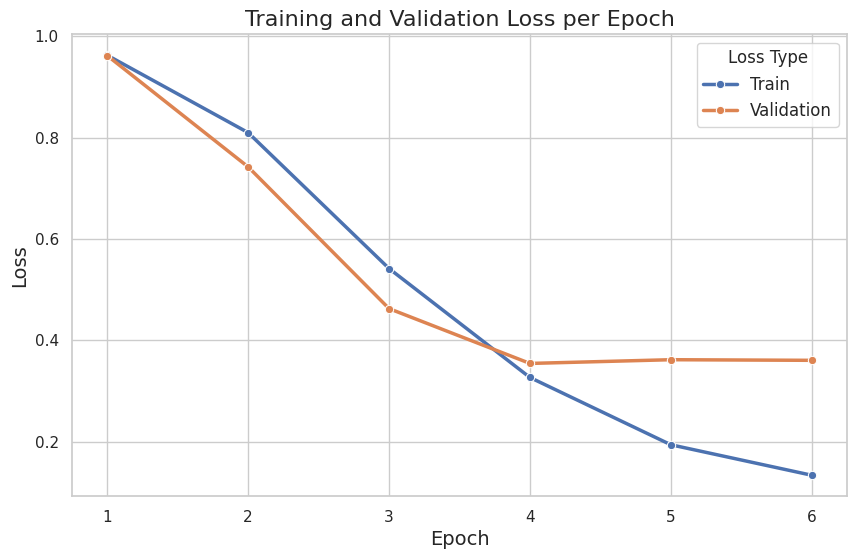

In [ ]:
custom_trainer.display_losses(ret)

## Cross validation

In [ ]:
num_epochs = 8
patience = 3
min_delta = 0.001
n_splits = 3
batch_size = 8

trainer = MultiClassTrainer(model_name="camembert-base",
                            num_classes=len(np.unique(labels)))

rets = trainer.cross_validation(texts=texts,
              labels=labels,
              n_splits=n_splits,
              num_epochs=num_epochs,
              batch_size=batch_size,
              patience=patience,
              min_delta=min_delta)

Device : cuda


> Fold 1
Epoch 0/7, Training Loss: 0.9716, Validation Loss: 0.8880, Validation MCC: 0.0000
Epoch 1/7, Training Loss: 0.8632, Validation Loss: 0.7545, Validation MCC: 0.4242
Epoch 2/7, Training Loss: 0.6518, Validation Loss: 0.5569, Validation MCC: 0.6504
Epoch 3/7, Training Loss: 0.4222, Validation Loss: 0.4237, Validation MCC: 0.7488
Epoch 4/7, Training Loss: 0.2572, Validation Loss: 0.3871, Validation MCC: 0.7712
Epoch 5/7, Training Loss: 0.1801, Validation Loss: 0.3383, Validation MCC: 0.8152
Epoch 6/7, Training Loss: 0.1251, Validation Loss: 0.3029, Validation MCC: 0.8509
Epoch 7/7, Training Loss: 0.0805, Validation Loss: 0.3360, Validation MCC: 0.8318
Best epoch: 6, Best loss: 0.3029


> Fold 2
Epoch 0/7, Training Loss: 0.9813, Validation Loss: 0.9167, Validation MCC: 0.0000
Epoch 1/7, Training Loss: 0.8401, Validation Loss: 0.6791, Validation MCC: 0.6253
Epoch 2/7, Training Loss: 0.5609, Validation Loss: 0.4588, Validation MCC: 0.7298
Epoch 3/7, Training Loss: 0.3

In [ ]:
rets

[{'train_losses': [0.9716287110057579,
   0.8632194262168129,
   0.6517598331730983,
   0.4221790859920119,
   0.2571859208838589,
   0.1800635488524201,
   0.12507701633015866,
   0.08054293858993629],
  'val_losses': [0.8879978415941951,
   0.7544897147501358,
   0.5568943993009702,
   0.42369107917101695,
   0.3870831075491327,
   0.3382883666440694,
   0.3028729384896731,
   0.33599730281893053],
  'val_metrics': [{'class_precision': array([0.        , 0.58883249, 0.        ]),
    'class_recall': array([0., 1., 0.]),
    'class_f1': array([0.        , 0.74121406, 0.        ]),
    'class_support': array([165, 464, 159]),
    'f1_macro': 0.2470713525026624,
    'f1_micro': 0.5888324873096447,
    'f1_weighted': 0.4364509171113021,
    'accuracy': 0.5888324873096447,
    'mcc': 0.0,
    'confusion_matrix': array([[  0, 165,   0],
           [  0, 464,   0],
           [  0, 159,   0]])},
   {'class_precision': array([0.63846154, 0.7147651 , 0.64516129]),
    'class_recall': array([0

In [ ]:
print(rets[1]["val_losses"])
print(rets[1]["best_epoch"])
print(rets[1]["best_loss"])


[0.9211921625667148, 0.6958440039495025, 0.41236364224342387, 0.4367404667039712, 0.3942488883104589, 0.3113496134603264, 0.3047984169626778, 0.31359743821726305]
7
0.31359743821726305


In [ ]:
print(rets[2]["val_losses"])
print(rets[2]["best_epoch"])
print(rets[2]["best_loss"])

[0.9182795575170806, 0.7952132578751053, 0.45955188948698716, 0.33831895917955074, 0.3144565737533449, 0.26469541610115105, 0.24430331789107637, 0.33372793267622136]
7
0.33372793267622136


# Release GPU Memory

In [ ]:
model = None
gc.collect()
if device.startswith("cuda"):
    torch.cuda.empty_cache()
    torch.cuda.synchronize()

# End of game